---
# Adam Talbot Scratch - Forecasting
---

## Imports

In [1]:
# standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# no yelling in the library
import warnings
warnings.filterwarnings("ignore")

# sklearn imports
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, explained_variance_score

# time series imports
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import Holt
from datetime import datetime

# pickle for reloading model object
import pickle

# visualization settings
plt.rc('figure', figsize=(13, 7))
plt.rc('font', size=16)
# sns.set_palette('tab20')
plt.style.use('seaborn-darkgrid')

# custom modules
import wrangle as w
import explore as e

---
## Clustering

In [2]:
# load model
filename = 'finalized_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model

KMeans(n_clusters=7, random_state=527)

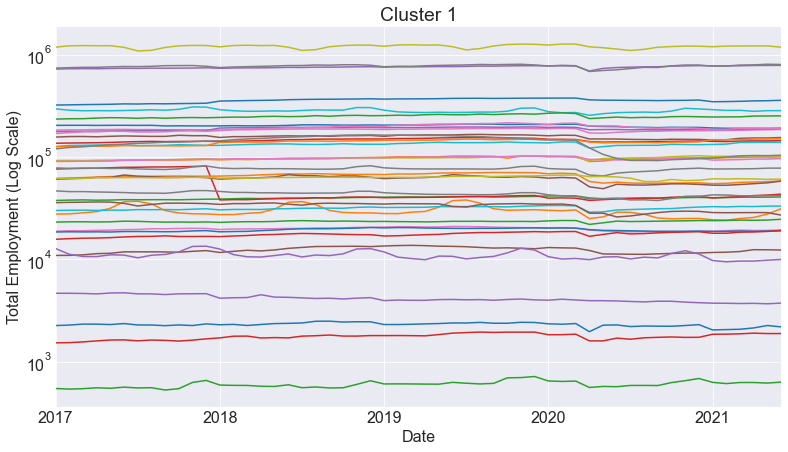

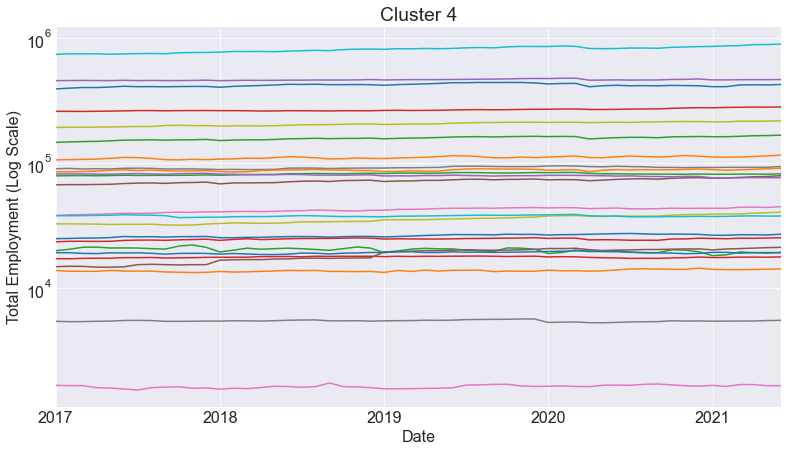

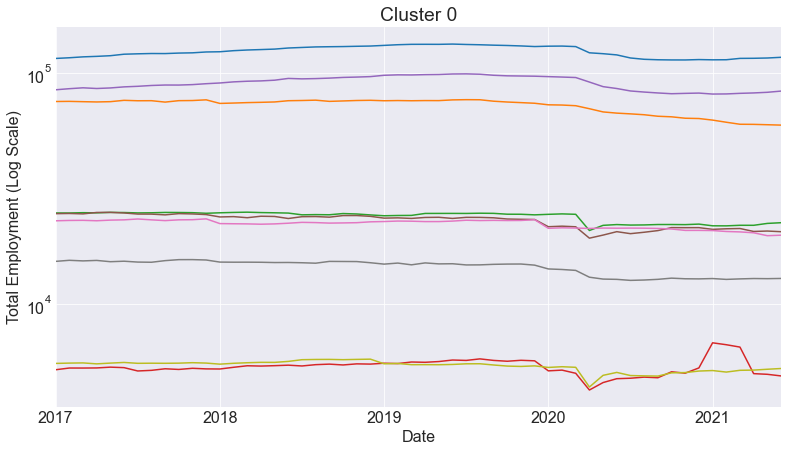

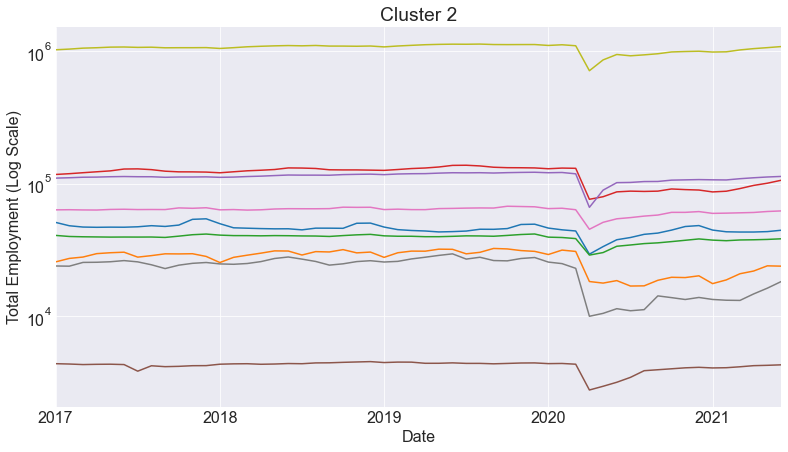

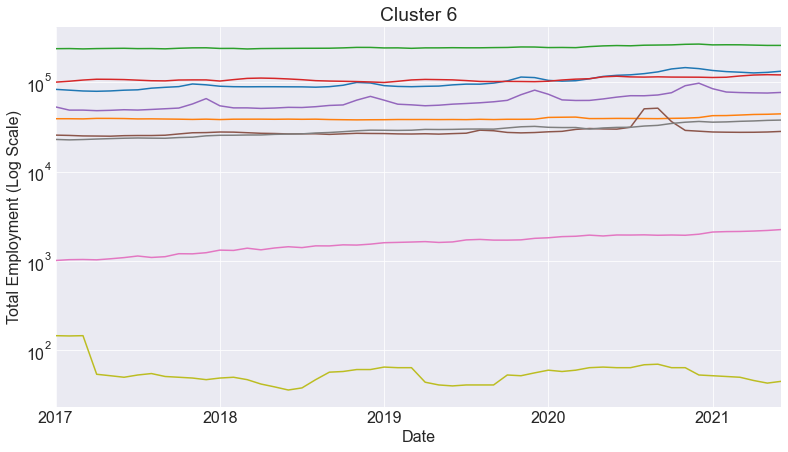

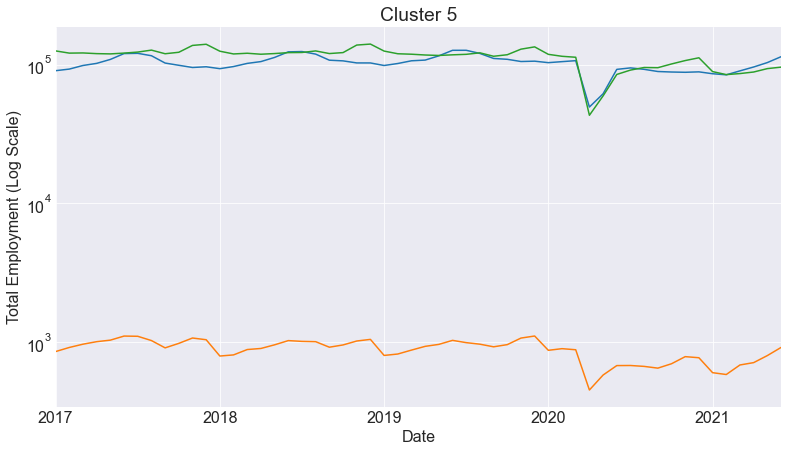

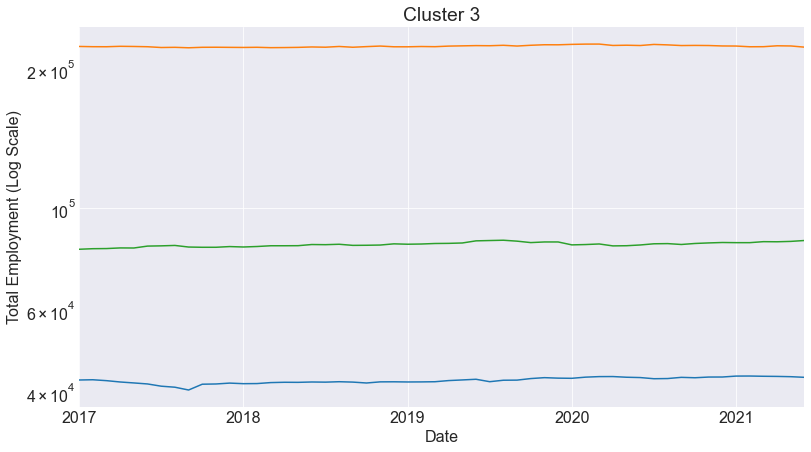

In [3]:
# acquire and prep data
df = w.get_tx_data()
# subset data into a dictionary of dfs
industry_df_dict, ind_list = w.create_df_dict(df)
# charaterize series of data for each industry to make time series data into continuous data we can cluster on
char_df = e.create_char_df(industry_df_dict, ind_list)
# scale these characterizations for clustering
scaled_char_df = e.scale(char_df, MinMaxScaler())
# cluster and plot results
char_df = e.load_cluster_and_plot_no_legend(loaded_model, scaled_char_df, char_df, df)

Moderate Negative Impact, Quick Recovery                          38
Minor Negative Impact, Quick Recovery                             24
Positively Impacted                                                9
Significant Negative Impact, Mostly Recovered                      9
Moderate Negative Impact, Slow or No Recovery                      9
No Impact                                                          3
Significant Negative Impact, Mostly Recovered, Highly Seasonal     3
Name: cluster_1, dtype: int64




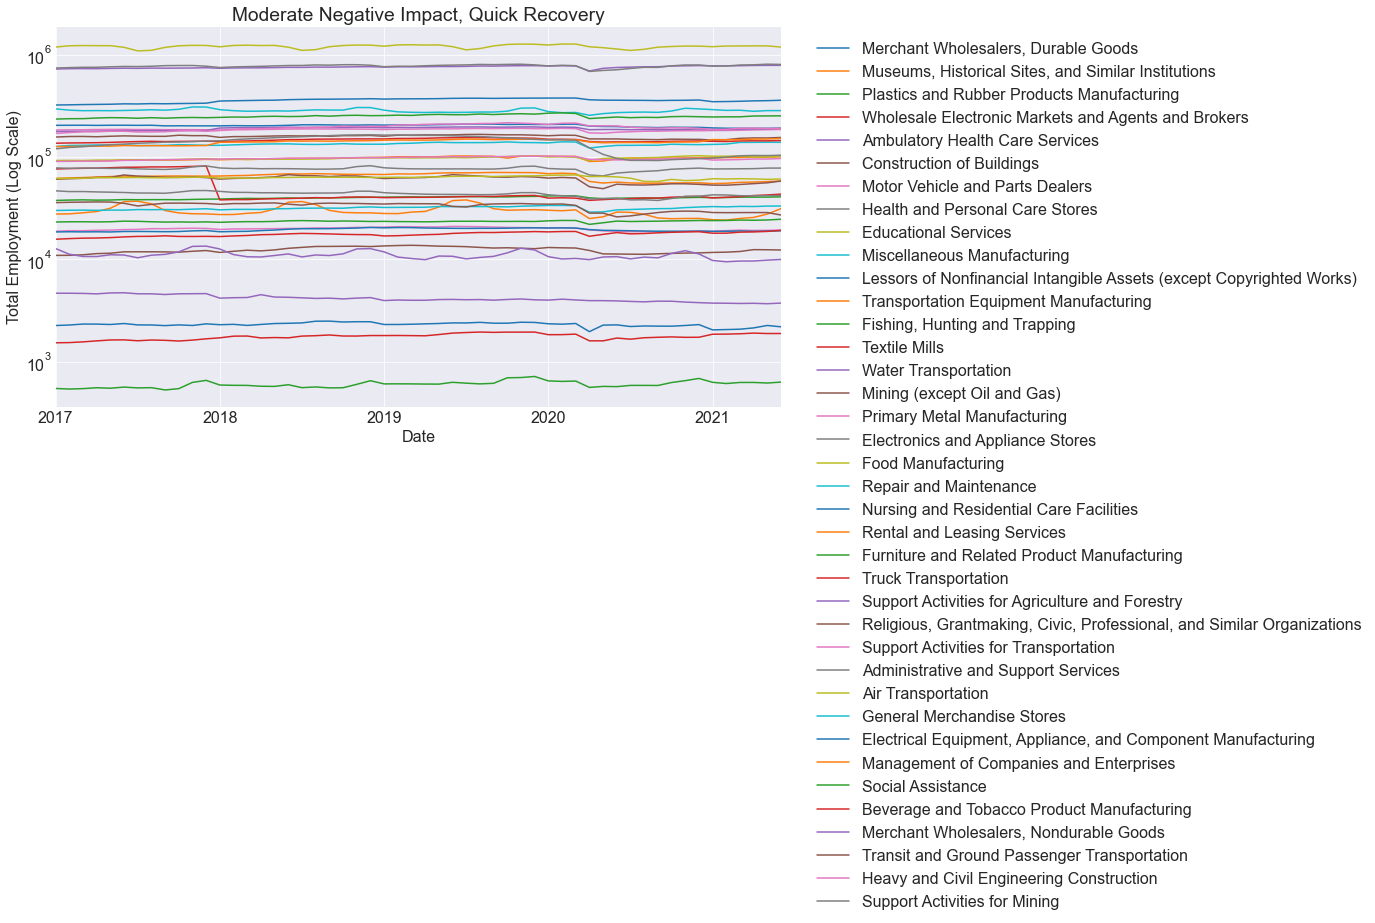

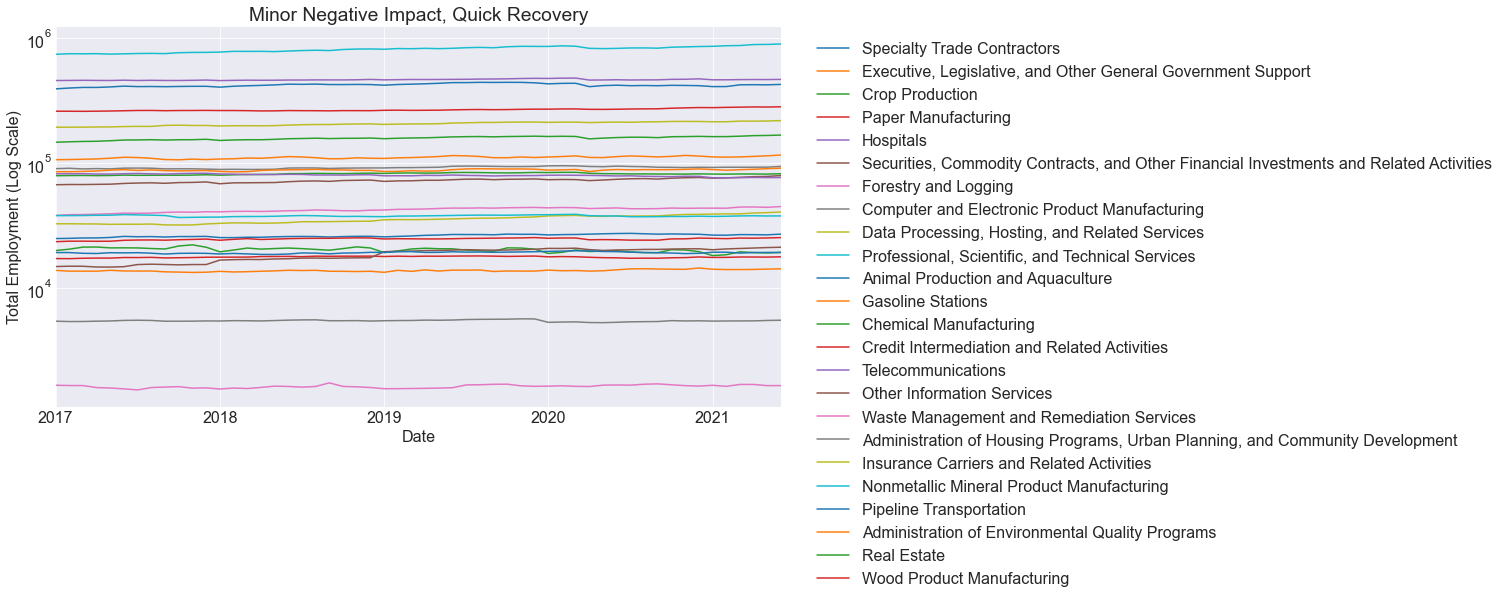

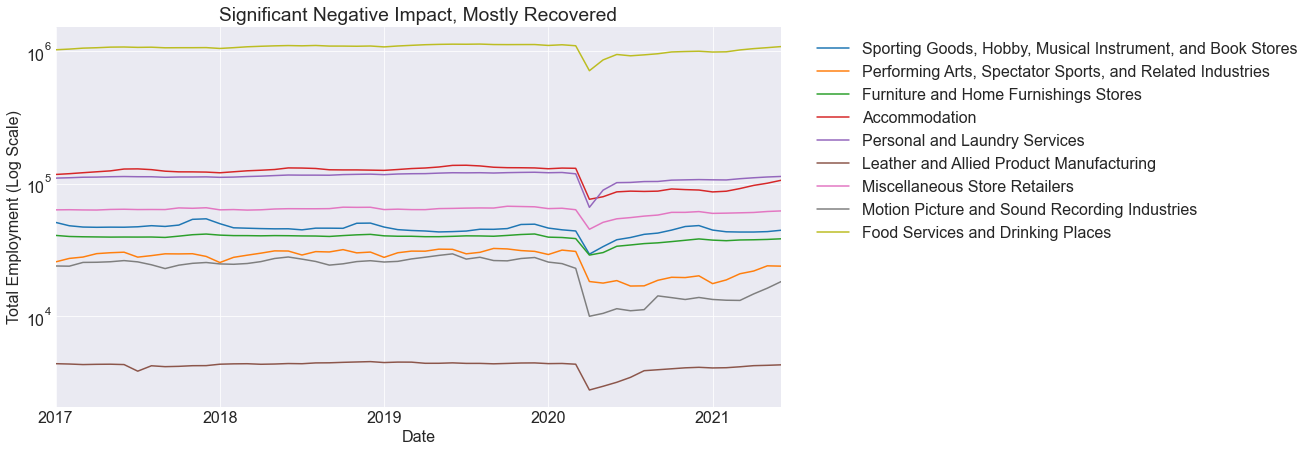

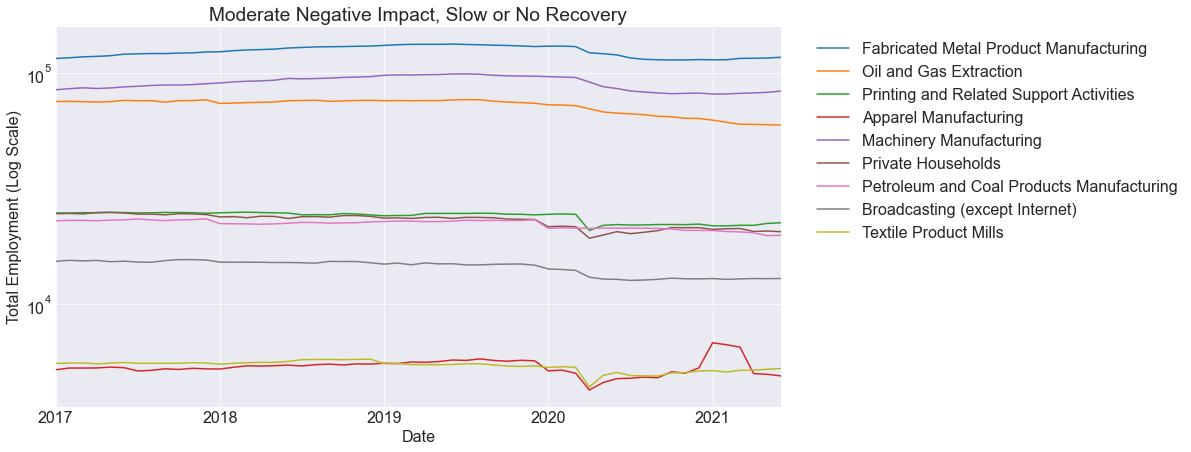

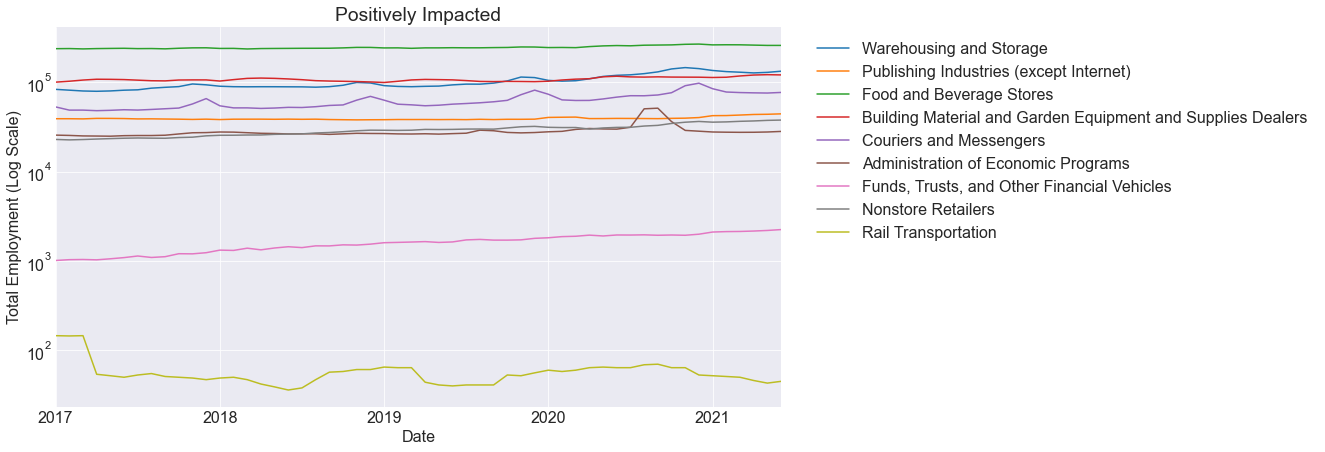

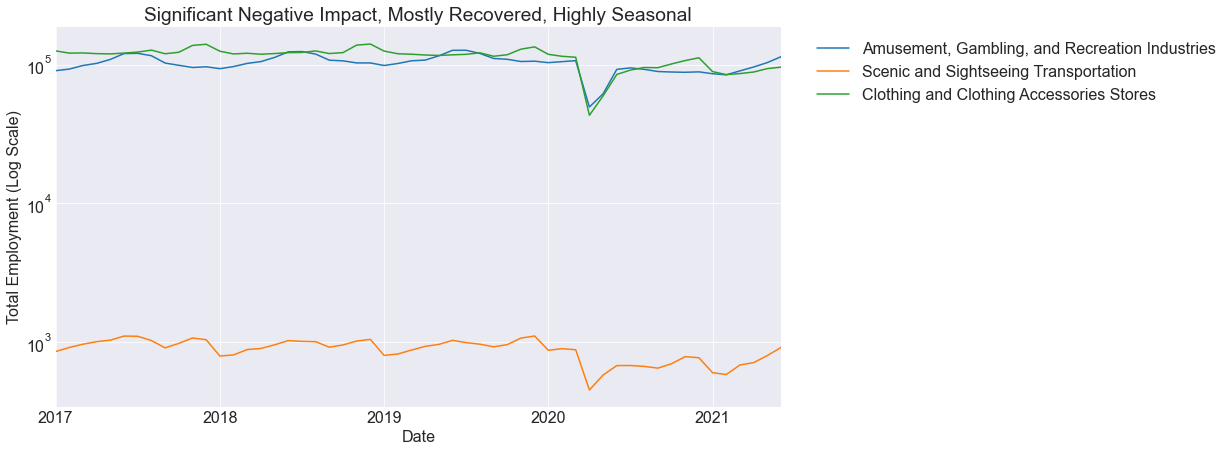

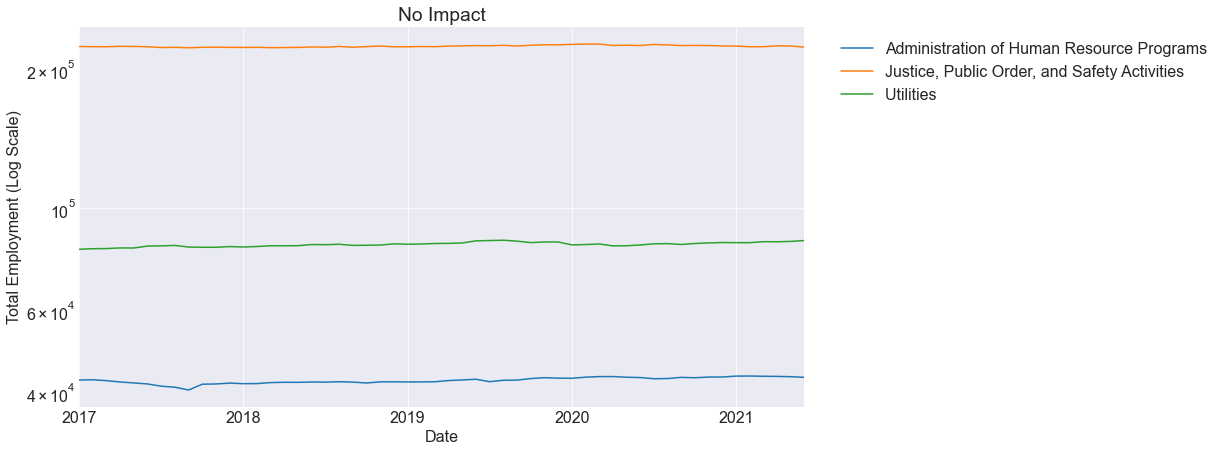

In [4]:
char_df = e.load_cluster_and_plot_w_legend(loaded_model, scaled_char_df, char_df, df)

---
## Forecasting
---

#### Get dictionary of dfs for 12 industries we are interested in

In [5]:
def get_tx_data():
    '''
    Reads in raw data, filters, melts some columns to rows to get monthly observations, and creates datetime index
    '''
    df = pd.read_excel('QCEW-TX-L3-2016.xlsx') # get raw data
    # df = df[df.Ownership == 'Total All'] # filter just to all ownership groups
    df = df[['Year', 'Period', 'Industry Code', 'Industry', 'Month 1 Employment', 'Month 2 Employment', 'Month 3 Employment']] # only keep necessary columns
    df = df.melt(id_vars=['Year', 'Period', 'Industry Code', 'Industry'], var_name='Month', value_name='Total Employment') # melt columns to rows to get monthly instead of quarterly
    df['Month'] = df.Month.apply(lambda x: [int(s) for s in x.split() if s.isdigit()][0]) # pull month integer out of string
    df['Date'] = df.apply(w.extract_date, axis=1) # use function to pull out date from multiple columns
    df.Date = pd.to_datetime(df.Date) # convert data to datetime dtype
    return df

In [6]:
def create_df_dict(df):
    '''
    Takes in df and creates a dictionary of series for all industries and the time interval we are interested in
    '''
    ind_list = df.Industry.value_counts().index.tolist() # get list of industries
    ind_list.remove('Monetary Authorities-Central Bank') # remove this industry since it has missing data
    ind_list.remove('Unclassified') # remove this industry since it is a catchall for a lot of unique industries that would be noise for our clustering
    industry_df_dict = {} # create empty df for dfs for each industry
    for ind in ind_list:
        industry_df_dict[ind] = df[df.Industry == ind][['Date', 'Total Employment']].set_index('Date')['Total Employment'].sort_index() # pull out series
    return industry_df_dict, ind_list

In [7]:
# get dictionary with all industries
# get all monthly data
df = get_tx_data()
# subset data into a dictionary of dfs
industry_df_dict, ind_list = create_df_dict(df)

In [8]:
forecast_ind_list = [
    'Performing Arts, Spectator Sports, and Related Industries',
    'Miscellaneous Store Retailers ',
    'Sporting Goods, Hobby, Musical Instrument, and Book Stores ',
    'Accommodation',
    'Food Services and Drinking Places',
    'Motion Picture and Sound Recording Industries',
    'Personal and Laundry Services',
    'Furniture and Home Furnishings Stores ',
    'Leather and Allied Product Manufacturing',
    'Amusement, Gambling, and Recreation Industries',
    'Scenic and Sightseeing Transportation',
    'Clothing and Clothing Accessories Stores '
]

In [9]:
len(forecast_ind_list)

12

In [10]:
forecast_ind_dict = {}
for ind in forecast_ind_list:
    forecast_ind_dict[ind] = industry_df_dict[ind]

In [11]:
len(forecast_ind_dict)

12

In [12]:
forecast_ind_dict['Clothing and Clothing Accessories Stores ']

Date
2016-01-01    115461
2016-02-01    111574
2016-03-01    112055
2016-04-01    110324
2016-05-01    110453
               ...  
2021-02-01     84663
2021-03-01     86150
2021-04-01     88391
2021-05-01     93523
2021-06-01     95838
Name: Total Employment, Length: 66, dtype: int64

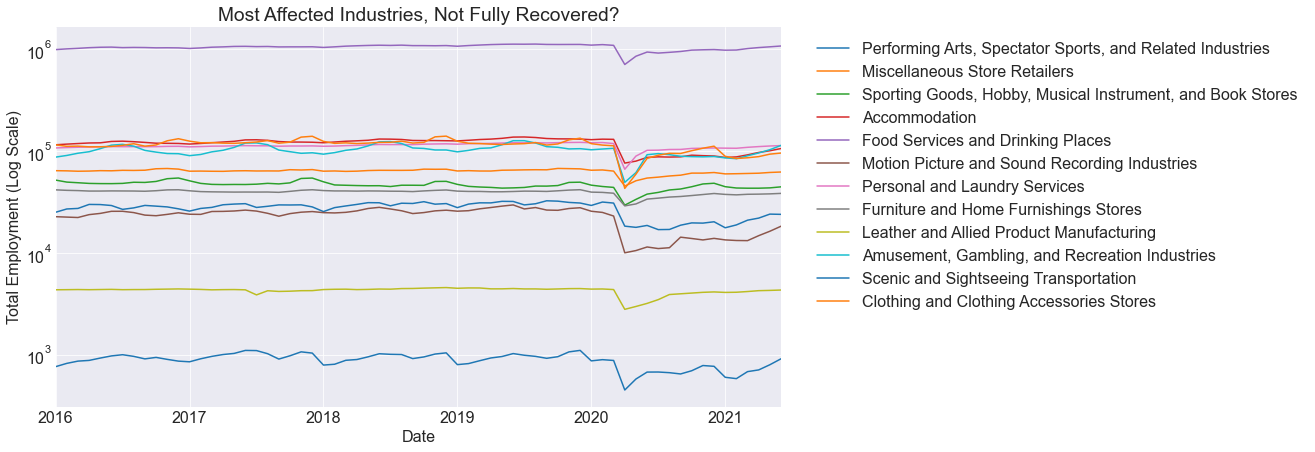

In [13]:
for ind in forecast_ind_list:
    forecast_ind_dict[ind].plot(label=ind)
plt.gca().set(ylabel = 'Total Employment (Log Scale)', title='Most Affected Industries, Not Fully Recovered?')
# plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.1f}M'.format(x / 1_000_000))
plt.yscale('log')
plt.legend(bbox_to_anchor= (1.03,1))
plt.show()

In [14]:
# create a metric of (June 2021 / June 2019) * 100

In [15]:
def characterize_series(s):
    '''
    Takes in a series of times series data and characterizes it based on it's behavior over a specified interval
    '''
    recovery = (s['2021-06'][0] / s['2019-06'][0]) * 100
    characteristic_dict = {
        'recovery' : recovery
    }
    return characteristic_dict

In [16]:
def create_char_df(industry_df_dict):
    '''
    Creates a pandas df of characterstics of section of times series data
    '''
    characteristics = [] # create empty list for list of dictionaries
    ind_list = list(industry_df_dict.keys())
    for ind in ind_list: # loop through industries
        s = industry_df_dict[ind] # characterize them each using function
        characteristics.append(characterize_series(s)) # append to list of dicts
    char_df = pd.DataFrame(characteristics, index=ind_list) # convert to df
    return char_df

##### % Recovered Table 

In [17]:
char_df = create_char_df(forecast_ind_dict).sort_values(by='recovery')
char_df

recovery
Motion Picture and Sound Recording Industries        61.763515
Performing Arts, Spectator Sports, and Related ...   74.684926
Accommodation                                        77.209860
Clothing and Clothing Accessories Stores             81.494898
Scenic and Sightseeing Transportation                88.888889
Amusement, Gambling, and Recreation Industries       89.903270
Personal and Laundry Services                        93.778813
Miscellaneous Store Retailers                        95.706924
Furniture and Home Furnishings Stores                95.801793
Food Services and Drinking Places                    95.909662
Leather and Allied Product Manufacturing             96.645046
Sporting Goods, Hobby, Musical Instrument, and ...  102.360633

---
### Resumption
---

####  Sporting Goods, Hobby, Musical Instrument, and Book Stores

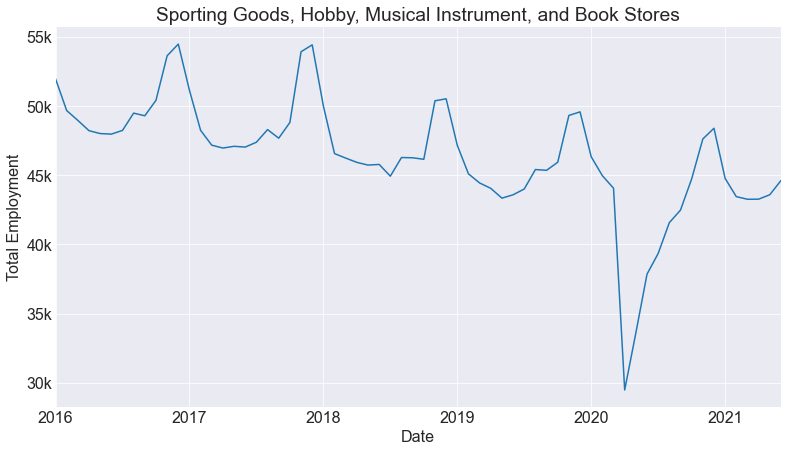

In [18]:
# forecast pre-COVID behavior after full recovery for Sporting Goods industry
s_sporting = forecast_ind_dict['Sporting Goods, Hobby, Musical Instrument, and Book Stores ']
s_sporting.plot()
plt.gca().set(ylabel = 'Total Employment', title='Sporting Goods, Hobby, Musical Instrument, and Book Stores')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

##### Splits

In [19]:
train = s_sporting['2016' : '2018']
# validate = s_sporting['2018']
test = s_sporting['2019']

In [20]:
# create a function to visualize splits
def viz_splits(train, test):
    ax = train.plot(label='train')
    # validate.plot(ax=ax, label='validate')
    test.plot(ax=ax, label='test')
    plt.legend()
    plt.title('Visualizing Splits')
    plt.ylabel('Total Employment')
    ax.yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000))
    plt.show();

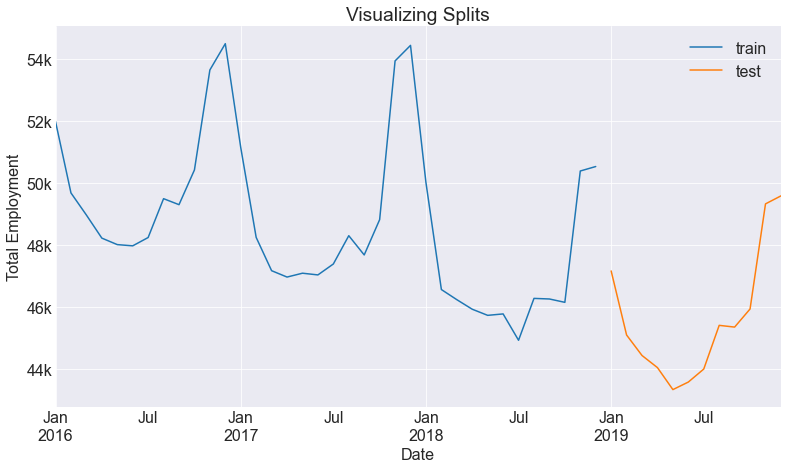

In [21]:
viz_splits(train, test)

##### Seasonal Decomp 

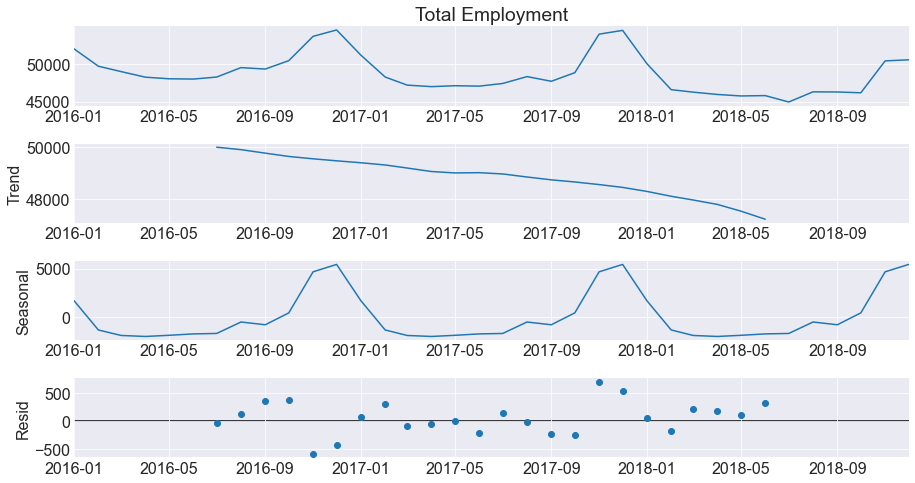

In [22]:
_ = sm.tsa.seasonal_decompose(train).plot()

##### Forecast

In [23]:
forecast = train['2018'] + train.diff(12).mean()
forecast.index = test.index

In [24]:
train.diff(12).mean()

-1482.7916666666667

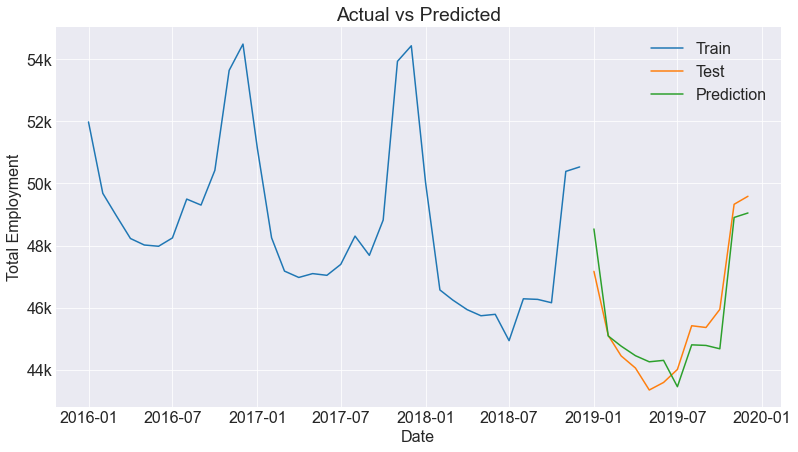

In [25]:
plt.plot(train, label='Train')
#plt.plot(validate, label='Validate')
plt.plot(test, label='Test')
plt.xlabel('Date')
plt.ylabel('Total Employment')
plt.plot(forecast, label = 'Prediction')
plt.title('Actual vs Predicted')
plt.legend()
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000))
plt.show()

In [26]:
# get RMSE
mean_squared_error(test, forecast, squared=False)

738.7250195532088

In [27]:
# get R^2
explained_variance_score(test, forecast)

0.8638711606813445

In [28]:
# predict the future
# want to predict 1.5 years into future to get us to end of year 2022
# get values for 1.5 years preceding pandemic 2018-07 to 2019-12
historical = s_sporting['2018-07' : '2019-12']

In [29]:
# want to get index that goes from July 2021 to Dec 2022

future_index_str = [
    '2021-07',
    '2021-08',
    '2021-09',
    '2021-10',
    '2021-11', 
    '2021-12', 
    '2022-01', 
    '2022-02', 
    '2022-03',
    '2022-04',
    '2022-05',
    '2022-06',
    '2022-07',
    '2022-08',
    '2022-09',
    '2022-10',
    '2022-11',
    '2022-12'
    ]

future_index = pd.to_datetime(future_index_str)

future_index

DatetimeIndex(['2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01',
               '2021-11-01', '2021-12-01', '2022-01-01', '2022-02-01',
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01',
               '2022-11-01', '2022-12-01'],
              dtype='datetime64[ns]', freq=None)

In [30]:
future = historical + train.diff(12).mean()
# still need to reset the index
future.index = future_index

<AxesSubplot:xlabel='Date'>

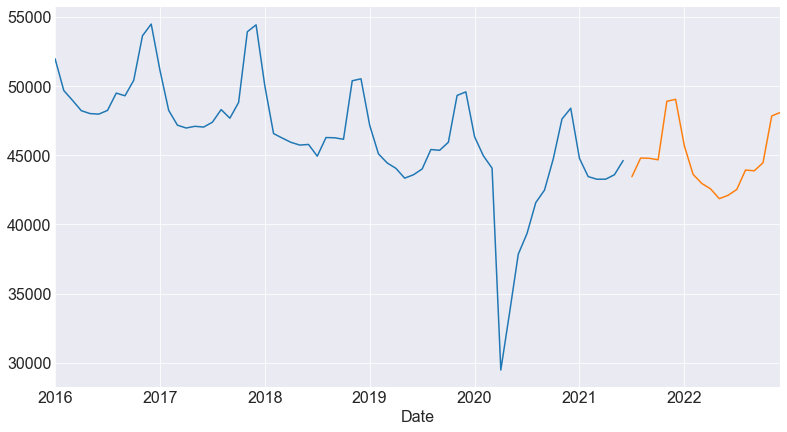

In [31]:
s_sporting.plot()
future.plot()

##### Final Plot

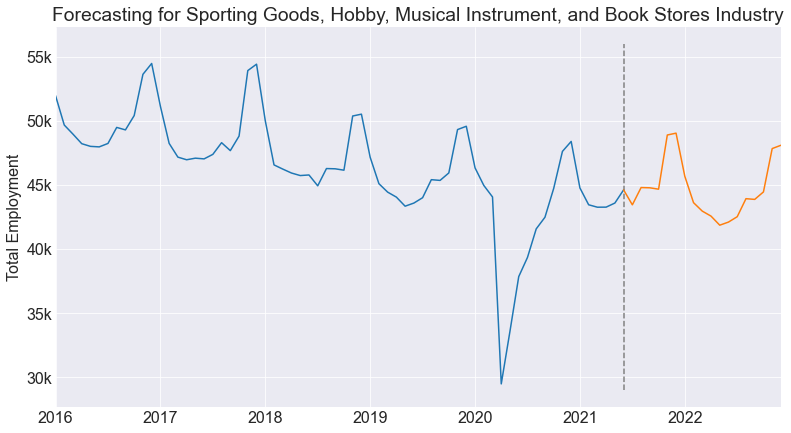

In [32]:
pd.concat([s_sporting, future])[: '2021-06'].plot()
pd.concat([s_sporting, future])['2021-06' : ].plot()
plt.vlines(x='2021-06', ymin=29_000, ymax=56_000, linestyles='--', colors='gray')
plt.gca().set(title='Forecasting for Sporting Goods, Hobby, Musical Instrument, and Book Stores Industry', 
              ylabel='Total Employment')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

---
### Recovery and Resumption
---

####  Motion Picture and Sound Recording Industries

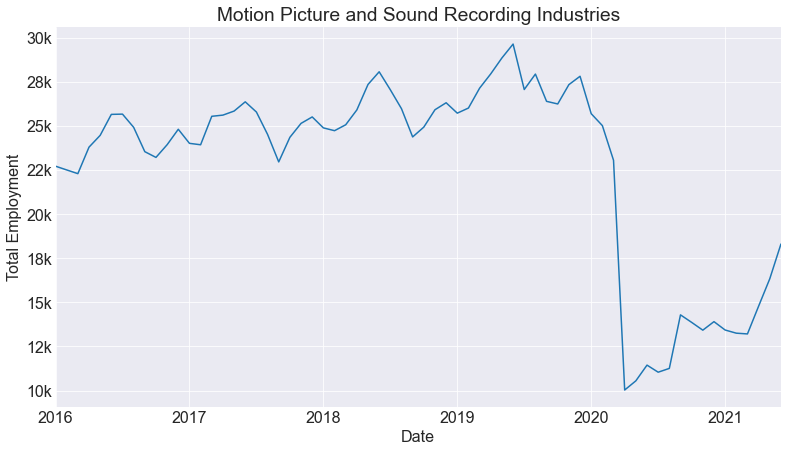

In [33]:
# forecast pre-COVID behavior after full recovery for Sporting Goods industry
s_motion = forecast_ind_dict['Motion Picture and Sound Recording Industries']
s_motion.plot()
plt.gca().set(ylabel = 'Total Employment', title='Motion Picture and Sound Recording Industries')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

##### Just use slope

In [34]:
# find min to figure out where it bottomed out
s_motion[s_motion == s_motion.min()]

Date
2020-04-01    10034
Name: Total Employment, dtype: int64

In [35]:
# now I want to find slope from April to most recent data point
# April 2020 to June 2021 = 14 months
train = s_motion['2020-04' : ]
months = len(train) - 1

In [36]:
train

Date
2020-04-01    10034
2020-05-01    10553
2020-06-01    11444
2020-07-01    11043
2020-08-01    11258
2020-09-01    14291
2020-10-01    13866
2020-11-01    13424
2020-12-01    13907
2021-01-01    13433
2021-02-01    13254
2021-03-01    13211
2021-04-01    14784
2021-05-01    16336
2021-06-01    18303
Name: Total Employment, dtype: int64

In [37]:
# take the last value minus the first value
emp_delta = train[-1] - train[0]

In [38]:
emp_delta / months

590.6428571428571

In [39]:
# get dates to apply slope to
future_index_str = [
    '2020-04',
    '2020-05',
    '2020-06',
    '2020-07',
    '2020-08',
    '2020-09',
    '2020-10',
    '2020-11', 
    '2020-12', 
    '2021-01', 
    '2021-02', 
    '2021-03',
    '2021-04',
    '2021-05',
    '2021-06',
    '2021-07',
    '2021-08',
    '2021-09',
    '2021-10',
    '2021-11',
    '2021-12',
    '2022-01', 
    '2022-02', 
    '2022-03',
    '2022-04',
    '2022-05',
    '2022-06',
    '2022-07',
    '2022-08',
    '2022-09',
    '2022-10',
    '2022-11',
    '2022-12'
    ]

future_index = pd.to_datetime(future_index_str)

future_index

DatetimeIndex(['2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01',
               '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01',
               '2020-12-01', '2021-01-01', '2021-02-01', '2021-03-01',
               '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01',
               '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01',
               '2021-12-01', '2022-01-01', '2022-02-01', '2022-03-01',
               '2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01',
               '2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01',
               '2022-12-01'],
              dtype='datetime64[ns]', freq=None)

In [40]:
len(future_index)

33

In [41]:
# write a function that takes in the first value, the slope, and calculates each value moving forward n months
numbers = [10034]
slope = emp_delta / months
for month in range(32):
    new = numbers[-1] + slope
    numbers.append(new)

In [42]:
slope_prediction = pd.Series(data=numbers, index=future_index)

<AxesSubplot:xlabel='Date'>

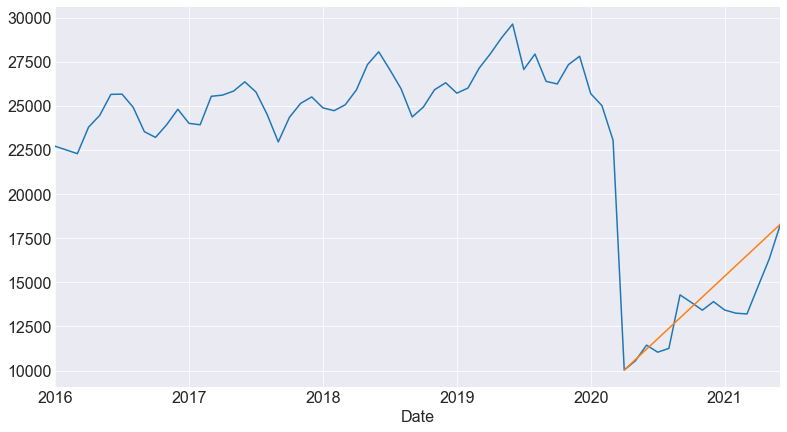

In [43]:
s_motion.plot()
# slope_prediction['2021-06' : ].plot()
# slope_prediction.plot()
slope_prediction[: '2021-06'].plot()

In [44]:
explained_variance_score(s_motion['2020-04' : ], slope_prediction[ : '2021-06'])

0.676796283251758

In [45]:
mean_squared_error(s_motion['2020-04' : ], slope_prediction[ : '2021-06'], squared=False)

1511.5613632141776

<AxesSubplot:xlabel='Date'>

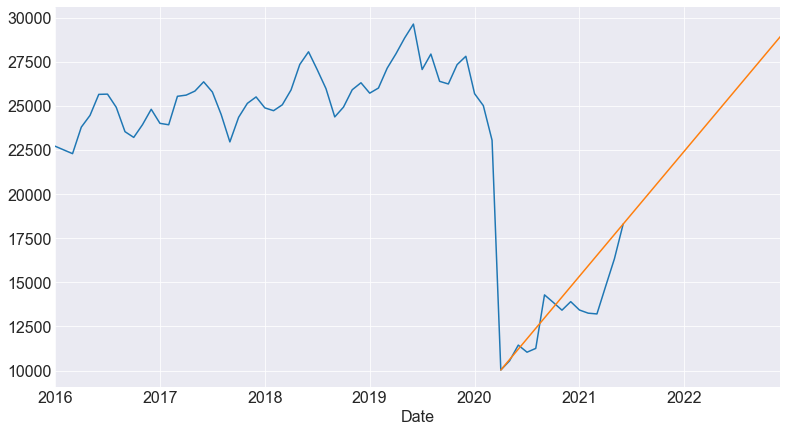

In [46]:
s_motion.plot()
# slope_prediction['2021-06' : ].plot()
# slope_prediction.plot()
slope_prediction.plot()

In [47]:
# figure out when recovery happens
s_motion['2019']

Date
2019-01-01    25720
2019-02-01    26010
2019-03-01    27136
2019-04-01    27948
2019-05-01    28849
2019-06-01    29634
2019-07-01    27059
2019-08-01    27935
2019-09-01    26389
2019-10-01    26241
2019-11-01    27336
2019-12-01    27810
Name: Total Employment, dtype: int64

In [48]:
slope_prediction['2021-06' :]

2021-06-01    18303.000000
2021-07-01    18893.642857
2021-08-01    19484.285714
2021-09-01    20074.928571
2021-10-01    20665.571429
2021-11-01    21256.214286
2021-12-01    21846.857143
2022-01-01    22437.500000
2022-02-01    23028.142857
2022-03-01    23618.785714
2022-04-01    24209.428571
2022-05-01    24800.071429
2022-06-01    25390.714286
2022-07-01    25981.357143
2022-08-01    26572.000000
2022-09-01    27162.642857
2022-10-01    27753.285714
2022-11-01    28343.928571
2022-12-01    28934.571429
dtype: float64

Recovery happens 2022-09

Use slope prediction from 2021-07 to 2022-09

In [49]:
# resume seasonal behavior from 2022-10 to 2023-12
train = s_motion['2016' : '2018']

In [50]:
# predict the future
historical = s_motion['2018-10' : '2019-12']

In [51]:
# define future index
future_index_str = [
    '2022-10',
    '2022-11', 
    '2022-12', 
    '2023-01', 
    '2023-02', 
    '2023-03',
    '2023-04',
    '2023-05',
    '2023-06',
    '2023-07',
    '2023-08',
    '2023-09',
    '2023-10',
    '2023-11',
    '2023-12'
    ]

future_index = pd.to_datetime(future_index_str)

future_index

DatetimeIndex(['2022-10-01', '2022-11-01', '2022-12-01', '2023-01-01',
               '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01',
               '2023-06-01', '2023-07-01', '2023-08-01', '2023-09-01',
               '2023-10-01', '2023-11-01', '2023-12-01'],
              dtype='datetime64[ns]', freq=None)

In [52]:
future = historical + train.diff(12).mean()
# still need to reset the index
future.index = future_index

<AxesSubplot:xlabel='Date'>

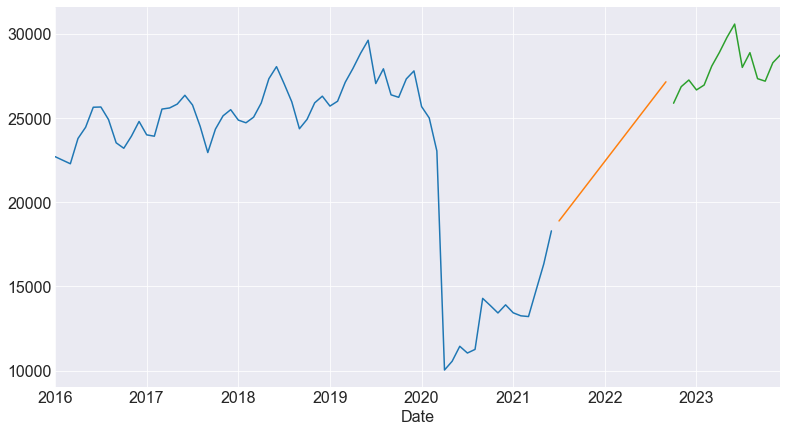

In [53]:
s_motion.plot()
slope_prediction['2021-07' : '2022-09'].plot()
future.plot()

In [54]:
len(slope_prediction['2021-07' : '2022-09'])

15

##### Final Plot

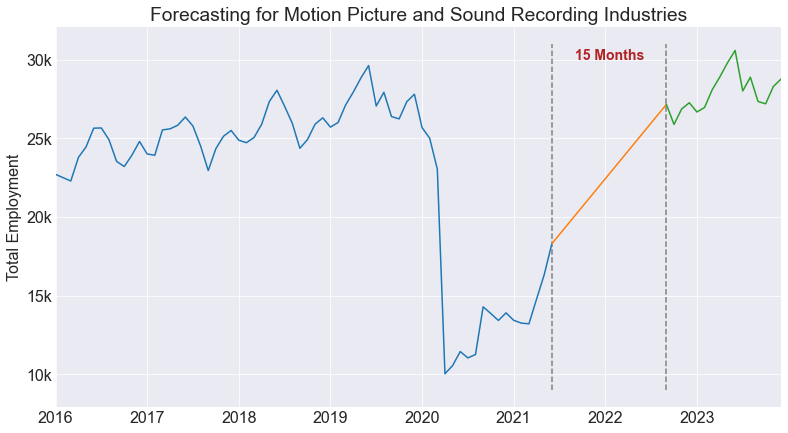

In [55]:
full_forecast = pd.concat([s_motion, slope_prediction['2021-07' : '2022-09'], future])
full_forecast[ : '2021-06'].plot() # data we have
full_forecast['2021-06' : '2022-09'].plot() # linear recovery forecast
full_forecast['2022-09' : ].plot() # resumption forecast
plt.vlines(x='2021-06', ymin=9_000, ymax=31_000, linestyles='--', colors='gray')
plt.vlines(x='2022-09', ymin=9_000, ymax=31_000, linestyles='--', colors='gray')
plt.text('2021-09', 30_000, '15 Months', fontsize=14, color='firebrick', fontweight='bold')
plt.gca().set(title='Forecasting for Motion Picture and Sound Recording Industries', 
              ylabel='Total Employment')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

---
##### Holt's Linear Trend (defaults)

In [56]:
s_motion[s_motion == s_motion.min()]

Date
2020-04-01    10034
Name: Total Employment, dtype: int64

In [57]:
# define train set for this model
train = s_motion['2020-04' : ]
train

Date
2020-04-01    10034
2020-05-01    10553
2020-06-01    11444
2020-07-01    11043
2020-08-01    11258
2020-09-01    14291
2020-10-01    13866
2020-11-01    13424
2020-12-01    13907
2021-01-01    13433
2021-02-01    13254
2021-03-01    13211
2021-04-01    14784
2021-05-01    16336
2021-06-01    18303
Name: Total Employment, dtype: int64

In [58]:
# define future index for this model
# want to get index that goes from July 2021 to Dec 2022
future_index_str = [
    '2021-07',
    '2021-08',
    '2021-09',
    '2021-10',
    '2021-11', 
    '2021-12', 
    '2022-01', 
    '2022-02', 
    '2022-03',
    '2022-04',
    '2022-05',
    '2022-06',
    '2022-07',
    '2022-08',
    '2022-09',
    '2022-10',
    '2022-11',
    '2022-12',
    '2023-01', 
    '2023-02', 
    '2023-03',
    '2023-04',
    '2023-05',
    '2023-06',
    '2023-07',
    '2023-08',
    '2023-09',
    '2023-10',
    '2023-11',
    '2023-12'
    ]

future_index = pd.to_datetime(future_index_str)

future_index

DatetimeIndex(['2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01',
               '2021-11-01', '2021-12-01', '2022-01-01', '2022-02-01',
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01',
               '2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01',
               '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01',
               '2023-07-01', '2023-08-01', '2023-09-01', '2023-10-01',
               '2023-11-01', '2023-12-01'],
              dtype='datetime64[ns]', freq=None)

In [59]:
model = Holt(train)
model = model.fit()

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<AxesSubplot:xlabel='Date'>

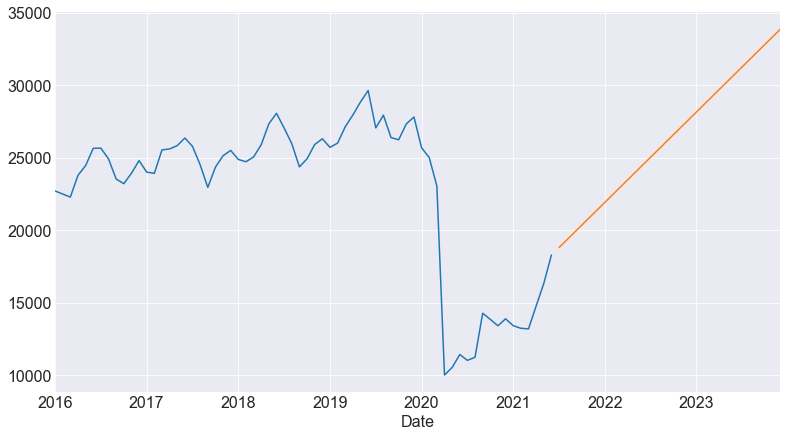

In [60]:
holts = model.predict(start = future_index[0], end = future_index[-1])
s_motion.plot()
holts.plot()

In [61]:
train.index[0]

Timestamp('2020-04-01 00:00:00')

In [62]:
train.index[-1]

Timestamp('2021-06-01 00:00:00')

In [63]:
# check accuracy of this prediction
holts = model.predict(start = train.index[0], end = train.index[-1])

<AxesSubplot:xlabel='Date'>

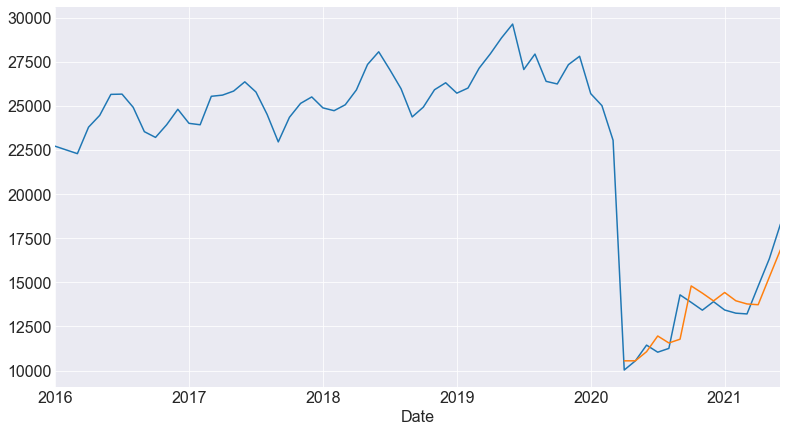

In [64]:
s_motion.plot()
holts.plot()

Not sure what is going on here, not what I was expecting

In [65]:
# get values that indicate recovery
s_motion['2019']

Date
2019-01-01    25720
2019-02-01    26010
2019-03-01    27136
2019-04-01    27948
2019-05-01    28849
2019-06-01    29634
2019-07-01    27059
2019-08-01    27935
2019-09-01    26389
2019-10-01    26241
2019-11-01    27336
2019-12-01    27810
Name: Total Employment, dtype: int64

In [66]:
holts

2020-04-01    10553.000000
2020-05-01    10555.543359
2020-06-01    11071.960823
2020-07-01    11961.124928
2020-08-01    11566.484396
2020-09-01    11778.405499
2020-10-01    14797.550107
2020-11-01    14389.678141
2020-12-01    13947.752696
2021-01-01    14426.124014
2021-02-01    13956.787055
2021-03-01    13776.265443
2021-04-01    13732.521591
2021-05-01    15297.542494
2021-06-01    16849.710925
Freq: MS, dtype: float64

**Recovery date is 2022-10**

In [67]:
# redefine future index based on when recovery occured
future_index_str = [
    '2021-07',
    '2021-08',
    '2021-09',
    '2021-10',
    '2021-11', 
    '2021-12', 
    '2022-01', 
    '2022-02', 
    '2022-03',
    '2022-04',
    '2022-05',
    '2022-06',
    '2022-07',
    '2022-08',
    '2022-09',
    '2022-10'
    ]

future_index = pd.to_datetime(future_index_str)

len(future_index)

16

<AxesSubplot:xlabel='Date'>

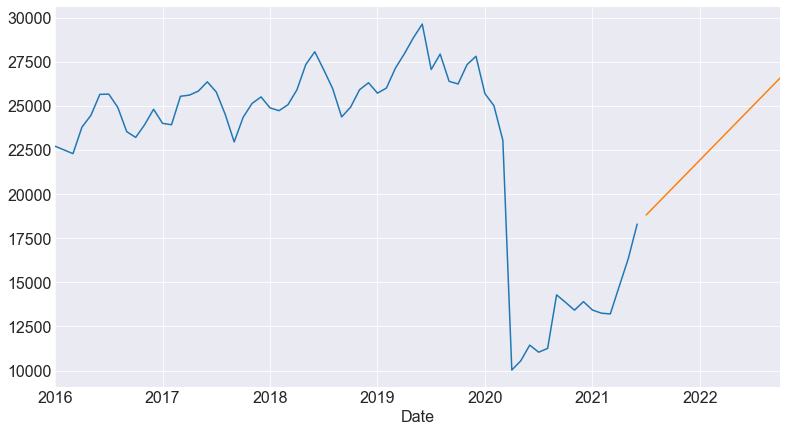

In [68]:
# make adjusted predictions
holts = model.predict(start = future_index[0], end = future_index[-1])
s_motion.plot()
holts.plot()

##### Last normal season 

In [69]:
# now resume previous behavior?

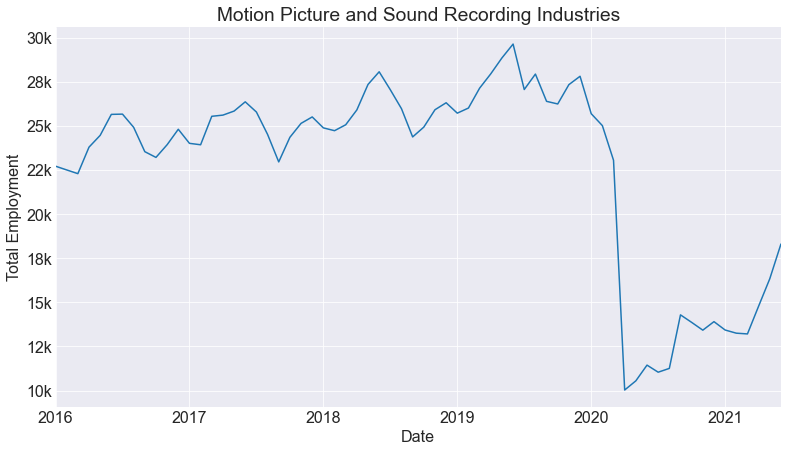

In [70]:
# forecast pre-COVID behavior after full recovery
s_motion = forecast_ind_dict['Motion Picture and Sound Recording Industries']
s_motion.plot()
plt.gca().set(ylabel = 'Total Employment', title='Motion Picture and Sound Recording Industries')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

##### Splits

In [71]:
train = s_motion['2016' : '2018']
test = s_motion['2019']

In [72]:
# create a function to visualize splits
def viz_splits(train, test):
    ax = train.plot(label='train')
    test.plot(ax=ax, label='test')
    plt.legend()
    plt.title('Visualizing Splits')
    plt.ylabel('Total Employment')
    ax.yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000))
    plt.show();

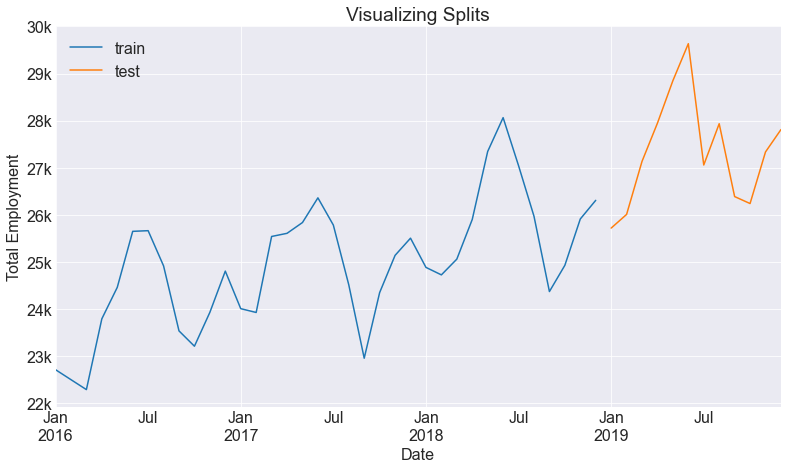

In [73]:
viz_splits(train, test)

##### Seasonal Decomp 

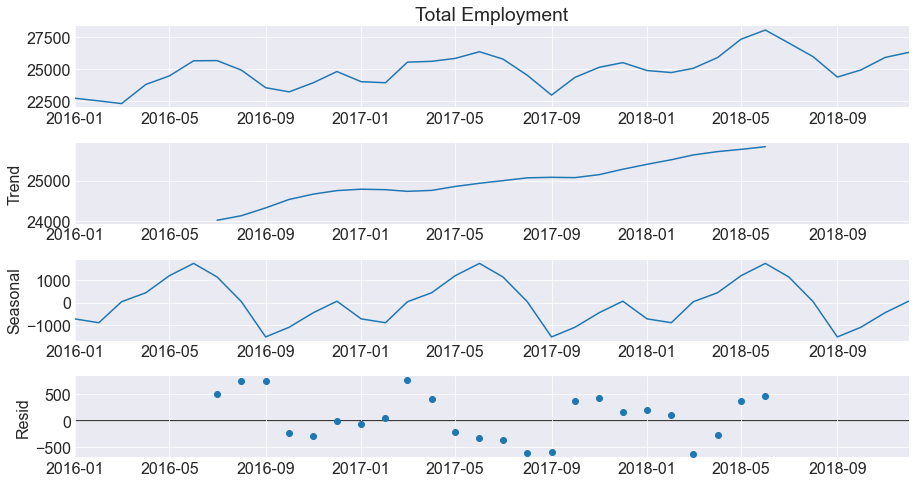

In [74]:
_ = sm.tsa.seasonal_decompose(train).plot()

##### Forecast

In [75]:
forecast = train['2018'] + train.diff(12).mean()
forecast.index = test.index

In [76]:
train.diff(12).mean()

959.9583333333334

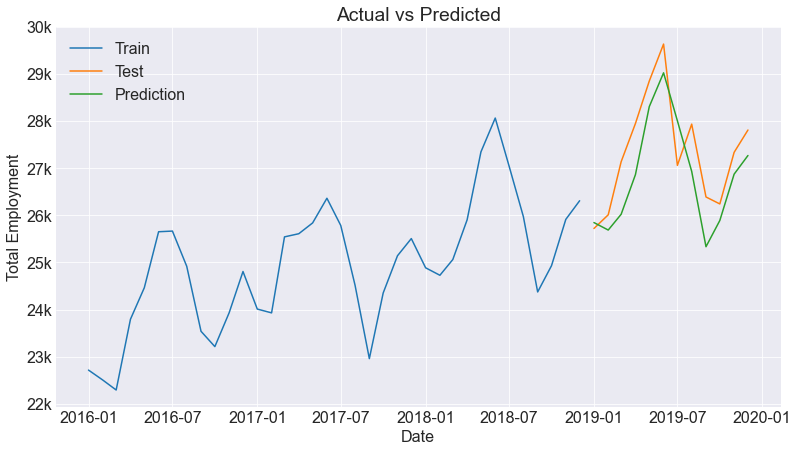

In [77]:
plt.plot(train, label='Train')
#plt.plot(validate, label='Validate')
plt.plot(test, label='Test')
plt.xlabel('Date')
plt.ylabel('Total Employment')
plt.plot(forecast, label = 'Prediction')
plt.title('Actual vs Predicted')
plt.legend()
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000))
plt.show()

In [78]:
# get RMSE
mean_squared_error(test, forecast, squared=False)

755.7787110453997

In [79]:
# get R^2
explained_variance_score(test, forecast)

0.7461388782842269

In [80]:
# predict the future
# want to predict into future to get us to end of year 2023
# get values for respective months preceding pandemic 2018-11 to 2019-12
historical = s_motion['2018-11' : '2019-12']

In [81]:
# want to get index that goes from July 2021 to Dec 2022

future_index_str = [
    '2022-11', 
    '2022-12', 
    '2023-01', 
    '2023-02', 
    '2023-03',
    '2023-04',
    '2023-05',
    '2023-06',
    '2023-07',
    '2023-08',
    '2023-09',
    '2023-10',
    '2023-11',
    '2023-12'
    ]

future_index = pd.to_datetime(future_index_str)

future_index

DatetimeIndex(['2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01',
               '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01',
               '2023-07-01', '2023-08-01', '2023-09-01', '2023-10-01',
               '2023-11-01', '2023-12-01'],
              dtype='datetime64[ns]', freq=None)

In [82]:
future = historical + train.diff(12).mean()
# still need to reset the index
future.index = future_index

<AxesSubplot:xlabel='Date'>

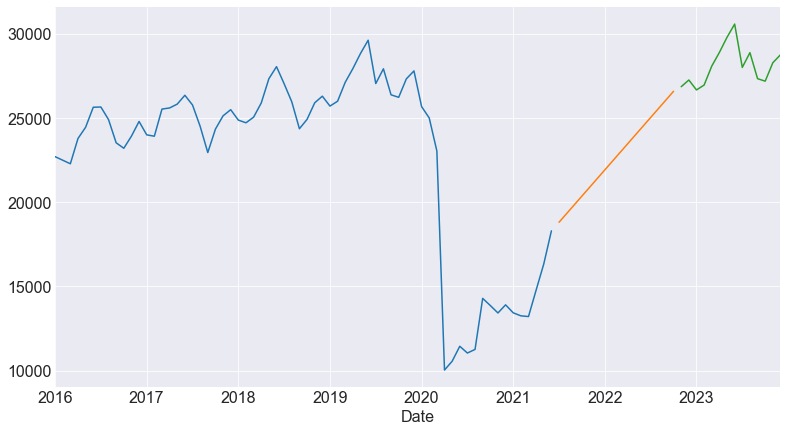

In [83]:
s_motion.plot()
holts.plot()
future.plot()

##### Final Plot

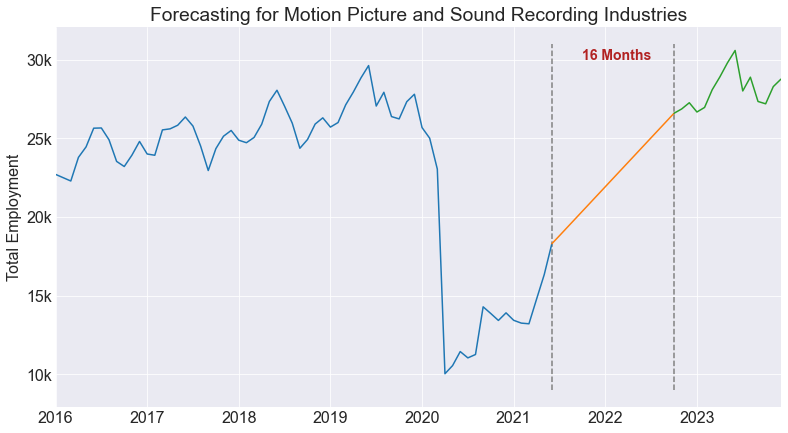

In [84]:
full_forecast = pd.concat([s_motion, holts, future])
full_forecast[ : '2021-06'].plot() # data we have
full_forecast['2021-06' : '2022-10'].plot() # linear recovery forecast
full_forecast['2022-10' : ].plot() # resumption forecast
plt.vlines(x='2021-06', ymin=9_000, ymax=31_000, linestyles='--', colors='gray')
plt.vlines(x='2022-10', ymin=9_000, ymax=31_000, linestyles='--', colors='gray')
plt.text('2021-10', 30_000, '16 Months', fontsize=14, color='firebrick', fontweight='bold')
plt.gca().set(title='Forecasting for Motion Picture and Sound Recording Industries', 
              ylabel='Total Employment')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

---
##### Holt's Linear Trend (no smoothing)

In [85]:
s_motion[s_motion == s_motion.min()]

Date
2020-04-01    10034
Name: Total Employment, dtype: int64

In [86]:
# define train set for this model
train = s_motion['2020-04' : ]
train

Date
2020-04-01    10034
2020-05-01    10553
2020-06-01    11444
2020-07-01    11043
2020-08-01    11258
2020-09-01    14291
2020-10-01    13866
2020-11-01    13424
2020-12-01    13907
2021-01-01    13433
2021-02-01    13254
2021-03-01    13211
2021-04-01    14784
2021-05-01    16336
2021-06-01    18303
Name: Total Employment, dtype: int64

In [87]:
# define future index for this model
# want to get index that goes from July 2021 to Dec 2022
future_index_str = [
    '2021-07',
    '2021-08',
    '2021-09',
    '2021-10',
    '2021-11', 
    '2021-12', 
    '2022-01', 
    '2022-02', 
    '2022-03',
    '2022-04',
    '2022-05',
    '2022-06',
    '2022-07',
    '2022-08',
    '2022-09',
    '2022-10',
    '2022-11',
    '2022-12',
    '2023-01', 
    '2023-02', 
    '2023-03',
    '2023-04',
    '2023-05',
    '2023-06',
    '2023-07',
    '2023-08',
    '2023-09',
    '2023-10',
    '2023-11',
    '2023-12'
    ]

future_index = pd.to_datetime(future_index_str)

future_index

DatetimeIndex(['2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01',
               '2021-11-01', '2021-12-01', '2022-01-01', '2022-02-01',
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01',
               '2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01',
               '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01',
               '2023-07-01', '2023-08-01', '2023-09-01', '2023-10-01',
               '2023-11-01', '2023-12-01'],
              dtype='datetime64[ns]', freq=None)

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<AxesSubplot:xlabel='Date'>

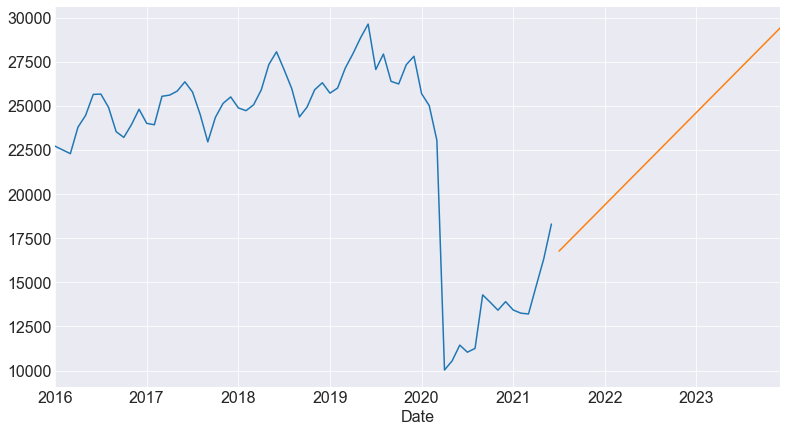

In [88]:
model = Holt(train, exponential = False)
model = model.fit(smoothing_level = 0, 
                  smoothing_trend = 0,
                  optimized = True)
holts = model.predict(start = future_index[0], end = future_index[-1])
s_motion.plot()
holts.plot()

In [89]:
# get values that indicate recovery
s_motion['2019']

Date
2019-01-01    25720
2019-02-01    26010
2019-03-01    27136
2019-04-01    27948
2019-05-01    28849
2019-06-01    29634
2019-07-01    27059
2019-08-01    27935
2019-09-01    26389
2019-10-01    26241
2019-11-01    27336
2019-12-01    27810
Name: Total Employment, dtype: int64

In [90]:
holts

2021-07-01    16769.379907
2021-08-01    17206.043968
2021-09-01    17642.708030
2021-10-01    18079.372091
2021-11-01    18516.036153
2021-12-01    18952.700214
2022-01-01    19389.364275
2022-02-01    19826.028337
2022-03-01    20262.692398
2022-04-01    20699.356460
2022-05-01    21136.020521
2022-06-01    21572.684582
2022-07-01    22009.348644
2022-08-01    22446.012705
2022-09-01    22882.676767
2022-10-01    23319.340828
2022-11-01    23756.004889
2022-12-01    24192.668951
2023-01-01    24629.333012
2023-02-01    25065.997074
2023-03-01    25502.661135
2023-04-01    25939.325196
2023-05-01    26375.989258
2023-06-01    26812.653319
2023-07-01    27249.317381
2023-08-01    27685.981442
2023-09-01    28122.645503
2023-10-01    28559.309565
2023-11-01    28995.973626
2023-12-01    29432.637688
Freq: MS, dtype: float64

**Recovery date is 2023-07**

In [91]:
# redefine future index based on when recovery occured
future_index_str = [
    '2021-07',
    '2021-08',
    '2021-09',
    '2021-10',
    '2021-11', 
    '2021-12', 
    '2022-01', 
    '2022-02', 
    '2022-03',
    '2022-04',
    '2022-05',
    '2022-06',
    '2022-07',
    '2022-08',
    '2022-09',
    '2022-10',
    '2022-11', 
    '2022-12', 
    '2023-01', 
    '2023-02', 
    '2023-03',
    '2023-04',
    '2023-05',
    '2023-06',
    '2023-07',
    ]

future_index = pd.to_datetime(future_index_str)

len(future_index)

25

In [92]:
train

Date
2020-04-01    10034
2020-05-01    10553
2020-06-01    11444
2020-07-01    11043
2020-08-01    11258
2020-09-01    14291
2020-10-01    13866
2020-11-01    13424
2020-12-01    13907
2021-01-01    13433
2021-02-01    13254
2021-03-01    13211
2021-04-01    14784
2021-05-01    16336
2021-06-01    18303
Name: Total Employment, dtype: int64

<AxesSubplot:xlabel='Date'>

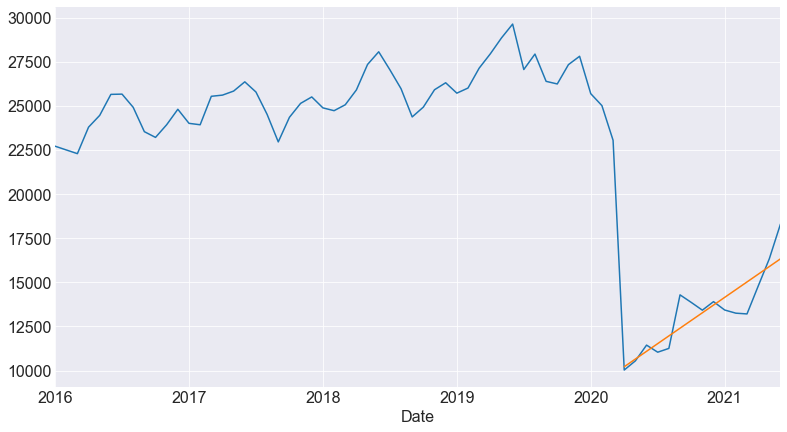

In [93]:
# make predictions to check fit
holts = model.predict(start = train.index[0], end = train.index[-1])
s_motion.plot()
holts.plot()

In [94]:
explained_variance_score(s_motion['2020-04' :], holts)

0.7729021100264022

In [95]:
mean_squared_error(s_motion['2020-04' :], holts, squared=False)

1022.6460898477369

<AxesSubplot:xlabel='Date'>

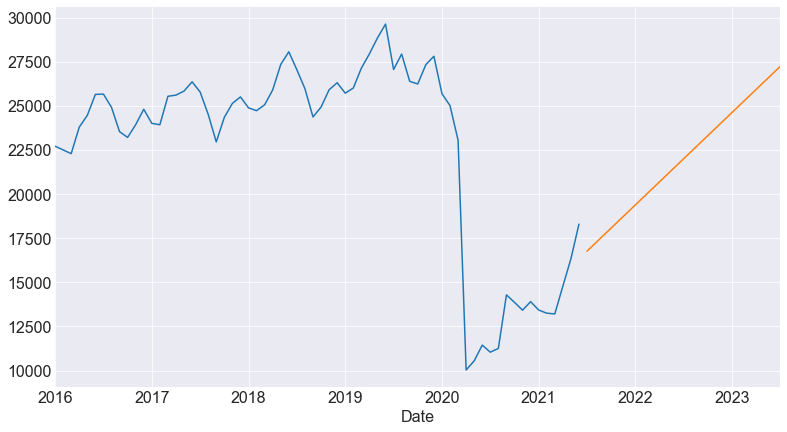

In [96]:
# make adjusted predictions
holts = model.predict(start = future_index[0], end = future_index[-1])
s_motion.plot()
holts.plot()

##### Last normal season 

In [97]:
# now resume previous behavior?

##### Splits

In [98]:
train = s_motion['2016' : '2018']
test = s_motion['2019']

##### Forecast

In [99]:
forecast = train['2018'] + train.diff(12).mean()
forecast.index = test.index

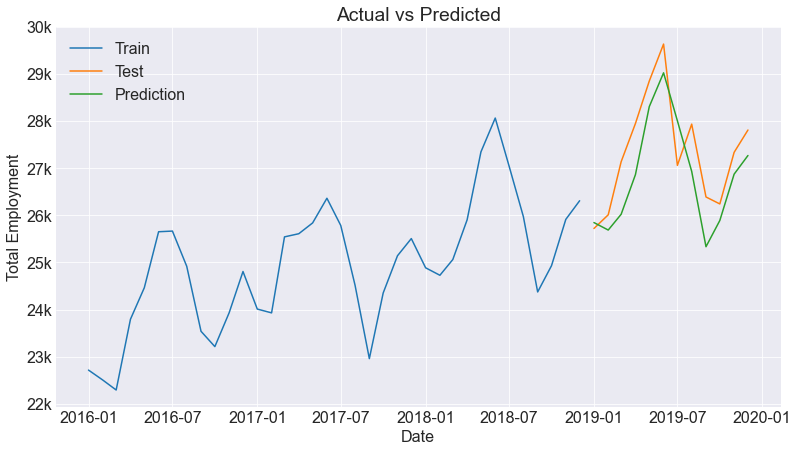

In [100]:
plt.plot(train, label='Train')
#plt.plot(validate, label='Validate')
plt.plot(test, label='Test')
plt.xlabel('Date')
plt.ylabel('Total Employment')
plt.plot(forecast, label = 'Prediction')
plt.title('Actual vs Predicted')
plt.legend()
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000))
plt.show()

In [101]:
# get RMSE
mean_squared_error(test, forecast, squared=False)

755.7787110453997

In [102]:
# get R^2
explained_variance_score(test, forecast)

0.7461388782842269

In [103]:
# predict the future
# want to predict into future to get us to end of year 2023
# get values for respective months preceding pandemic 2018-11 to 2019-12
historical = s_motion['2018-08' : '2019-12']

In [104]:
# get index for seasonal prediction
future_index_str = [
    '2023-08',
    '2023-09',
    '2023-10',
    '2023-11', 
    '2023-12', 
    '2024-01', 
    '2024-02', 
    '2024-03',
    '2024-04',
    '2024-05',
    '2024-06',
    '2024-07',
    '2024-08',
    '2024-09',
    '2024-10',
    '2024-11',
    '2024-12'
    ]

future_index = pd.to_datetime(future_index_str)

In [105]:
future = historical + train.diff(12).mean()
# still need to reset the index
future.index = future_index

<AxesSubplot:xlabel='Date'>

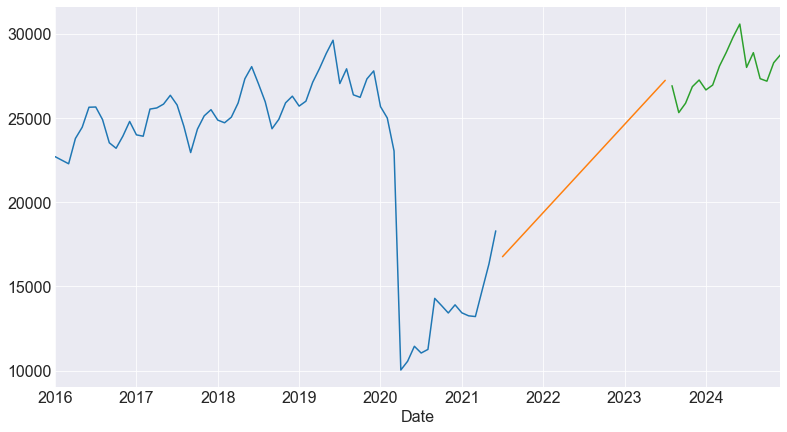

In [106]:
s_motion.plot()
holts.plot()
future.plot()

##### Final Plot

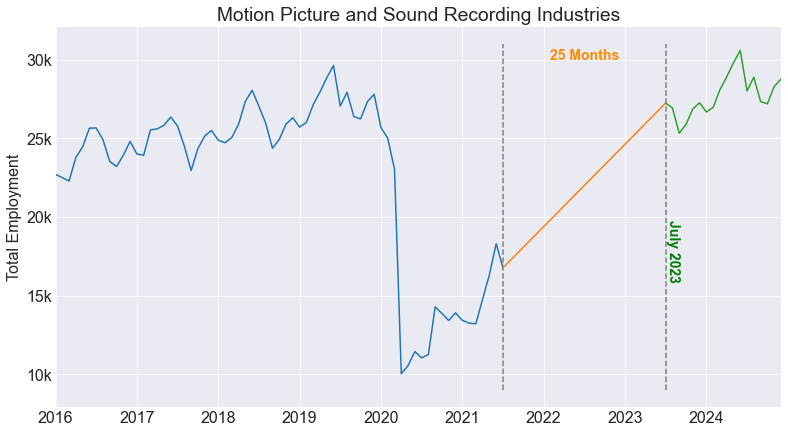

In [107]:
full_forecast = pd.concat([s_motion, holts, future])
full_forecast[ : '2021-07'].plot() # data we have
full_forecast['2021-07' : '2023-07'].plot() # linear recovery forecast
full_forecast['2023-07' : ].plot() # resumption forecast
plt.vlines(x='2021-07', ymin=9_000, ymax=31_000, linestyles='--', colors='gray')
plt.vlines(x='2023-07', ymin=9_000, ymax=31_000, linestyles='--', colors='gray')
plt.text('2022-02', 30_000, '25 Months', fontsize=14, color='darkorange', fontweight='bold')
plt.text('2023-07', 16_000, 'July 2023', fontsize=14, color='green', fontweight='bold', rotation='-90')
plt.gca().set(title='Motion Picture and Sound Recording Industries', 
              ylabel='Total Employment')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

----
####  Performing Arts, Spectator Sports, and Related Industries

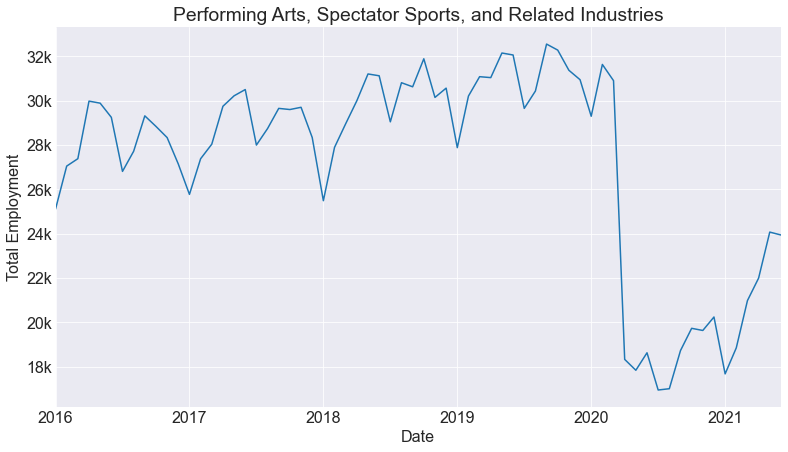

In [108]:
# forecast pre-COVID behavior after full recovery for Sporting Goods industry
s_perform = forecast_ind_dict['Performing Arts, Spectator Sports, and Related Industries']
s_perform.plot()
plt.gca().set(ylabel = 'Total Employment', title='Performing Arts, Spectator Sports, and Related Industries')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

##### Holt's Linear Trend

In [109]:
# find min value where employment bottomed out and recovery started
s_perform[s_perform == s_perform.min()]

Date
2020-07-01    16953
Name: Total Employment, dtype: int64

In [110]:
# define train set for this model
train = s_perform['2020-07' : ]
train

Date
2020-07-01    16953
2020-08-01    17011
2020-09-01    18730
2020-10-01    19734
2020-11-01    19637
2020-12-01    20244
2021-01-01    17679
2021-02-01    18854
2021-03-01    20984
2021-04-01    21998
2021-05-01    24072
2021-06-01    23941
Name: Total Employment, dtype: int64

In [111]:
# define future index for this model
# want to get index that goes from July 2021 to Dec 2022
# after we find recovery date, we will trim index accordingly

future_index_str = [
    '2021-07',
    '2021-08',
    '2021-09',
    '2021-10',
    '2021-11', 
    '2021-12', 
    '2022-01', 
    '2022-02', 
    '2022-03',
    '2022-04',
    '2022-05',
    '2022-06',
    '2022-07',
    '2022-08',
    '2022-09',
    '2022-10',
    '2022-11',
    '2022-12',
    ]

future_index = pd.to_datetime(future_index_str)

future_index

DatetimeIndex(['2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01',
               '2021-11-01', '2021-12-01', '2022-01-01', '2022-02-01',
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01',
               '2022-11-01', '2022-12-01'],
              dtype='datetime64[ns]', freq=None)

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<AxesSubplot:xlabel='Date'>

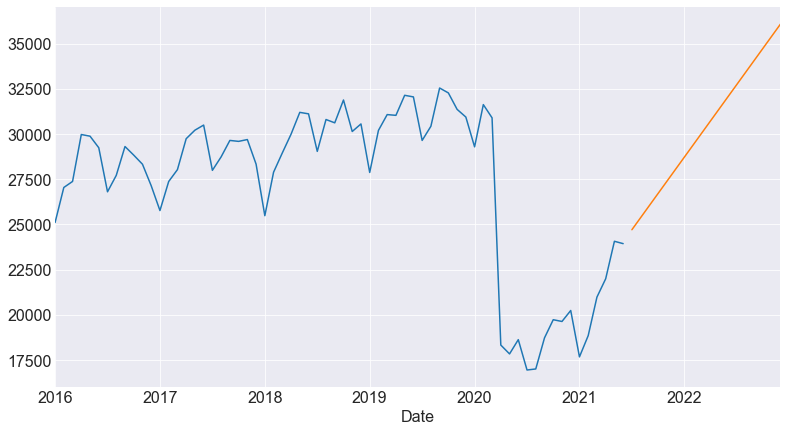

In [112]:
model = Holt(train)
model = model.fit()
holts = model.predict(start = future_index[0], end = future_index[-1])
s_perform.plot()
holts.plot()

In [113]:
# get values that indicate recovery
s_perform['2019']

Date
2019-01-01    27878
2019-02-01    30204
2019-03-01    31078
2019-04-01    31036
2019-05-01    32145
2019-06-01    32056
2019-07-01    29649
2019-08-01    30431
2019-09-01    32548
2019-10-01    32276
2019-11-01    31367
2019-12-01    30942
Name: Total Employment, dtype: int64

In [114]:
holts

2021-07-01    24711.080393
2021-08-01    25380.058068
2021-09-01    26049.035743
2021-10-01    26718.013417
2021-11-01    27386.991092
2021-12-01    28055.968767
2022-01-01    28724.946442
2022-02-01    29393.924117
2022-03-01    30062.901791
2022-04-01    30731.879466
2022-05-01    31400.857141
2022-06-01    32069.834816
2022-07-01    32738.812491
2022-08-01    33407.790166
2022-09-01    34076.767840
2022-10-01    34745.745515
2022-11-01    35414.723190
2022-12-01    36083.700865
Freq: MS, dtype: float64

**Recovery date is 2022-06**

In [115]:
# redefine future index based on when recovery occured
future_index_str = [
    '2021-07',
    '2021-08',
    '2021-09',
    '2021-10',
    '2021-11', 
    '2021-12', 
    '2022-01', 
    '2022-02', 
    '2022-03',
    '2022-04',
    '2022-05',
    '2022-06',
    ]

future_index = pd.to_datetime(future_index_str)

future_index

DatetimeIndex(['2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01',
               '2021-11-01', '2021-12-01', '2022-01-01', '2022-02-01',
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01'],
              dtype='datetime64[ns]', freq=None)

<AxesSubplot:xlabel='Date'>

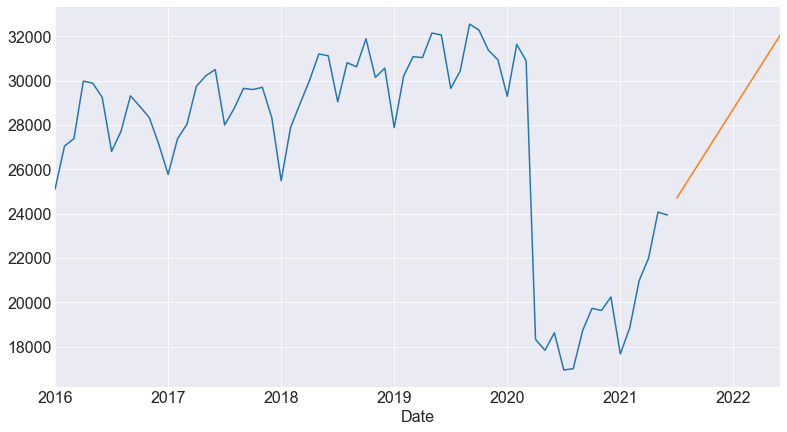

In [116]:
# make adjusted predictions
holts = model.predict(start = future_index[0], end = future_index[-1])
s_perform.plot()
holts.plot()

##### Last normal season 

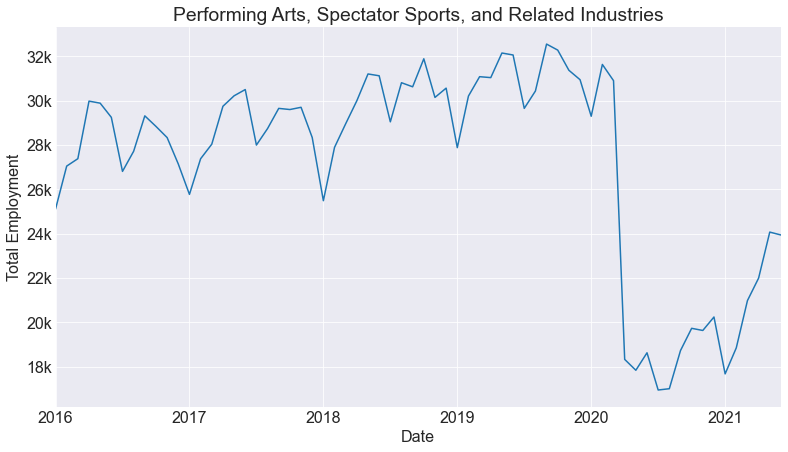

In [117]:
# forecast pre-COVID behavior after full recovery
s_perform = forecast_ind_dict['Performing Arts, Spectator Sports, and Related Industries']
s_perform.plot()
plt.gca().set(ylabel = 'Total Employment', title='Performing Arts, Spectator Sports, and Related Industries')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

##### Splits

In [118]:
train = s_perform['2016' : '2018']
test = s_perform['2019']

In [119]:
# create a function to visualize splits
def viz_splits(train, test):
    ax = train.plot(label='train')
    test.plot(ax=ax, label='test')
    plt.legend()
    plt.title('Visualizing Splits')
    plt.ylabel('Total Employment')
    ax.yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000))
    plt.show();

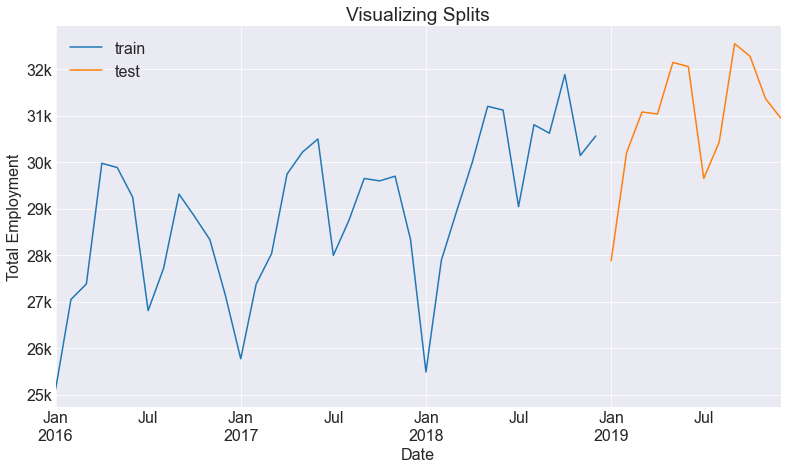

In [120]:
viz_splits(train, test)

##### Seasonal Decomp 

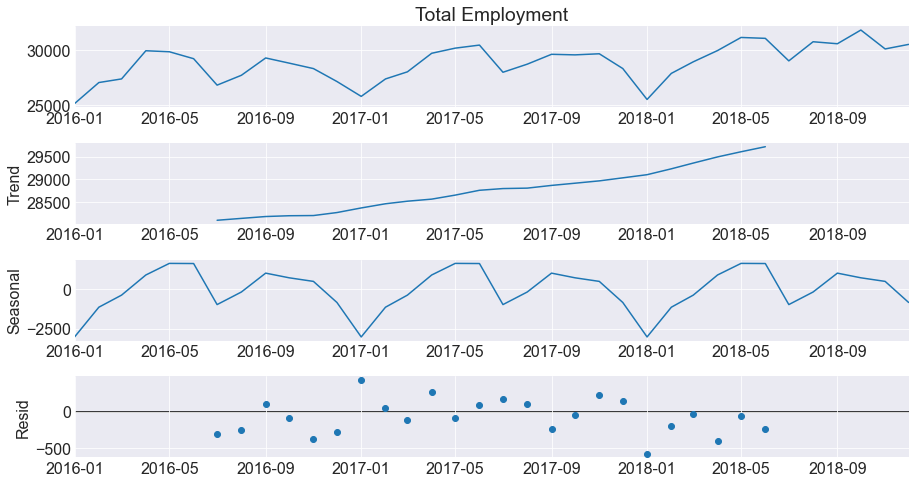

In [121]:
_ = sm.tsa.seasonal_decompose(train).plot()

##### Forecast and Test

In [122]:
forecast = train['2016'] + 3*(train.diff(12).mean())
forecast.index = test.index

In [123]:
train.diff(12).mean()

871.75

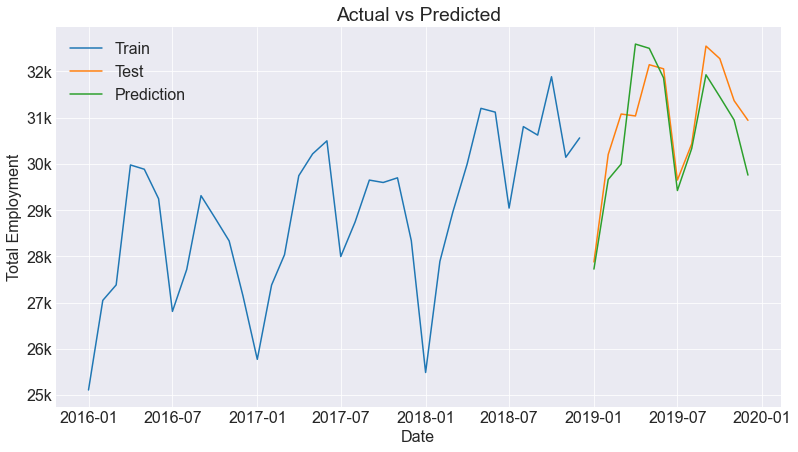

In [124]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.xlabel('Date')
plt.ylabel('Total Employment')
plt.plot(forecast, label = 'Prediction')
plt.title('Actual vs Predicted')
plt.legend()
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000))
plt.show()

In [125]:
# get RMSE
mean_squared_error(test, forecast, squared=False)

751.4251875602787

In [126]:
# get R^2
explained_variance_score(test, forecast)

0.697056465451893

##### Predict Future

In [127]:
# predict the future
# want to predict into future to get us to end of year 2023
# get values for respective months preceding pandemic 2018-11 to 2019-12
historical = s_perform['2018-07' : '2019-12']

In [128]:
# want to get index that goes from July 2021 to Dec 2022

future_index_str = [
    '2022-07', 
    '2022-08',
    '2022-09', 
    '2022-10',
    '2022-11', 
    '2022-12', 
    '2023-01', 
    '2023-02', 
    '2023-03',
    '2023-04',
    '2023-05',
    '2023-06',
    '2023-07',
    '2023-08',
    '2023-09',
    '2023-10',
    '2023-11',
    '2023-12'
    ]

future_index = pd.to_datetime(future_index_str)

future_index

DatetimeIndex(['2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01',
               '2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01',
               '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01',
               '2023-07-01', '2023-08-01', '2023-09-01', '2023-10-01',
               '2023-11-01', '2023-12-01'],
              dtype='datetime64[ns]', freq=None)

In [129]:
future = historical + train.diff(12).mean()
# still need to reset the index
future.index = future_index

<AxesSubplot:xlabel='Date'>

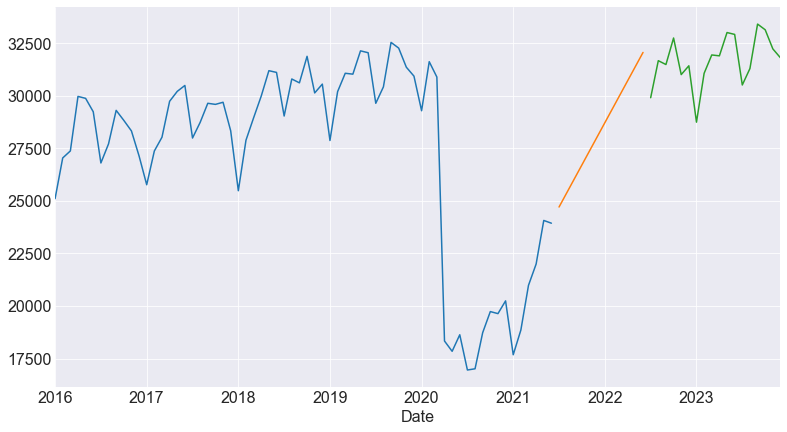

In [130]:
s_perform.plot()
holts.plot()
future.plot()

##### Final Plot

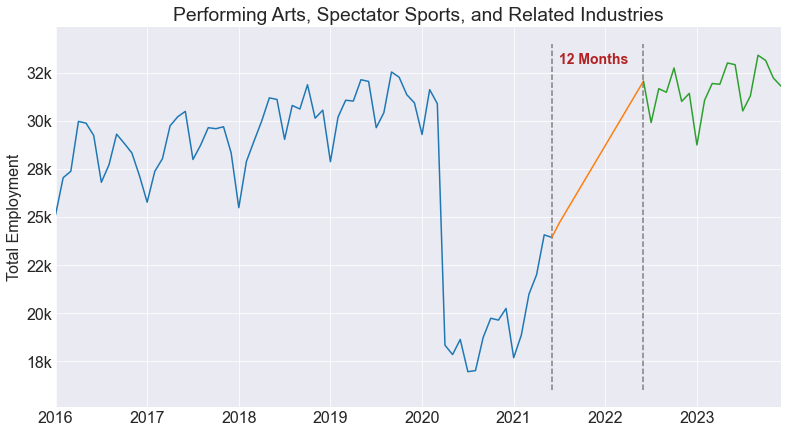

In [131]:
full_forecast = pd.concat([s_perform, holts, future])
full_forecast[ : '2021-06'].plot() # data we have
full_forecast['2021-06' : '2022-06'].plot() # linear recovery forecast
full_forecast['2022-06' : ].plot() # resumption forecast
plt.vlines(x='2021-06', ymin=16_000, ymax=34_000, linestyles='--', colors='gray')
plt.vlines(x='2022-06', ymin=16_000, ymax=34_000, linestyles='--', colors='gray')
plt.text('2021-07', 33_000, '12 Months', fontsize=14, color='firebrick', fontweight='bold')
plt.gca().set(title='Performing Arts, Spectator Sports, and Related Industries', 
              ylabel='Total Employment')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

---
##### Holt's Linear Trend (no smoothing)

In [132]:
s_perform[s_perform == s_perform.min()]

Date
2020-07-01    16953
Name: Total Employment, dtype: int64

In [133]:
# define train set for this model
train = s_perform['2020-07' : ]
train

Date
2020-07-01    16953
2020-08-01    17011
2020-09-01    18730
2020-10-01    19734
2020-11-01    19637
2020-12-01    20244
2021-01-01    17679
2021-02-01    18854
2021-03-01    20984
2021-04-01    21998
2021-05-01    24072
2021-06-01    23941
Name: Total Employment, dtype: int64

In [134]:
# define future index for this model
future_index_str = [
    '2021-07',
    '2021-08',
    '2021-09',
    '2021-10',
    '2021-11', 
    '2021-12', 
    '2022-01', 
    '2022-02', 
    '2022-03',
    '2022-04',
    '2022-05',
    '2022-06',
    '2022-07',
    '2022-08',
    '2022-09',
    '2022-10',
    '2022-11',
    '2022-12',
    '2023-01', 
    '2023-02', 
    '2023-03',
    '2023-04',
    '2023-05',
    '2023-06',
    '2023-07',
    '2023-08',
    '2023-09',
    '2023-10',
    '2023-11',
    '2023-12'
    ]

future_index = pd.to_datetime(future_index_str)

In [135]:
model = Holt(train, exponential = False)
model = model.fit(smoothing_level = 0, 
                  smoothing_trend = 0,
                  optimized = True)

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<AxesSubplot:xlabel='Date'>

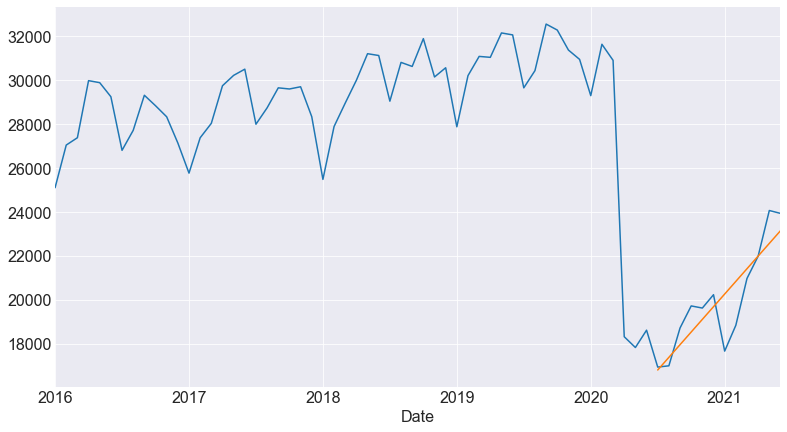

In [136]:
holts = model.predict(start = train.index[0], end = train.index[-1])
s_perform.plot()
holts.plot()

In [137]:
explained_variance_score(train, holts)

0.7419217356829809

In [138]:
mean_squared_error(train, holts, squared=False)

1171.9642664110538

<AxesSubplot:xlabel='Date'>

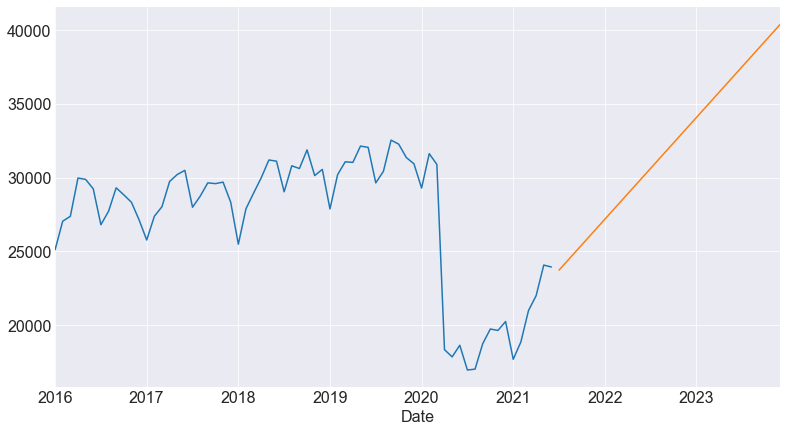

In [139]:
holts = model.predict(start = future_index[0], end = future_index[-1])
s_perform.plot()
holts.plot()

In [140]:
# get values that indicate recovery
s_perform['2019']

Date
2019-01-01    27878
2019-02-01    30204
2019-03-01    31078
2019-04-01    31036
2019-05-01    32145
2019-06-01    32056
2019-07-01    29649
2019-08-01    30431
2019-09-01    32548
2019-10-01    32276
2019-11-01    31367
2019-12-01    30942
Name: Total Employment, dtype: int64

In [141]:
holts

2021-07-01    23727.984830
2021-08-01    24303.610726
2021-09-01    24879.236623
2021-10-01    25454.862519
2021-11-01    26030.488416
2021-12-01    26606.114312
2022-01-01    27181.740209
2022-02-01    27757.366105
2022-03-01    28332.992002
2022-04-01    28908.617899
2022-05-01    29484.243795
2022-06-01    30059.869692
2022-07-01    30635.495588
2022-08-01    31211.121485
2022-09-01    31786.747381
2022-10-01    32362.373278
2022-11-01    32937.999174
2022-12-01    33513.625071
2023-01-01    34089.250968
2023-02-01    34664.876864
2023-03-01    35240.502761
2023-04-01    35816.128657
2023-05-01    36391.754554
2023-06-01    36967.380450
2023-07-01    37543.006347
2023-08-01    38118.632243
2023-09-01    38694.258140
2023-10-01    39269.884037
2023-11-01    39845.509933
2023-12-01    40421.135830
Freq: MS, dtype: float64

**Recovery date is 2022-10**

In [142]:
# redefine future index based on when recovery occured
future_index_str = [
    '2021-07',
    '2021-08',
    '2021-09',
    '2021-10',
    '2021-11', 
    '2021-12', 
    '2022-01', 
    '2022-02', 
    '2022-03',
    '2022-04',
    '2022-05',
    '2022-06',
    '2022-07',
    '2022-08',
    '2022-09',
    '2022-10'
    ]

future_index = pd.to_datetime(future_index_str)

len(future_index)

16

<AxesSubplot:xlabel='Date'>

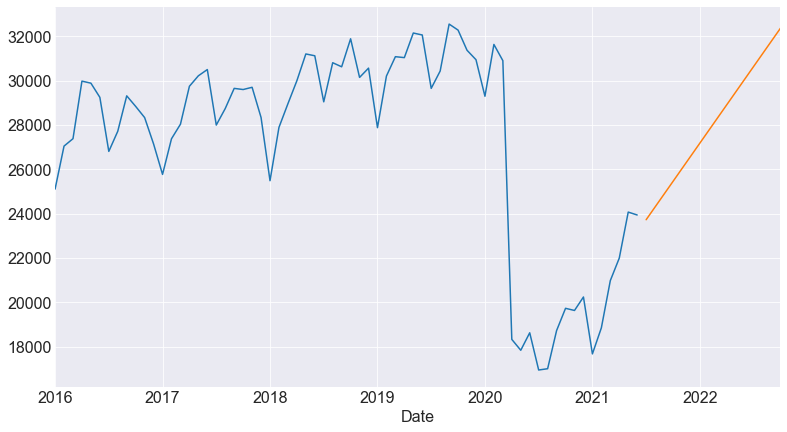

In [143]:
holts = model.predict(start = future_index[0], end = future_index[-1])
s_perform.plot()
holts.plot()

##### Last normal season 

In [144]:
# now resume previous behavior?

##### Splits

In [145]:
train = s_perform['2016' : '2018']
test = s_perform['2019']

##### Forecast

In [146]:
forecast = train['2018'] + train.diff(12).mean()
forecast.index = test.index

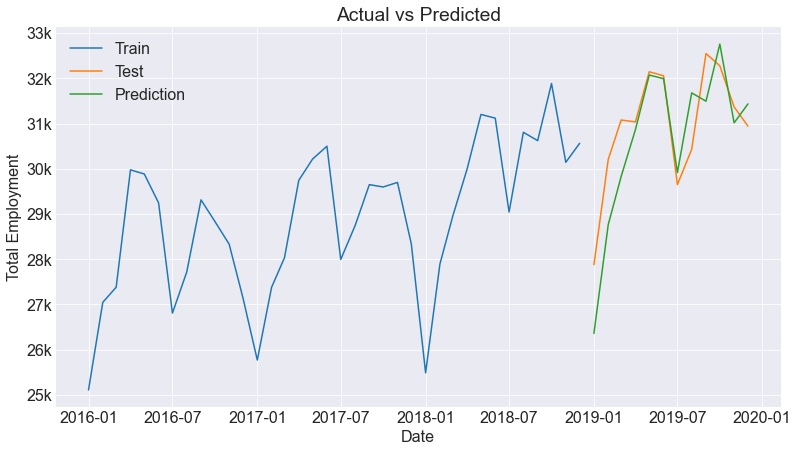

In [147]:
plt.plot(train, label='Train')
#plt.plot(validate, label='Validate')
plt.plot(test, label='Test')
plt.xlabel('Date')
plt.ylabel('Total Employment')
plt.plot(forecast, label = 'Prediction')
plt.title('Actual vs Predicted')
plt.legend()
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000))
plt.show()

In [148]:
# get RMSE
mean_squared_error(test, forecast, squared=False)

881.1867353177759

In [149]:
# get R^2
explained_variance_score(test, forecast)

0.5640463943798542

In [150]:
# predict the future
# want to predict into future to get us to end of year 2023
# get values for respective months preceding pandemic 2018-11 to 2019-12
historical = s_perform['2018-11' : '2019-12']

In [151]:
# get index for seasonal prediction
future_index_str = [
    '2022-11', 
    '2022-12', 
    '2023-01', 
    '2023-02', 
    '2023-03',
    '2023-04',
    '2023-05',
    '2023-06',
    '2023-07',
    '2023-08',
    '2023-09',
    '2023-10',
    '2023-11',
    '2023-12'
    ]

future_index = pd.to_datetime(future_index_str)

In [152]:
future = historical + train.diff(12).mean()
# still need to reset the index
future.index = future_index

<AxesSubplot:xlabel='Date'>

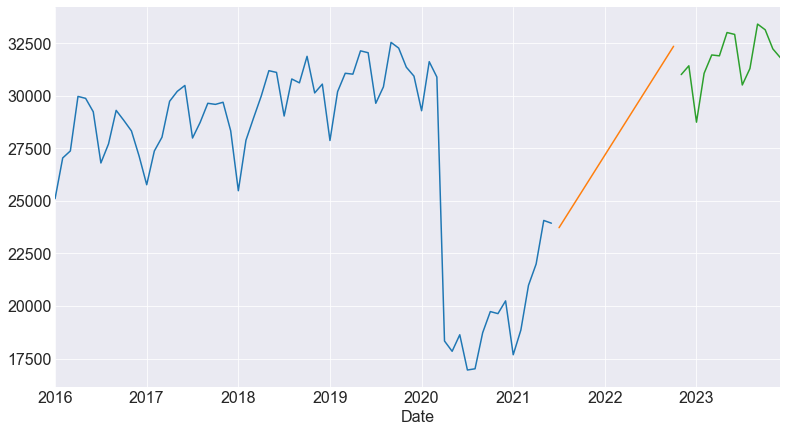

In [153]:
s_perform.plot()
holts.plot()
future.plot()

##### Final Plot

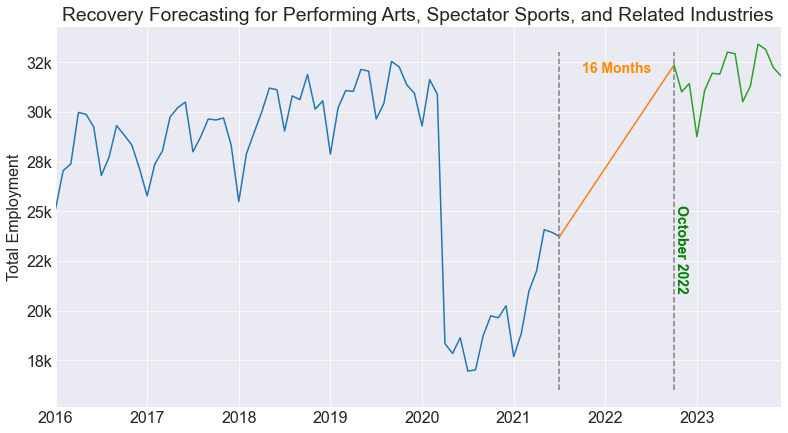

In [154]:
full_forecast = pd.concat([s_perform, holts, future])
full_forecast[ : '2021-07'].plot() # data we have
full_forecast['2021-07' : '2022-10'].plot() # linear recovery forecast
full_forecast['2022-10' : ].plot() # resumption forecast
plt.vlines(x='2021-07', ymin=16_000, ymax=33_000, linestyles='--', colors='gray')
plt.vlines(x='2022-10', ymin=16_000, ymax=33_000, linestyles='--', colors='gray')
plt.text('2021-10', 32_000, '16 Months', fontsize=14, color='darkorange', fontweight='bold')
plt.text('2022-10', 21_000, 'October 2022', fontsize=14, color='green', fontweight='bold', rotation='-90')
plt.gca().set(title='Recovery Forecasting for Performing Arts, Spectator Sports, and Related Industries', 
              ylabel='Total Employment')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

----
####  Accommodation

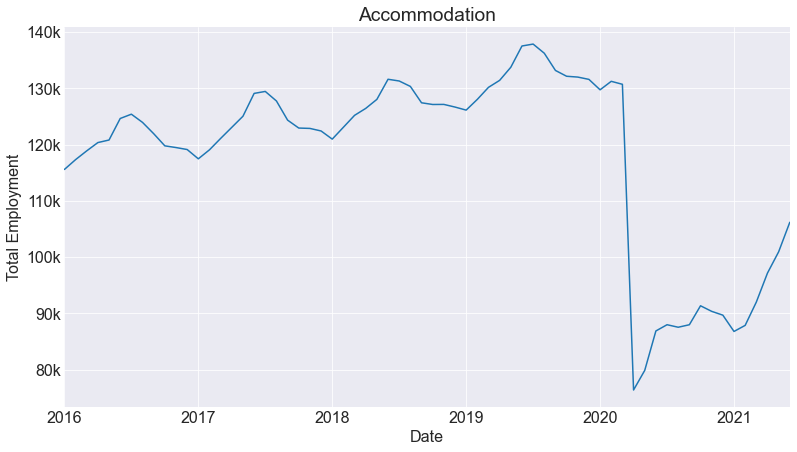

In [155]:
# forecast pre-COVID behavior after full recovery for Sporting Goods industry
s_accom = forecast_ind_dict['Accommodation']
s_accom.plot()
plt.gca().set(ylabel = 'Total Employment', title='Accommodation')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

---
##### Holt's Linear Trend (no smoothing)

In [156]:
s_accom[s_accom == s_accom.min()]

Date
2020-04-01    76362
Name: Total Employment, dtype: int64

In [157]:
# define train set for this model
train = s_accom['2020-04' : ]
train

Date
2020-04-01     76362
2020-05-01     79845
2020-06-01     86858
2020-07-01     87968
2020-08-01     87520
2020-09-01     87964
2020-10-01     91336
2020-11-01     90345
2020-12-01     89669
2021-01-01     86772
2021-02-01     87850
2021-03-01     91993
2021-04-01     97152
2021-05-01    100932
2021-06-01    106179
Name: Total Employment, dtype: int64

In [158]:
# define future index for this model, start long, trim later
future_index_str = [
    '2021-07',
    '2021-08',
    '2021-09',
    '2021-10',
    '2021-11', 
    '2021-12', 
    '2022-01', 
    '2022-02', 
    '2022-03',
    '2022-04',
    '2022-05',
    '2022-06',
    '2022-07',
    '2022-08',
    '2022-09',
    '2022-10',
    '2022-11',
    '2022-12',
    '2023-01', 
    '2023-02', 
    '2023-03',
    '2023-04',
    '2023-05',
    '2023-06',
    '2023-07',
    '2023-08',
    '2023-09',
    '2023-10',
    '2023-11',
    '2023-12'
    ]

future_index = pd.to_datetime(future_index_str)

In [159]:
model = Holt(train, exponential = False)
model = model.fit(smoothing_level = 0, 
                  smoothing_trend = 0,
                  optimized = True)

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<AxesSubplot:xlabel='Date'>

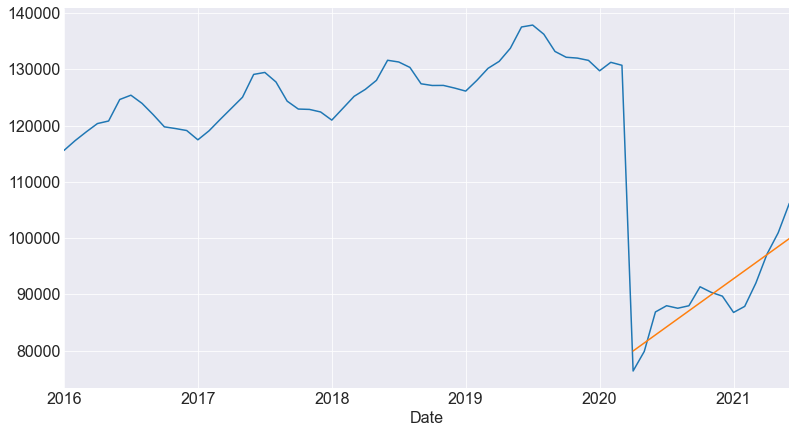

In [160]:
holts = model.predict(start = train.index[0], end = train.index[-1])
s_accom.plot()
holts.plot()

In [161]:
explained_variance_score(train, holts)

0.7443208438615954

In [162]:
mean_squared_error(train, holts, squared=False)

3615.192262427415

<AxesSubplot:xlabel='Date'>

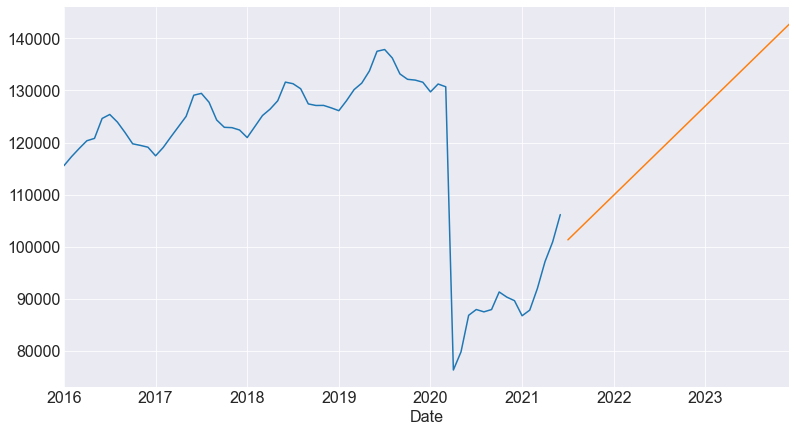

In [163]:
holts = model.predict(start = future_index[0], end = future_index[-1])
s_accom.plot()
holts.plot()

In [164]:
# get values that indicate recovery
s_accom['2019']

Date
2019-01-01    126121
2019-02-01    128028
2019-03-01    130168
2019-04-01    131410
2019-05-01    133739
2019-06-01    137520
2019-07-01    137860
2019-08-01    136233
2019-09-01    133172
2019-10-01    132139
2019-11-01    131993
2019-12-01    131584
Name: Total Employment, dtype: int64

In [165]:
holts

2021-07-01    101337.787927
2021-08-01    102765.471504
2021-09-01    104193.155081
2021-10-01    105620.838658
2021-11-01    107048.522235
2021-12-01    108476.205812
2022-01-01    109903.889388
2022-02-01    111331.572965
2022-03-01    112759.256542
2022-04-01    114186.940119
2022-05-01    115614.623696
2022-06-01    117042.307273
2022-07-01    118469.990849
2022-08-01    119897.674426
2022-09-01    121325.358003
2022-10-01    122753.041580
2022-11-01    124180.725157
2022-12-01    125608.408734
2023-01-01    127036.092310
2023-02-01    128463.775887
2023-03-01    129891.459464
2023-04-01    131319.143041
2023-05-01    132746.826618
2023-06-01    134174.510195
2023-07-01    135602.193772
2023-08-01    137029.877348
2023-09-01    138457.560925
2023-10-01    139885.244502
2023-11-01    141312.928079
2023-12-01    142740.611656
Freq: MS, dtype: float64

**Recovery date is 2023-08**

In [166]:
# redefine future index based on when recovery occured
future_index_str = [
    '2021-07',
    '2021-08',
    '2021-09',
    '2021-10',
    '2021-11', 
    '2021-12', 
    '2022-01', 
    '2022-02', 
    '2022-03',
    '2022-04',
    '2022-05',
    '2022-06',
    '2022-07',
    '2022-08',
    '2022-09',
    '2022-10',
    '2022-11', 
    '2022-12', 
    '2023-01', 
    '2023-02', 
    '2023-03',
    '2023-04',
    '2023-05',
    '2023-06',
    '2023-07',
    '2023-08',
    ]

future_index = pd.to_datetime(future_index_str)

len(future_index)

26

<AxesSubplot:xlabel='Date'>

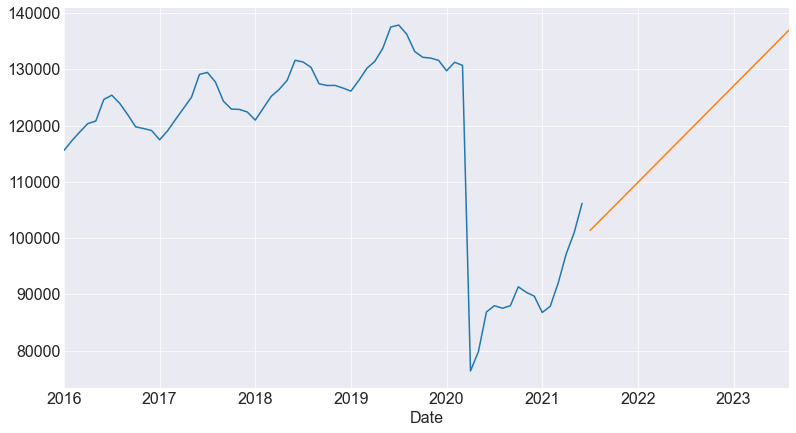

In [167]:
holts = model.predict(start = future_index[0], end = future_index[-1])
s_accom.plot()
holts.plot()

##### Last normal season 

##### Splits

In [168]:
train = s_accom['2016' : '2018']
test = s_accom['2019']

##### Forecast

In [169]:
forecast = train['2018'] + 2*(train.diff(12).mean())
forecast.index = test.index

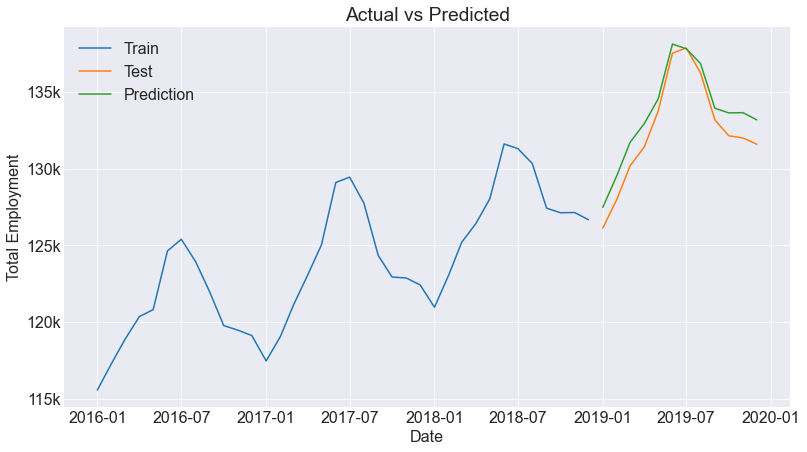

In [170]:
plt.plot(train, label='Train')
#plt.plot(validate, label='Validate')
plt.plot(test, label='Test')
plt.xlabel('Date')
plt.ylabel('Total Employment')
plt.plot(forecast, label = 'Prediction')
plt.title('Actual vs Predicted')
plt.legend()
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000))
plt.show()

In [171]:
# get RMSE
mean_squared_error(test, forecast, squared=False)

1234.7828081623638

In [172]:
# get R^2
explained_variance_score(test, forecast)

0.9757237200256674

In [173]:
# predict the future
# want to predict into future to get us to end of year 2023
# get values for respective months preceding pandemic 2018-11 to 2019-12
historical = s_accom['2018-09' : '2019-12']

In [174]:
# get index for seasonal prediction
future_index_str = [
    '2023-09',
    '2023-10',
    '2023-11', 
    '2023-12', 
    '2024-01', 
    '2024-02', 
    '2024-03',
    '2024-04',
    '2024-05',
    '2024-06',
    '2024-07',
    '2024-08',
    '2024-09',
    '2024-10',
    '2024-11',
    '2024-12'
    ]

future_index = pd.to_datetime(future_index_str)

In [175]:
future = historical + 2*(train.diff(12).mean())
# still need to reset the index
future.index = future_index

<AxesSubplot:xlabel='Date'>

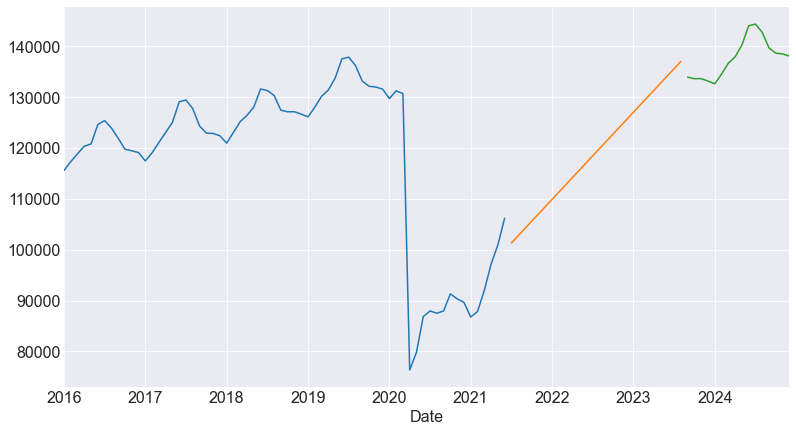

In [176]:
s_accom.plot()
holts.plot()
future.plot()

##### Final Plot

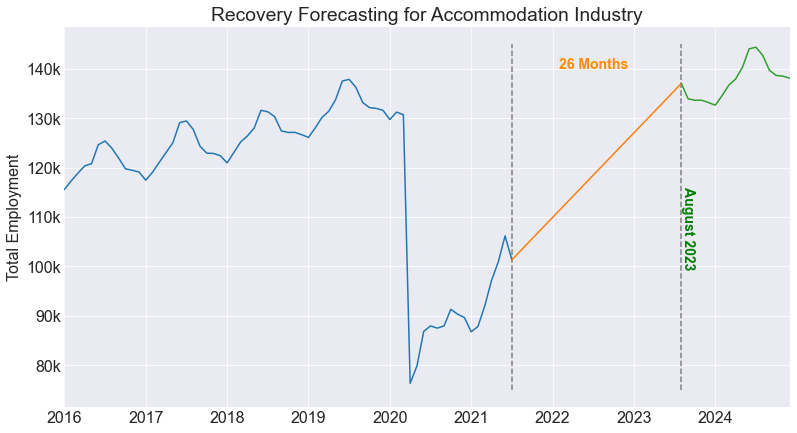

In [177]:
full_forecast = pd.concat([s_accom, holts, future])
full_forecast[ : '2021-07'].plot() # data we have
full_forecast['2021-07' : '2023-08'].plot() # linear recovery forecast
full_forecast['2023-08' : ].plot() # resumption forecast
plt.vlines(x='2021-07', ymin=75_000, ymax=145_000, linestyles='--', colors='gray')
plt.vlines(x='2023-08', ymin=75_000, ymax=145_000, linestyles='--', colors='gray', label='Aug 2023')
plt.text('2022-02', 140_000, '26 Months', fontsize=14, color='darkorange', fontweight='bold')
plt.text('2023-08', 100_000, 'August 2023', fontsize=14, color='green', fontweight='bold', rotation='-90')
plt.gca().set (title='Recovery Forecasting for Accommodation Industry', ylabel='Total Employment')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

----
####  Clothing and Clothing Accessories Stores

In [178]:
char_df

recovery
Motion Picture and Sound Recording Industries        61.763515
Performing Arts, Spectator Sports, and Related ...   74.684926
Accommodation                                        77.209860
Clothing and Clothing Accessories Stores             81.494898
Scenic and Sightseeing Transportation                88.888889
Amusement, Gambling, and Recreation Industries       89.903270
Personal and Laundry Services                        93.778813
Miscellaneous Store Retailers                        95.706924
Furniture and Home Furnishings Stores                95.801793
Food Services and Drinking Places                    95.909662
Leather and Allied Product Manufacturing             96.645046
Sporting Goods, Hobby, Musical Instrument, and ...  102.360633

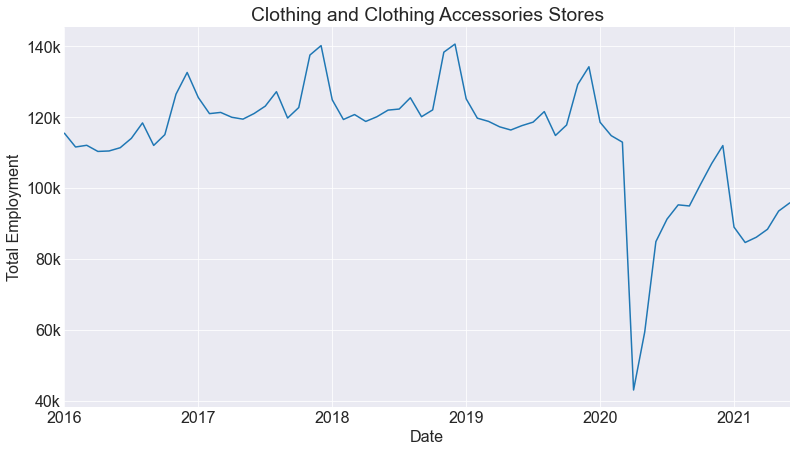

In [179]:
# forecast pre-COVID behavior after full recovery for Sporting Goods industry
s_cloth = forecast_ind_dict['Clothing and Clothing Accessories Stores ']
s_cloth.plot()
plt.gca().set(ylabel = 'Total Employment', title='Clothing and Clothing Accessories Stores')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

---
##### Holt's Linear Trend (no smoothing)

In [180]:
s_cloth[s_cloth == s_cloth.min()]

Date
2020-04-01    43098
Name: Total Employment, dtype: int64

In [181]:
# define train set for this model
train = s_cloth['2020-04' : ]
train

Date
2020-04-01     43098
2020-05-01     59448
2020-06-01     84905
2020-07-01     91262
2020-08-01     95270
2020-09-01     94960
2020-10-01    101044
2020-11-01    106909
2020-12-01    111979
2021-01-01     89011
2021-02-01     84663
2021-03-01     86150
2021-04-01     88391
2021-05-01     93523
2021-06-01     95838
Name: Total Employment, dtype: int64

In [182]:
# define future index for this model, start long, trim later
future_index_str = [
    '2021-07',
    '2021-08',
    '2021-09',
    '2021-10',
    '2021-11', 
    '2021-12', 
    '2022-01', 
    '2022-02', 
    '2022-03',
    '2022-04',
    '2022-05',
    '2022-06',
    '2022-07',
    '2022-08',
    '2022-09',
    '2022-10',
    '2022-11',
    '2022-12',
    '2023-01', 
    '2023-02', 
    '2023-03',
    '2023-04',
    '2023-05',
    '2023-06',
    '2023-07',
    '2023-08',
    '2023-09',
    '2023-10',
    '2023-11',
    '2023-12'
    ]

future_index = pd.to_datetime(future_index_str)

In [183]:
model = Holt(train, exponential = False)
model = model.fit(smoothing_level = 0, 
                  smoothing_trend = 0,
                  optimized = True)

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<AxesSubplot:xlabel='Date'>

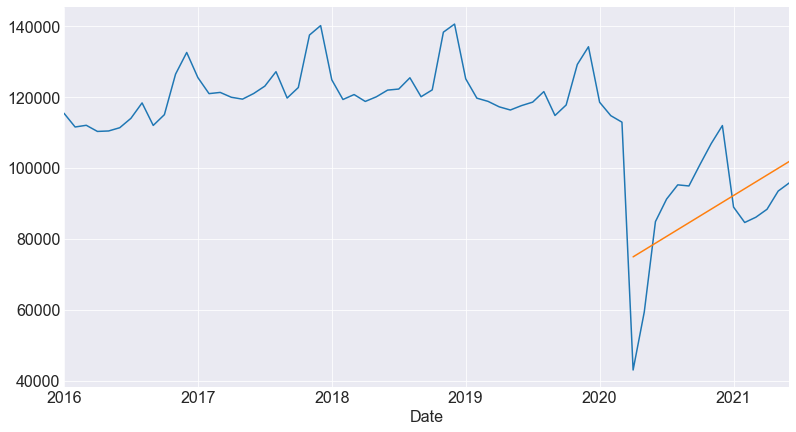

In [184]:
holts = model.predict(start = train.index[0], end = train.index[-1])
s_cloth.plot()
holts.plot()

In [185]:
explained_variance_score(train, holts)

0.24830340070095336

In [186]:
mean_squared_error(train, holts, squared=False)

14439.385783880423

<AxesSubplot:xlabel='Date'>

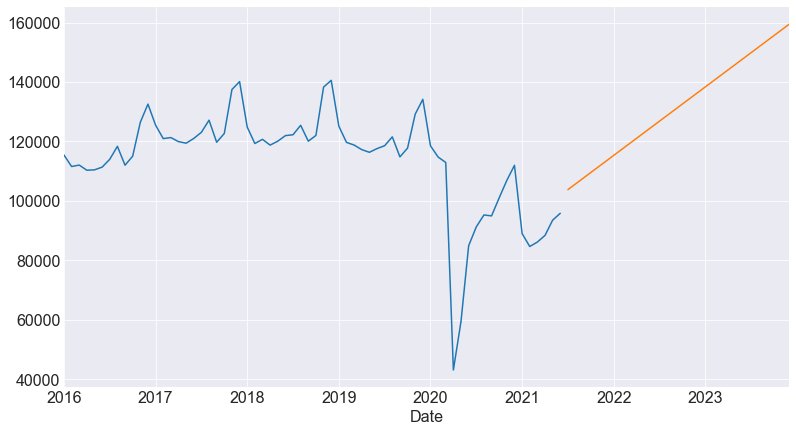

In [187]:
holts = model.predict(start = future_index[0], end = future_index[-1])
s_cloth.plot()
holts.plot()

In [188]:
# get values that indicate recovery
s_cloth['2019']

Date
2019-01-01    125153
2019-02-01    119699
2019-03-01    118795
2019-04-01    117257
2019-05-01    116362
2019-06-01    117600
2019-07-01    118579
2019-08-01    121549
2019-09-01    114817
2019-10-01    117773
2019-11-01    129194
2019-12-01    134186
Name: Total Employment, dtype: int64

In [189]:
holts

2021-07-01    103797.850203
2021-08-01    105718.870128
2021-09-01    107639.890054
2021-10-01    109560.909979
2021-11-01    111481.929905
2021-12-01    113402.949831
2022-01-01    115323.969756
2022-02-01    117244.989682
2022-03-01    119166.009607
2022-04-01    121087.029533
2022-05-01    123008.049459
2022-06-01    124929.069384
2022-07-01    126850.089310
2022-08-01    128771.109235
2022-09-01    130692.129161
2022-10-01    132613.149086
2022-11-01    134534.169012
2022-12-01    136455.188938
2023-01-01    138376.208863
2023-02-01    140297.228789
2023-03-01    142218.248714
2023-04-01    144139.268640
2023-05-01    146060.288566
2023-06-01    147981.308491
2023-07-01    149902.328417
2023-08-01    151823.348342
2023-09-01    153744.368268
2023-10-01    155665.388194
2023-11-01    157586.408119
2023-12-01    159507.428045
Freq: MS, dtype: float64

**Recovery date is 2022-03**

In [190]:
# redefine future index based on when recovery occured
future_index_str = [
    '2021-07',
    '2021-08',
    '2021-09',
    '2021-10',
    '2021-11', 
    '2021-12', 
    '2022-01', 
    '2022-02', 
    '2022-03'
    ]

future_index = pd.to_datetime(future_index_str)

len(future_index)

9

<AxesSubplot:xlabel='Date'>

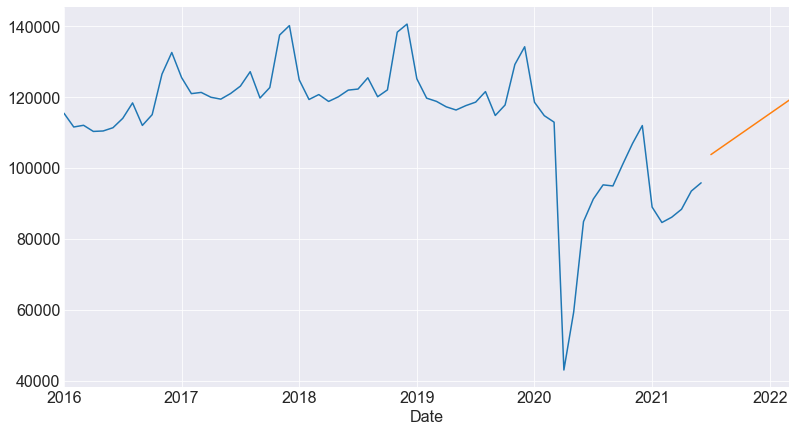

In [191]:
holts = model.predict(start = future_index[0], end = future_index[-1])
s_cloth.plot()
holts.plot()

##### Last normal season 

##### Splits

In [192]:
train = s_cloth['2016' : '2018']
test = s_cloth['2019']

##### Forecast

In [193]:
forecast = train['2018'] + (train.diff(12).mean())
forecast.index = test.index

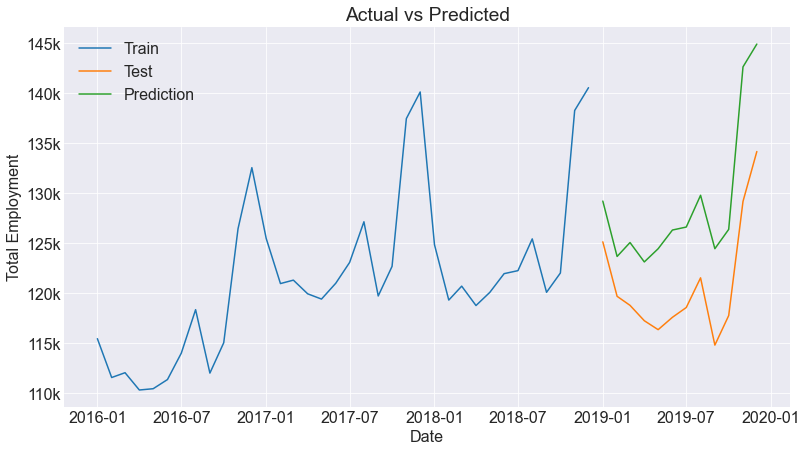

In [194]:
plt.plot(train, label='Train')
#plt.plot(validate, label='Validate')
plt.plot(test, label='Test')
plt.xlabel('Date')
plt.ylabel('Total Employment')
plt.plot(forecast, label = 'Prediction')
plt.title('Actual vs Predicted')
plt.legend()
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000))
plt.show()

In [195]:
# get RMSE
mean_squared_error(test, forecast, squared=False)

8395.442380889366

In [196]:
# get R^2
explained_variance_score(test, forecast)

0.7815896780786884

In [197]:
# predict the future
# want to predict into future to get us to end of year 2023
# get values for respective months preceding pandemic 2018-11 to 2019-12
historical = s_cloth['2018-04' : '2019-12']

In [198]:
# get index for seasonal prediction
future_index_str = [
    '2022-04',
    '2022-05',
    '2022-06',
    '2022-07',
    '2022-08',
    '2022-09',
    '2022-10',
    '2022-11', 
    '2022-12', 
    '2023-01', 
    '2023-02', 
    '2023-03',
    '2023-04',
    '2023-05',
    '2023-06',
    '2023-07',
    '2023-08',
    '2023-09',
    '2023-10',
    '2023-11',
    '2023-12'
    ]

future_index = pd.to_datetime(future_index_str)

In [199]:
future = historical + (train.diff(12).mean())
# still need to reset the index
future.index = future_index

<AxesSubplot:xlabel='Date'>

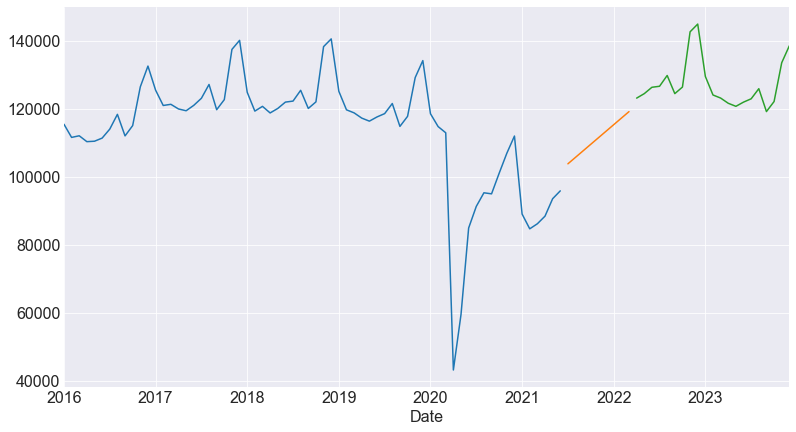

In [200]:
s_cloth.plot()
holts.plot()
future.plot()

##### Final Plot

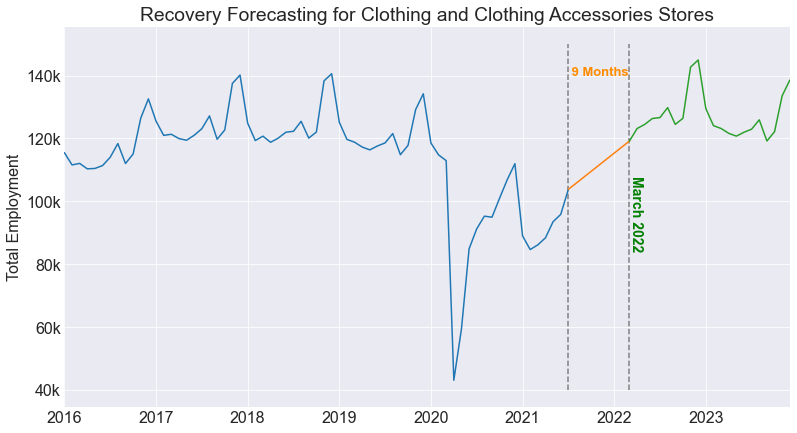

In [201]:
full_forecast = pd.concat([s_cloth, holts, future])
full_forecast[ : '2021-07'].plot() # data we have
full_forecast['2021-07' : '2022-03'].plot() # linear recovery forecast
full_forecast['2022-03' : ].plot() # resumption forecast
plt.vlines(x='2021-07', ymin=40_000, ymax=150_000, linestyles='--', colors='gray')
plt.vlines(x='2022-03', ymin=40_000, ymax=150_000, linestyles='--', colors='gray', label='Aug 2023')
plt.text('2021-07', 140_000, ' 9 Months', fontsize=13, color='darkorange', fontweight='bold')
plt.text('2022-03', 85_000, 'March 2022', fontsize=14, color='green', fontweight='bold', rotation='-90')
plt.gca().set (title='Recovery Forecasting for Clothing and Clothing Accessories Stores', ylabel='Total Employment')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

----
####  Scenic and Sightseeing Transportation

In [202]:
char_df

recovery
Motion Picture and Sound Recording Industries        61.763515
Performing Arts, Spectator Sports, and Related ...   74.684926
Accommodation                                        77.209860
Clothing and Clothing Accessories Stores             81.494898
Scenic and Sightseeing Transportation                88.888889
Amusement, Gambling, and Recreation Industries       89.903270
Personal and Laundry Services                        93.778813
Miscellaneous Store Retailers                        95.706924
Furniture and Home Furnishings Stores                95.801793
Food Services and Drinking Places                    95.909662
Leather and Allied Product Manufacturing             96.645046
Sporting Goods, Hobby, Musical Instrument, and ...  102.360633

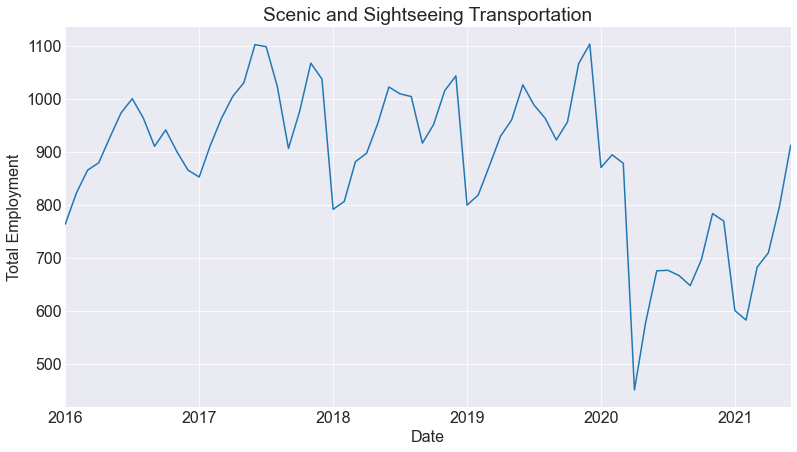

In [203]:
# forecast pre-COVID behavior after full recovery for Sporting Goods industry
s_scene = forecast_ind_dict['Scenic and Sightseeing Transportation']
s_scene.plot()
plt.gca().set(ylabel = 'Total Employment', title='Scenic and Sightseeing Transportation');
# plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

---
##### Holt's Linear Trend (no smoothing)

In [204]:
s_scene[s_scene == s_scene.min()]

Date
2020-04-01    450
Name: Total Employment, dtype: int64

In [205]:
# define train set for this model
train = s_scene['2020-04' : ]
train

Date
2020-04-01    450
2020-05-01    577
2020-06-01    675
2020-07-01    676
2020-08-01    666
2020-09-01    647
2020-10-01    696
2020-11-01    783
2020-12-01    769
2021-01-01    600
2021-02-01    582
2021-03-01    682
2021-04-01    709
2021-05-01    797
2021-06-01    912
Name: Total Employment, dtype: int64

In [206]:
# define future index for this model, start long, trim later
future_index_str = [
    '2021-07',
    '2021-08',
    '2021-09',
    '2021-10',
    '2021-11', 
    '2021-12', 
    '2022-01', 
    '2022-02', 
    '2022-03',
    '2022-04',
    '2022-05',
    '2022-06',
    '2022-07',
    '2022-08',
    '2022-09',
    '2022-10',
    '2022-11',
    '2022-12',
    '2023-01', 
    '2023-02', 
    '2023-03',
    '2023-04',
    '2023-05',
    '2023-06',
    '2023-07',
    '2023-08',
    '2023-09',
    '2023-10',
    '2023-11',
    '2023-12'
    ]

future_index = pd.to_datetime(future_index_str)

In [207]:
model = Holt(train, exponential = False)
model = model.fit(smoothing_level = 0, 
                  smoothing_trend = 0,
                  optimized = True)

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<AxesSubplot:xlabel='Date'>

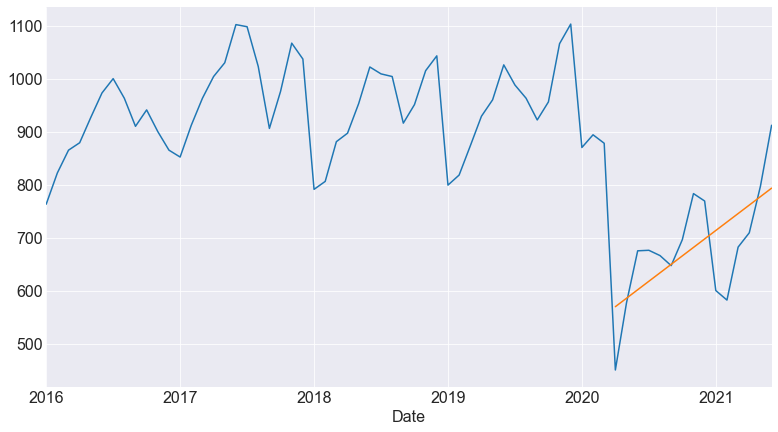

In [208]:
holts = model.predict(start = train.index[0], end = train.index[-1])
s_scene.plot()
holts.plot()

In [209]:
explained_variance_score(train, holts)

0.42583242803755195

In [210]:
mean_squared_error(train, holts, squared=False)

80.18042600467406

<AxesSubplot:xlabel='Date'>

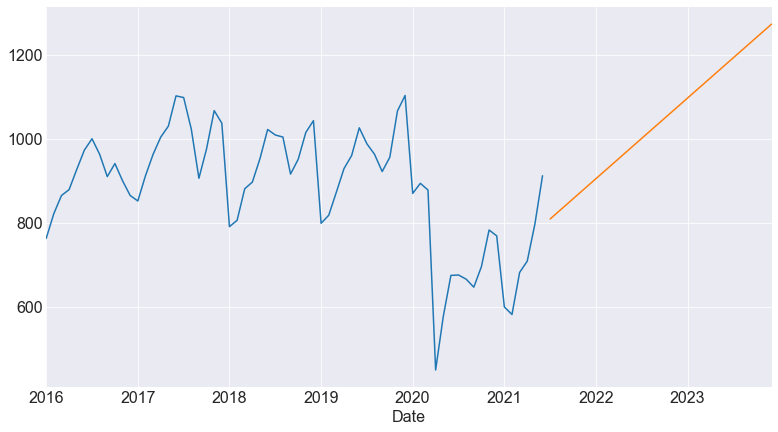

In [211]:
holts = model.predict(start = future_index[0], end = future_index[-1])
s_scene.plot()
holts.plot()

In [212]:
# get values that indicate recovery
s_scene['2019']

Date
2019-01-01     799
2019-02-01     818
2019-03-01     873
2019-04-01     929
2019-05-01     960
2019-06-01    1026
2019-07-01     988
2019-08-01     963
2019-09-01     922
2019-10-01     956
2019-11-01    1066
2019-12-01    1103
Name: Total Employment, dtype: int64

In [213]:
holts

2021-07-01     809.257049
2021-08-01     825.239176
2021-09-01     841.221304
2021-10-01     857.203431
2021-11-01     873.185559
2021-12-01     889.167686
2022-01-01     905.149814
2022-02-01     921.131941
2022-03-01     937.114069
2022-04-01     953.096196
2022-05-01     969.078323
2022-06-01     985.060451
2022-07-01    1001.042578
2022-08-01    1017.024706
2022-09-01    1033.006833
2022-10-01    1048.988961
2022-11-01    1064.971088
2022-12-01    1080.953216
2023-01-01    1096.935343
2023-02-01    1112.917470
2023-03-01    1128.899598
2023-04-01    1144.881725
2023-05-01    1160.863853
2023-06-01    1176.845980
2023-07-01    1192.828108
2023-08-01    1208.810235
2023-09-01    1224.792363
2023-10-01    1240.774490
2023-11-01    1256.756617
2023-12-01    1272.738745
Freq: MS, dtype: float64

**Recovery date is 2022-07**

In [214]:
# redefine future index based on when recovery occured
future_index_str = [
    '2021-07',
    '2021-08',
    '2021-09',
    '2021-10',
    '2021-11', 
    '2021-12', 
    '2022-01', 
    '2022-02', 
    '2022-03',
    '2022-04', 
    '2022-05', 
    '2022-06', 
    '2022-07'
    ]

future_index = pd.to_datetime(future_index_str)

len(future_index)

13

<AxesSubplot:xlabel='Date'>

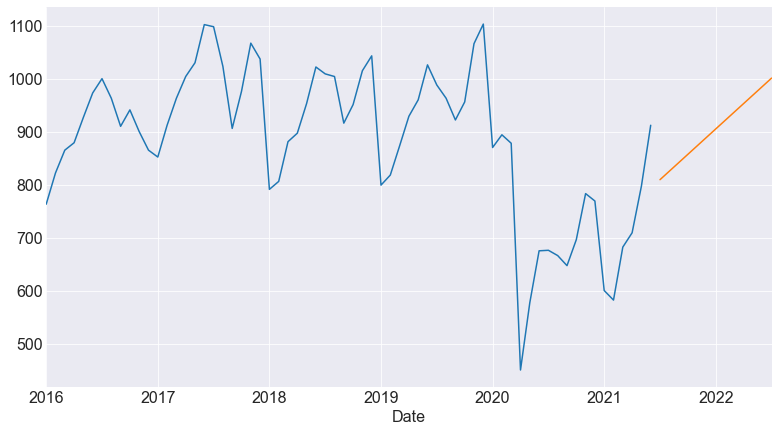

In [215]:
holts = model.predict(start = future_index[0], end = future_index[-1])
s_scene.plot()
holts.plot()

##### Last normal season 

##### Splits

In [216]:
train = s_scene['2016' : '2018']
test = s_scene['2019']

##### Forecast

In [217]:
forecast = train['2018'] + (train.diff(12).mean())
forecast.index = test.index

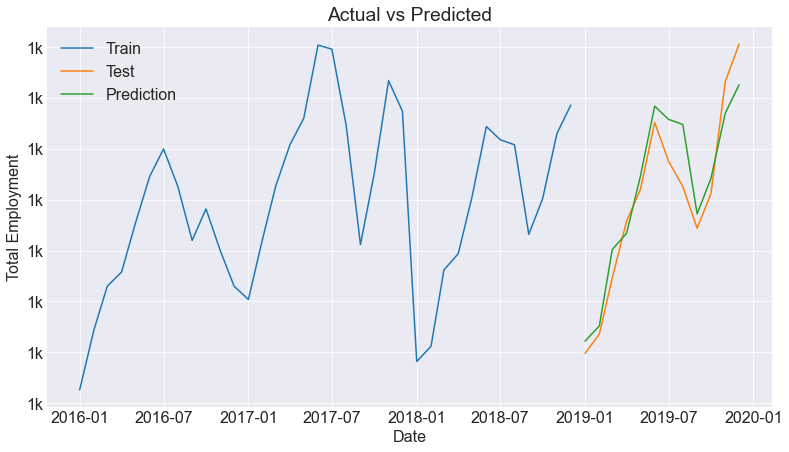

In [218]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.xlabel('Date')
plt.ylabel('Total Employment')
plt.plot(forecast, label = 'Prediction')
plt.title('Actual vs Predicted')
plt.legend()
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000))
plt.show()

In [219]:
# get RMSE
mean_squared_error(test, forecast, squared=False)

28.788018340969565

In [220]:
# get R^2
explained_variance_score(test, forecast)

0.9058180071357287

In [221]:
# predict the future
# want to predict into future to get us to end of year 2023
# get values for respective months preceding pandemic 2018-11 to 2019-12
historical = s_scene['2018-08' : '2019-12']

In [222]:
# get index for seasonal prediction
future_index_str = [
    '2022-08',
    '2022-09',
    '2022-10',
    '2022-11', 
    '2022-12', 
    '2023-01', 
    '2023-02', 
    '2023-03',
    '2023-04',
    '2023-05',
    '2023-06',
    '2023-07',
    '2023-08',
    '2023-09',
    '2023-10',
    '2023-11',
    '2023-12'
    ]

future_index = pd.to_datetime(future_index_str)

In [223]:
future = historical + (train.diff(12).mean())
# still need to reset the index
future.index = future_index

<AxesSubplot:xlabel='Date'>

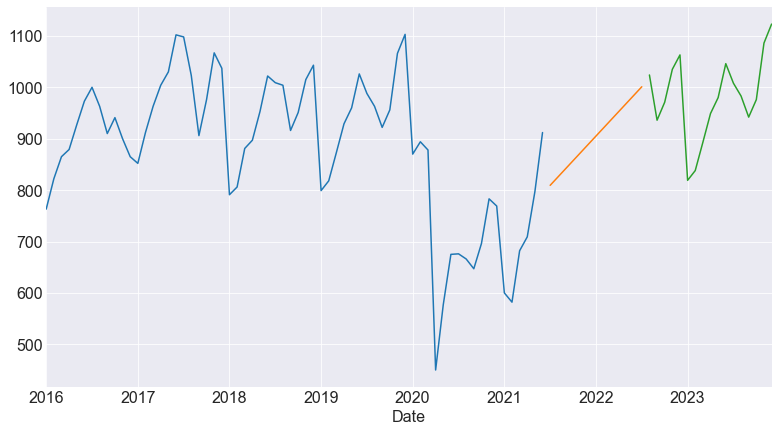

In [224]:
s_scene.plot()
holts.plot()
future.plot()

##### Final Plot

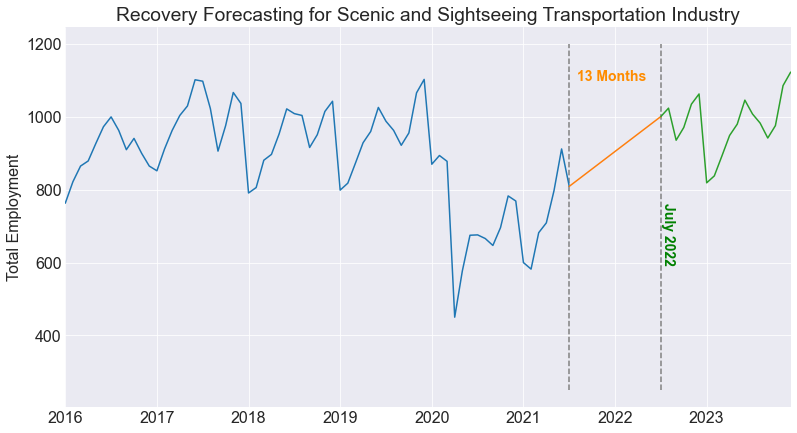

In [225]:
full_forecast = pd.concat([s_scene, holts, future])
full_forecast[ : '2021-07'].plot() # data we have
full_forecast['2021-07' : '2022-07'].plot() # linear recovery forecast
full_forecast['2022-07' : ].plot() # resumption forecast
plt.vlines(x='2021-07', ymin=250, ymax=1200, linestyles='--', colors='gray')
plt.vlines(x='2022-07', ymin=250, ymax=1200, linestyles='--', colors='gray')
plt.text('2021-08', 1100, '13 Months', fontsize=14, color='darkorange', fontweight='bold')
plt.text('2022-07', 600, 'July 2022', fontsize=14, color='green', fontweight='bold', rotation='-90')
plt.gca().set (title='Recovery Forecasting for Scenic and Sightseeing Transportation Industry', ylabel='Total Employment');
# plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

----
####  Amusement, Gambling, and Recreation Industries

In [226]:
char_df

recovery
Motion Picture and Sound Recording Industries        61.763515
Performing Arts, Spectator Sports, and Related ...   74.684926
Accommodation                                        77.209860
Clothing and Clothing Accessories Stores             81.494898
Scenic and Sightseeing Transportation                88.888889
Amusement, Gambling, and Recreation Industries       89.903270
Personal and Laundry Services                        93.778813
Miscellaneous Store Retailers                        95.706924
Furniture and Home Furnishings Stores                95.801793
Food Services and Drinking Places                    95.909662
Leather and Allied Product Manufacturing             96.645046
Sporting Goods, Hobby, Musical Instrument, and ...  102.360633

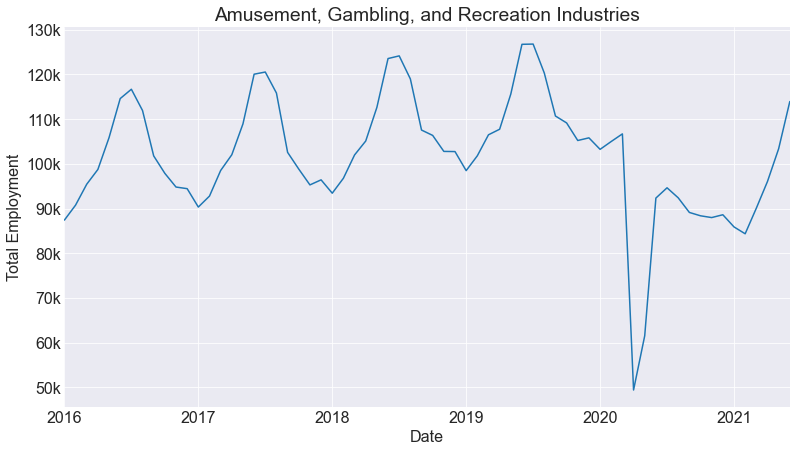

In [227]:
# forecast pre-COVID behavior after full recovery for Sporting Goods industry
s_amuse = forecast_ind_dict['Amusement, Gambling, and Recreation Industries']
s_amuse.plot()
plt.gca().set(ylabel = 'Total Employment', title='Amusement, Gambling, and Recreation Industries')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

---
##### Holt's Linear Trend (no smoothing)

In [228]:
s_amuse[s_amuse == s_amuse.min()]

Date
2020-04-01    49433
Name: Total Employment, dtype: int64

In [229]:
# define train set for this model
train = s_amuse['2020-04' : ]
train

Date
2020-04-01     49433
2020-05-01     61568
2020-06-01     92355
2020-07-01     94656
2020-08-01     92415
2020-09-01     89143
2020-10-01     88392
2020-11-01     87996
2020-12-01     88627
2021-01-01     85906
2021-02-01     84371
2021-03-01     90090
2021-04-01     96071
2021-05-01    103389
2021-06-01    113947
Name: Total Employment, dtype: int64

In [230]:
# define future index for this model, start long, trim later
future_index_str = [
    '2021-07',
    '2021-08',
    '2021-09',
    '2021-10',
    '2021-11', 
    '2021-12', 
    '2022-01', 
    '2022-02', 
    '2022-03',
    '2022-04',
    '2022-05',
    '2022-06',
    '2022-07',
    '2022-08',
    '2022-09',
    '2022-10',
    '2022-11',
    '2022-12',
    '2023-01', 
    '2023-02', 
    '2023-03',
    '2023-04',
    '2023-05',
    '2023-06',
    '2023-07',
    '2023-08',
    '2023-09',
    '2023-10',
    '2023-11',
    '2023-12'
    ]

future_index = pd.to_datetime(future_index_str)

In [231]:
model = Holt(train, exponential = False)
model = model.fit(smoothing_level = 0, 
                  smoothing_trend = 0,
                  optimized = True)

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<AxesSubplot:xlabel='Date'>

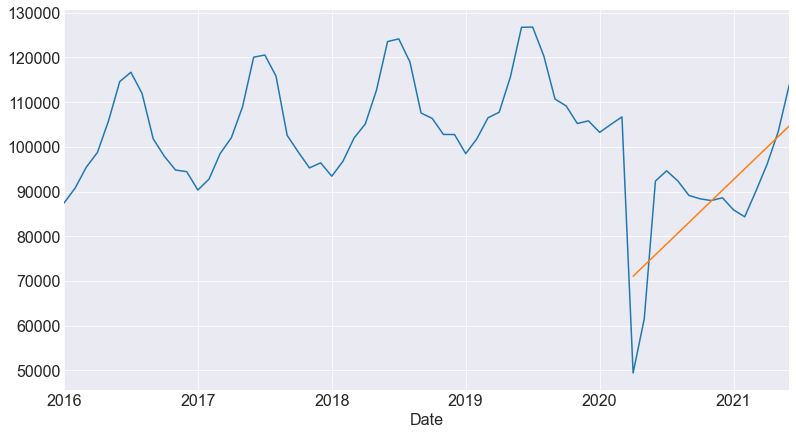

In [232]:
holts = model.predict(start = train.index[0], end = train.index[-1])
s_amuse.plot()
holts.plot()

In [233]:
explained_variance_score(train, holts)

0.4942578850989434

In [234]:
mean_squared_error(train, holts, squared=False)

10496.279335516818

<AxesSubplot:xlabel='Date'>

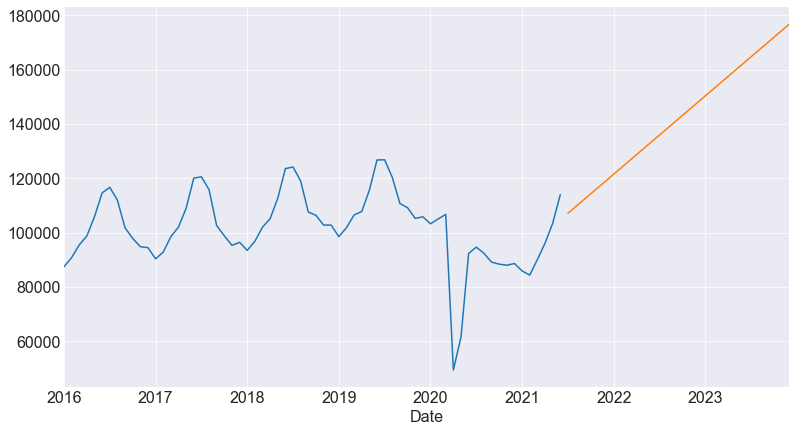

In [235]:
holts = model.predict(start = future_index[0], end = future_index[-1])
s_amuse.plot()
holts.plot()

In [236]:
# get values that indicate recovery
s_amuse['2019']

Date
2019-01-01     98493
2019-02-01    101812
2019-03-01    106508
2019-04-01    107752
2019-05-01    115622
2019-06-01    126744
2019-07-01    126796
2019-08-01    120325
2019-09-01    110711
2019-10-01    109164
2019-11-01    105231
2019-12-01    105827
Name: Total Employment, dtype: int64

In [237]:
holts

2021-07-01    107104.723410
2021-08-01    109506.513680
2021-09-01    111908.303950
2021-10-01    114310.094220
2021-11-01    116711.884490
2021-12-01    119113.674761
2022-01-01    121515.465031
2022-02-01    123917.255301
2022-03-01    126319.045571
2022-04-01    128720.835842
2022-05-01    131122.626112
2022-06-01    133524.416382
2022-07-01    135926.206652
2022-08-01    138327.996922
2022-09-01    140729.787193
2022-10-01    143131.577463
2022-11-01    145533.367733
2022-12-01    147935.158003
2023-01-01    150336.948274
2023-02-01    152738.738544
2023-03-01    155140.528814
2023-04-01    157542.319084
2023-05-01    159944.109355
2023-06-01    162345.899625
2023-07-01    164747.689895
2023-08-01    167149.480165
2023-09-01    169551.270435
2023-10-01    171953.060706
2023-11-01    174354.850976
2023-12-01    176756.641246
Freq: MS, dtype: float64

**Recovery date is 2021-09**

In [238]:
# redefine future index based on when recovery occured
future_index_str = [
    '2021-07',
    '2021-08',
    '2021-09'
    ]

future_index = pd.to_datetime(future_index_str)

len(future_index)

3

<AxesSubplot:xlabel='Date'>

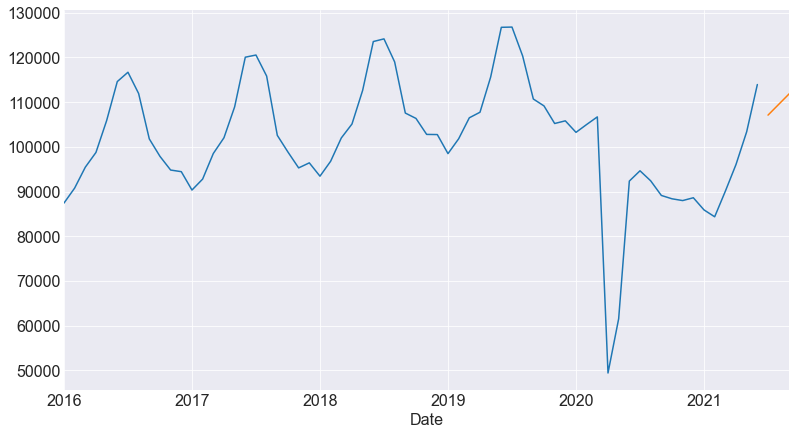

In [239]:
holts = model.predict(start = future_index[0], end = future_index[-1])
s_amuse.plot()
holts.plot()

##### Last normal season 

##### Splits

In [240]:
train = s_amuse['2016' : '2018']
test = s_amuse['2019']

##### Forecast

In [241]:
forecast = train['2018'] + (train.diff(12).mean())
forecast.index = test.index

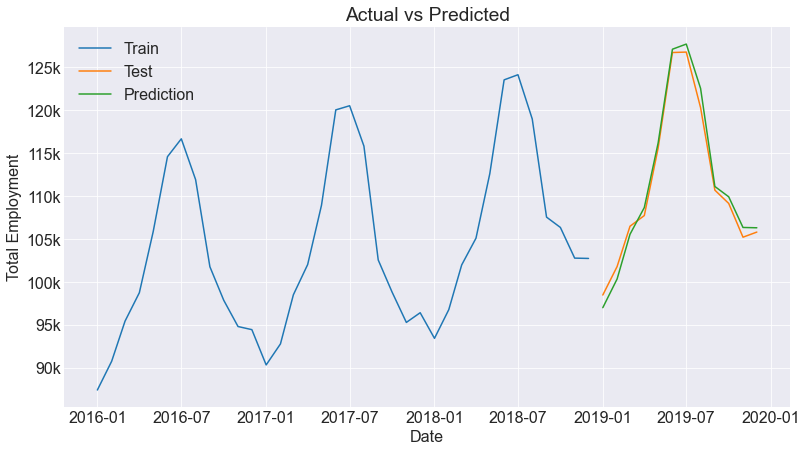

In [242]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.xlabel('Date')
plt.ylabel('Total Employment')
plt.plot(forecast, label = 'Prediction')
plt.title('Actual vs Predicted')
plt.legend()
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000))
plt.show()

In [243]:
# get RMSE
mean_squared_error(test, forecast, squared=False)

1109.2879042493366

In [244]:
# get R^2
explained_variance_score(test, forecast)

0.9857577001512258

In [245]:
# predict the future
# want to predict into future to get us to end of year 2023
# get values for respective months preceding pandemic 2018-11 to 2019-12
historical = s_amuse['2018-10' : '2019-12']

In [246]:
# get index for seasonal prediction
future_index_str = [
    '2021-10',
    '2021-11', 
    '2021-12', 
    '2022-01', 
    '2022-02', 
    '2022-03',
    '2022-04',
    '2022-05',
    '2022-06',
    '2022-07',
    '2022-08',
    '2022-09',
    '2022-10',
    '2022-11',
    '2022-12'
    ]

future_index = pd.to_datetime(future_index_str)

In [247]:
future = historical + (train.diff(12).mean())
# still need to reset the index
future.index = future_index

<AxesSubplot:xlabel='Date'>

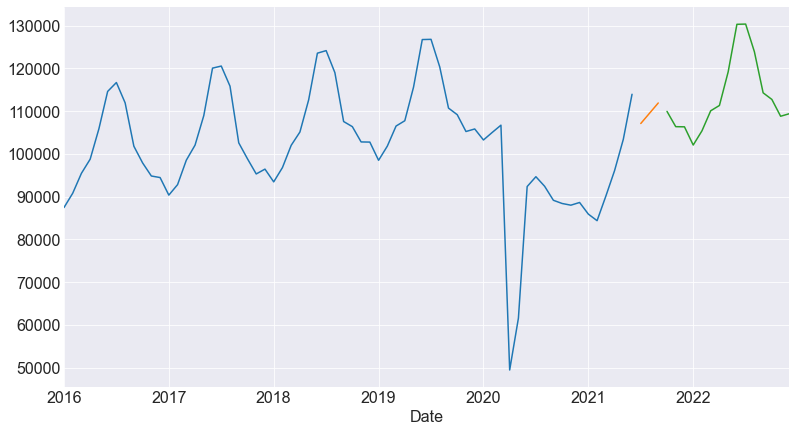

In [248]:
s_amuse.plot()
holts.plot()
future.plot()

##### Final Plot

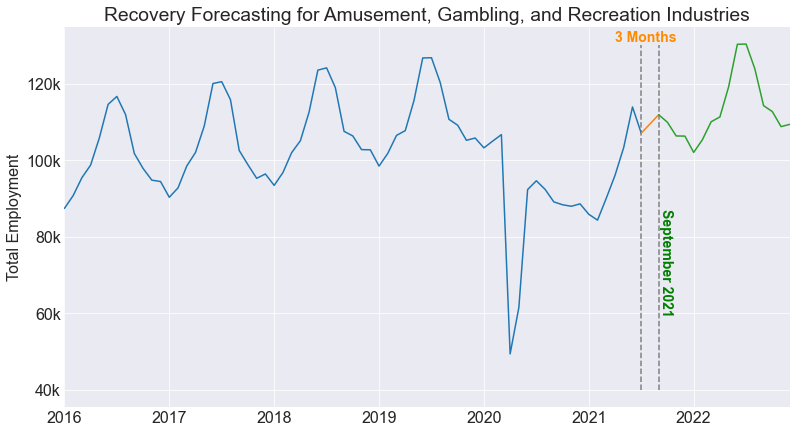

In [249]:
full_forecast = pd.concat([s_amuse, holts, future])
full_forecast[ : '2021-07'].plot() # data we have
full_forecast['2021-07' : '2021-09'].plot() # linear recovery forecast
full_forecast['2021-09' : ].plot() # resumption forecast
plt.vlines(x='2021-07', ymin=40_000, ymax=130_000, linestyles='--', colors='gray')
plt.vlines(x='2021-09', ymin=40_000, ymax=130_000, linestyles='--', colors='gray')
plt.text('2021-04', 131_000, '3 Months', fontsize=14, color='darkorange', fontweight='bold')
# plt.text('2021-07', 117_000, '3 Months', fontsize=14, color='darkorange', fontweight='bold', rotation='-90')
plt.text('2021-09', 60_000, 'September 2021', fontsize=14, color='green', fontweight='bold', rotation='-90')
plt.gca().set (title='Recovery Forecasting for Amusement, Gambling, and Recreation Industries', ylabel='Total Employment')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

----
####  Personal and Laundry Services

In [250]:
char_df

recovery
Motion Picture and Sound Recording Industries        61.763515
Performing Arts, Spectator Sports, and Related ...   74.684926
Accommodation                                        77.209860
Clothing and Clothing Accessories Stores             81.494898
Scenic and Sightseeing Transportation                88.888889
Amusement, Gambling, and Recreation Industries       89.903270
Personal and Laundry Services                        93.778813
Miscellaneous Store Retailers                        95.706924
Furniture and Home Furnishings Stores                95.801793
Food Services and Drinking Places                    95.909662
Leather and Allied Product Manufacturing             96.645046
Sporting Goods, Hobby, Musical Instrument, and ...  102.360633

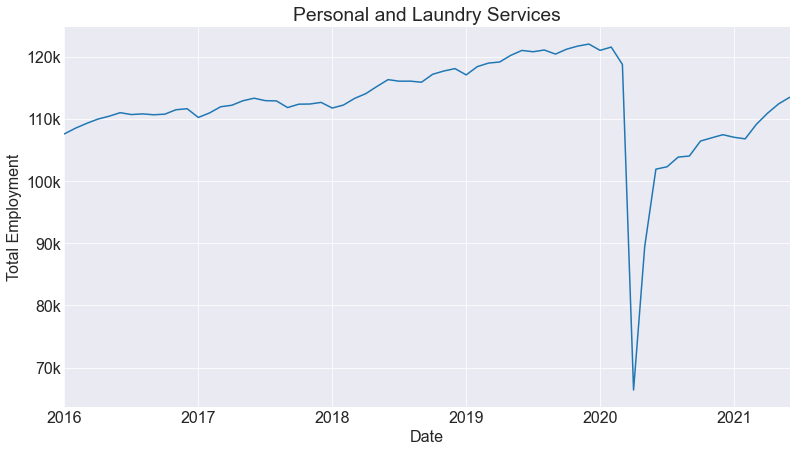

In [251]:
# forecast pre-COVID behavior after full recovery for Sporting Goods industry
s_laundry = forecast_ind_dict['Personal and Laundry Services']
s_laundry.plot()
plt.gca().set(ylabel = 'Total Employment', title='Personal and Laundry Services')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

---
##### Holt's Linear Trend (no smoothing)

In [252]:
s_laundry[s_laundry == s_laundry.min()]

Date
2020-04-01    66403
Name: Total Employment, dtype: int64

In [253]:
# define train set for this model
train = s_laundry['2020-06' : ]
train

Date
2020-06-01    101932
2020-07-01    102317
2020-08-01    103879
2020-09-01    104050
2020-10-01    106459
2020-11-01    106977
2020-12-01    107480
2021-01-01    107066
2021-02-01    106811
2021-03-01    109140
2021-04-01    110929
2021-05-01    112440
2021-06-01    113508
Name: Total Employment, dtype: int64

In [254]:
# define future index for this model, start long, trim later
future_index_str = [
    '2021-07',
    '2021-08',
    '2021-09',
    '2021-10',
    '2021-11', 
    '2021-12', 
    '2022-01', 
    '2022-02', 
    '2022-03',
    '2022-04',
    '2022-05',
    '2022-06',
    '2022-07',
    '2022-08',
    '2022-09',
    '2022-10',
    '2022-11',
    '2022-12',
    '2023-01', 
    '2023-02', 
    '2023-03',
    '2023-04',
    '2023-05',
    '2023-06',
    '2023-07',
    '2023-08',
    '2023-09',
    '2023-10',
    '2023-11',
    '2023-12'
    ]

future_index = pd.to_datetime(future_index_str)

In [255]:
model = Holt(train, exponential = False)
model = model.fit(smoothing_level = 0, 
                  smoothing_trend = 0,
                  optimized = True)

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<AxesSubplot:xlabel='Date'>

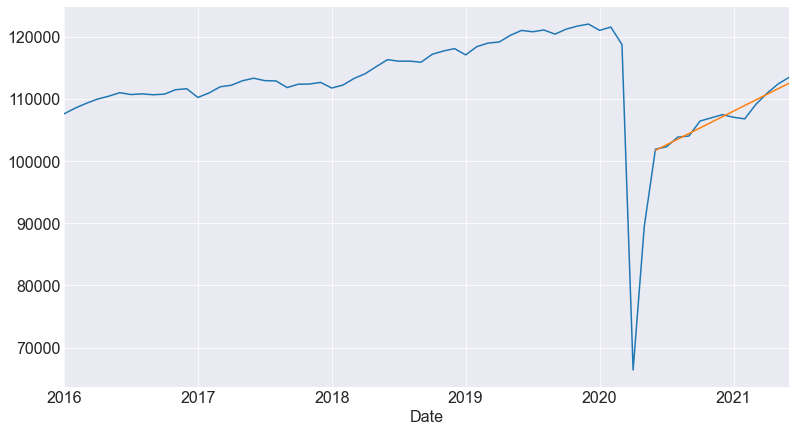

In [256]:
holts = model.predict(start = train.index[0], end = train.index[-1])
s_laundry.plot()
holts.plot()

In [257]:
explained_variance_score(train, holts)

0.9374568590297896

In [258]:
mean_squared_error(train, holts, squared=False)

872.6382690480011

<AxesSubplot:xlabel='Date'>

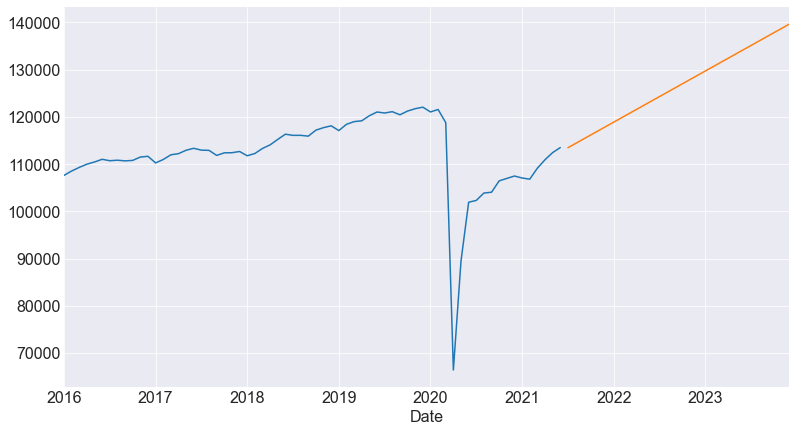

In [259]:
holts = model.predict(start = future_index[0], end = future_index[-1])
s_laundry.plot()
holts.plot()

In [260]:
# get values that indicate recovery
s_laundry['2019':'2020']

Date
2019-01-01    117102
2019-02-01    118434
2019-03-01    119000
2019-04-01    119177
2019-05-01    120252
2019-06-01    121038
2019-07-01    120825
2019-08-01    121107
2019-09-01    120448
2019-10-01    121238
2019-11-01    121736
2019-12-01    122061
2020-01-01    121049
2020-02-01    121578
2020-03-01    118785
2020-04-01     66403
2020-05-01     89495
2020-06-01    101932
2020-07-01    102317
2020-08-01    103879
2020-09-01    104050
2020-10-01    106459
2020-11-01    106977
2020-12-01    107480
Name: Total Employment, dtype: int64

In [261]:
holts

2021-07-01    113473.459101
2021-08-01    114376.392988
2021-09-01    115279.326875
2021-10-01    116182.260762
2021-11-01    117085.194649
2021-12-01    117988.128536
2022-01-01    118891.062423
2022-02-01    119793.996310
2022-03-01    120696.930197
2022-04-01    121599.864084
2022-05-01    122502.797971
2022-06-01    123405.731858
2022-07-01    124308.665745
2022-08-01    125211.599632
2022-09-01    126114.533519
2022-10-01    127017.467406
2022-11-01    127920.401293
2022-12-01    128823.335180
2023-01-01    129726.269067
2023-02-01    130629.202954
2023-03-01    131532.136841
2023-04-01    132435.070728
2023-05-01    133338.004615
2023-06-01    134240.938502
2023-07-01    135143.872389
2023-08-01    136046.806276
2023-09-01    136949.740162
2023-10-01    137852.674049
2023-11-01    138755.607936
2023-12-01    139658.541823
Freq: MS, dtype: float64

**Recovery date is 2022-03**

In [262]:
# redefine future index based on when recovery occured
future_index_str = [
    '2021-07',
    '2021-08',
    '2021-09',
    '2021-10',
    '2021-11', 
    '2021-12', 
    '2022-01', 
    '2022-02', 
    '2022-03'
    ]

future_index = pd.to_datetime(future_index_str)

len(future_index)

9

<AxesSubplot:xlabel='Date'>

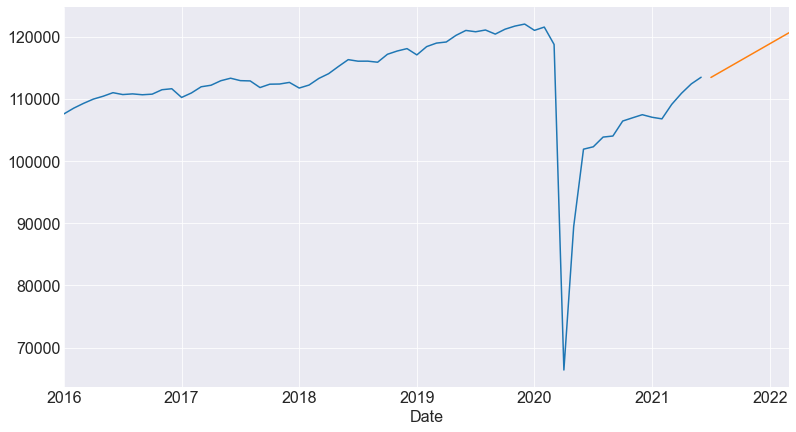

In [263]:
holts = model.predict(start = future_index[0], end = future_index[-1])
s_laundry.plot()
holts.plot()

##### Last normal season 

##### Splits

In [264]:
train = s_laundry['2016' : '2018']
test = s_laundry['2019']

##### Forecast

In [265]:
forecast = train['2018'] + 2*(train.diff(12).mean())
forecast.index = test.index

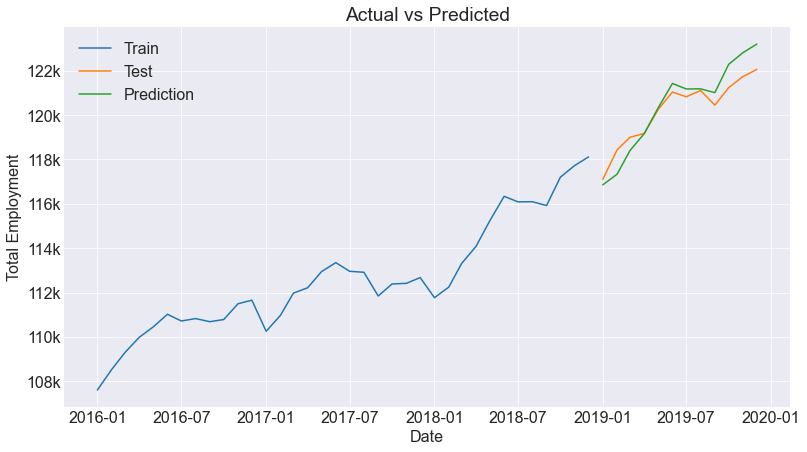

In [266]:
plt.plot(train, label='Train')
#plt.plot(validate, label='Validate')
plt.plot(test, label='Test')
plt.xlabel('Date')
plt.ylabel('Total Employment')
plt.plot(forecast, label = 'Prediction')
plt.title('Actual vs Predicted')
plt.legend()
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000))
plt.show()

In [267]:
# get RMSE
mean_squared_error(test, forecast, squared=False)

694.7981121640076

In [268]:
# get R^2
explained_variance_score(test, forecast)

0.7860067359422684

In [269]:
# predict the future
# want to predict into future to get us to end of year 2023
# get values for respective months preceding pandemic 2018-11 to 2019-12
historical = s_laundry['2018-04' : '2019-12']

In [270]:
# get index for seasonal prediction
future_index_str = [
    '2022-04',
    '2022-05',
    '2022-06',
    '2022-07',
    '2022-08',
    '2022-09',
    '2022-10',
    '2022-11', 
    '2022-12', 
    '2023-01', 
    '2023-02', 
    '2023-03',
    '2023-04',
    '2023-05',
    '2023-06',
    '2023-07',
    '2023-08',
    '2023-09',
    '2023-10',
    '2023-11',
    '2023-12'
    ]

future_index = pd.to_datetime(future_index_str)

In [271]:
future = historical + 2*(train.diff(12).mean())
# still need to reset the index
future.index = future_index

<AxesSubplot:xlabel='Date'>

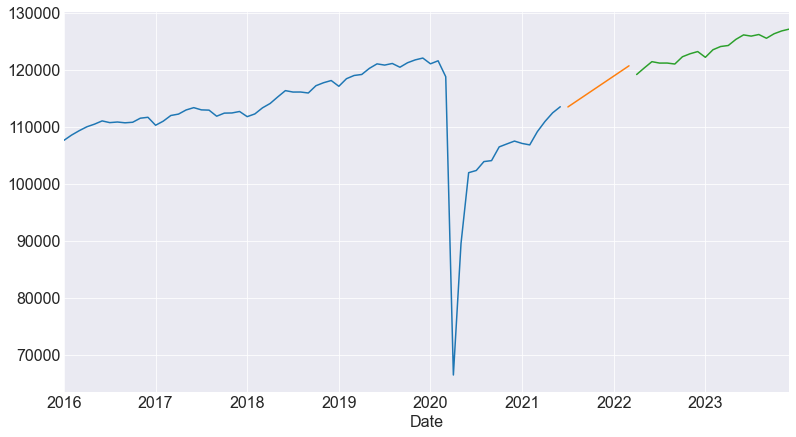

In [272]:
s_laundry.plot()
holts.plot()
future.plot()

##### Final Plot

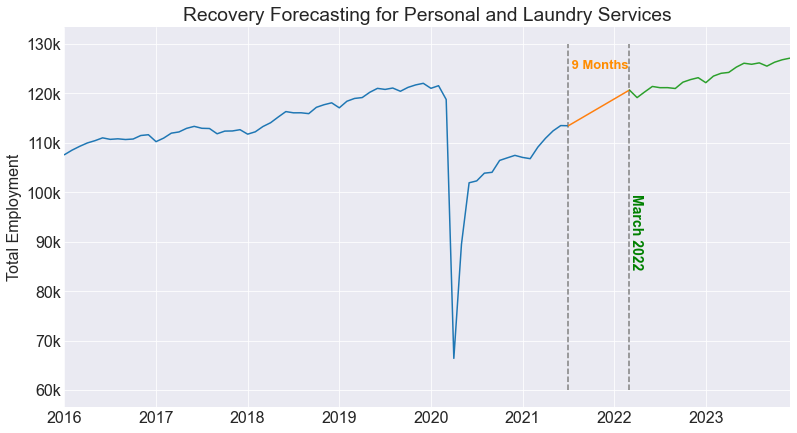

In [273]:
full_forecast = pd.concat([s_laundry, holts, future])
full_forecast[ : '2021-07'].plot() # data we have
full_forecast['2021-07' : '2022-03'].plot() # linear recovery forecast
full_forecast['2022-03' : ].plot() # resumption forecast
plt.vlines(x='2021-07', ymin=60_000, ymax=130_000, linestyles='--', colors='gray')
plt.vlines(x='2022-03', ymin=60_000, ymax=130_000, linestyles='--', colors='gray')
plt.text('2021-07', 125_000, ' 9 Months', fontsize=13, color='darkorange', fontweight='bold')
plt.text('2022-03', 85_000, 'March 2022', fontsize=14, color='green', fontweight='bold', rotation='-90')
plt.gca().set (title='Recovery Forecasting for Personal and Laundry Services', ylabel='Total Employment')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

----
#### Miscellaneous Store Retailers

In [274]:
char_df

recovery
Motion Picture and Sound Recording Industries        61.763515
Performing Arts, Spectator Sports, and Related ...   74.684926
Accommodation                                        77.209860
Clothing and Clothing Accessories Stores             81.494898
Scenic and Sightseeing Transportation                88.888889
Amusement, Gambling, and Recreation Industries       89.903270
Personal and Laundry Services                        93.778813
Miscellaneous Store Retailers                        95.706924
Furniture and Home Furnishings Stores                95.801793
Food Services and Drinking Places                    95.909662
Leather and Allied Product Manufacturing             96.645046
Sporting Goods, Hobby, Musical Instrument, and ...  102.360633

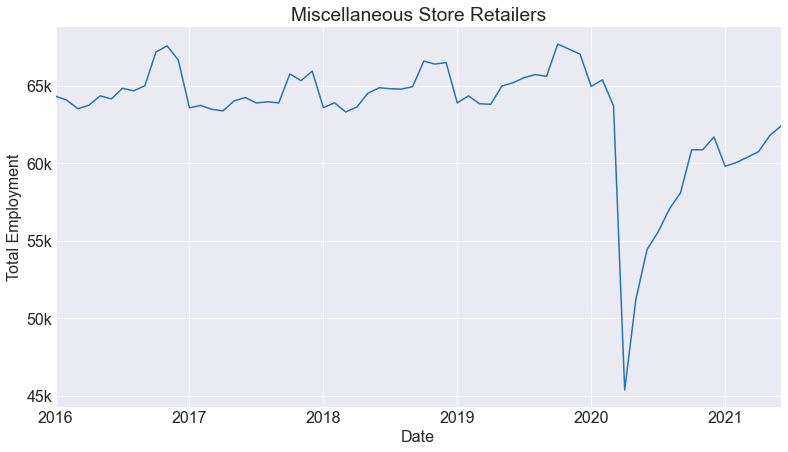

In [275]:
# forecast pre-COVID behavior after full recovery for Sporting Goods industry
s_misc = forecast_ind_dict['Miscellaneous Store Retailers ']
s_misc.plot()
plt.gca().set(ylabel = 'Total Employment', title='Miscellaneous Store Retailers')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

---
##### Holt's Linear Trend (no smoothing)

In [276]:
s_misc[s_misc == s_misc.min()]

Date
2020-04-01    45385
Name: Total Employment, dtype: int64

In [277]:
# define train set for this model
train = s_misc['2020-06' : ]
train

Date
2020-06-01    54434
2020-07-01    55583
2020-08-01    57048
2020-09-01    58094
2020-10-01    60870
2020-11-01    60877
2020-12-01    61698
2021-01-01    59807
2021-02-01    60051
2021-03-01    60395
2021-04-01    60754
2021-05-01    61794
2021-06-01    62399
Name: Total Employment, dtype: int64

In [278]:
# define future index for this model, start long, trim later
future_index_str = [
    '2021-07',
    '2021-08',
    '2021-09',
    '2021-10',
    '2021-11', 
    '2021-12', 
    '2022-01', 
    '2022-02', 
    '2022-03',
    '2022-04',
    '2022-05',
    '2022-06',
    '2022-07',
    '2022-08',
    '2022-09',
    '2022-10',
    '2022-11',
    '2022-12',
    '2023-01', 
    '2023-02', 
    '2023-03',
    '2023-04',
    '2023-05',
    '2023-06',
    '2023-07',
    '2023-08',
    '2023-09',
    '2023-10',
    '2023-11',
    '2023-12'
    ]

future_index = pd.to_datetime(future_index_str)

In [279]:
model = Holt(train, exponential = False)
model = model.fit(smoothing_level = 0, 
                  smoothing_trend = 0,
                  optimized = True)

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<AxesSubplot:xlabel='Date'>

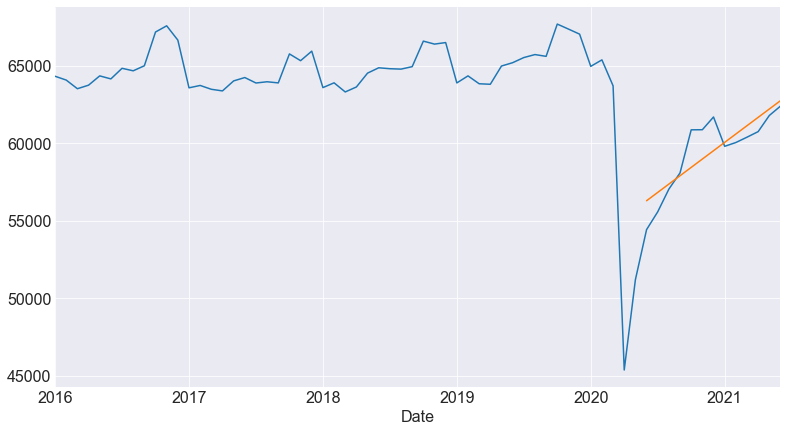

In [280]:
holts = model.predict(start = train.index[0], end = train.index[-1])
s_misc.plot()
holts.plot()

In [281]:
explained_variance_score(train, holts)

0.7108169428158546

In [282]:
mean_squared_error(train, holts, squared=False)

1283.2850339897736

<AxesSubplot:xlabel='Date'>

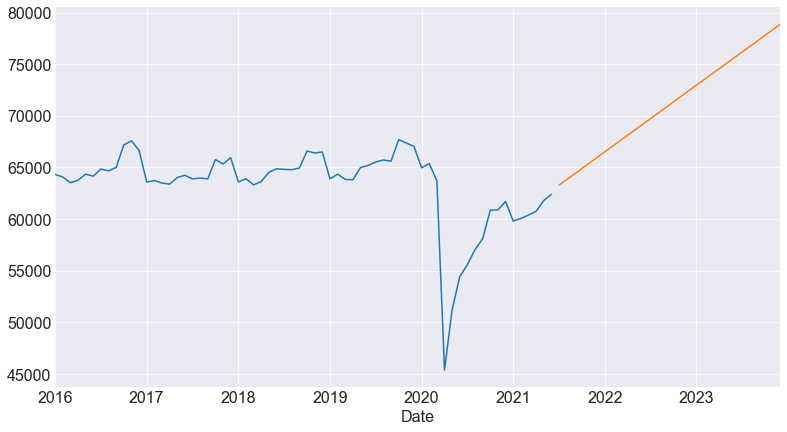

In [283]:
holts = model.predict(start = future_index[0], end = future_index[-1])
s_misc.plot()
holts.plot()

In [284]:
# get values that indicate recovery
s_misc['2019':'2020']

Date
2019-01-01    63894
2019-02-01    64348
2019-03-01    63840
2019-04-01    63807
2019-05-01    64983
2019-06-01    65198
2019-07-01    65529
2019-08-01    65722
2019-09-01    65607
2019-10-01    67688
2019-11-01    67366
2019-12-01    67039
2020-01-01    64963
2020-02-01    65380
2020-03-01    63707
2020-04-01    45385
2020-05-01    51209
2020-06-01    54434
2020-07-01    55583
2020-08-01    57048
2020-09-01    58094
2020-10-01    60870
2020-11-01    60877
2020-12-01    61698
Name: Total Employment, dtype: int64

In [285]:
holts

2021-07-01    63287.380113
2021-08-01    63825.093444
2021-09-01    64362.806776
2021-10-01    64900.520107
2021-11-01    65438.233438
2021-12-01    65975.946769
2022-01-01    66513.660101
2022-02-01    67051.373432
2022-03-01    67589.086763
2022-04-01    68126.800094
2022-05-01    68664.513426
2022-06-01    69202.226757
2022-07-01    69739.940088
2022-08-01    70277.653419
2022-09-01    70815.366751
2022-10-01    71353.080082
2022-11-01    71890.793413
2022-12-01    72428.506744
2023-01-01    72966.220076
2023-02-01    73503.933407
2023-03-01    74041.646738
2023-04-01    74579.360069
2023-05-01    75117.073401
2023-06-01    75654.786732
2023-07-01    76192.500063
2023-08-01    76730.213394
2023-09-01    77267.926726
2023-10-01    77805.640057
2023-11-01    78343.353388
2023-12-01    78881.066719
Freq: MS, dtype: float64

**Recovery date is 2022-01**

In [286]:
# redefine future index based on when recovery occured
future_index_str = [
    '2021-07',
    '2021-08',
    '2021-09',
    '2021-10',
    '2021-11', 
    '2021-12', 
    '2022-01'
    ]

future_index = pd.to_datetime(future_index_str)

len(future_index)

7

<AxesSubplot:xlabel='Date'>

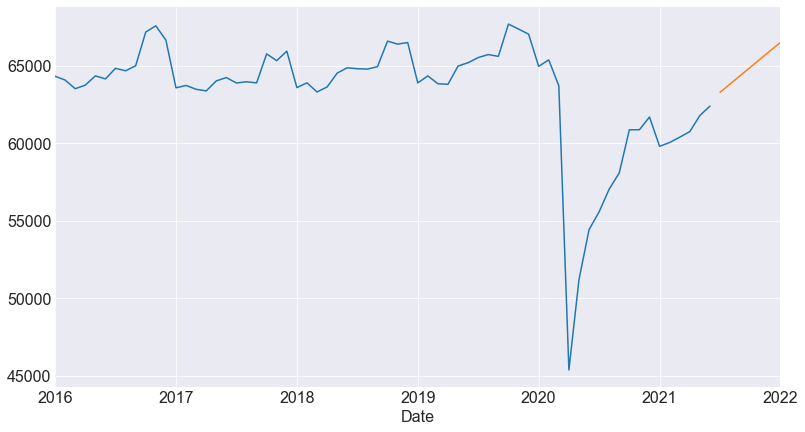

In [287]:
holts = model.predict(start = future_index[0], end = future_index[-1])
s_misc.plot()
holts.plot()

##### Last normal season 

##### Splits

In [288]:
train = s_misc['2016' : '2018']
test = s_misc['2019']

In [289]:
train.diff(12).mean()

-93.20833333333333

##### Forecast

In [290]:
forecast = train['2018'] + (train.diff(12).mean())
forecast.index = test.index

In [291]:
forecast

Date
2019-01-01    63498.791667
2019-02-01    63806.791667
2019-03-01    63218.791667
2019-04-01    63539.791667
2019-05-01    64432.791667
2019-06-01    64776.791667
2019-07-01    64716.791667
2019-08-01    64690.791667
2019-09-01    64849.791667
2019-10-01    66495.791667
2019-11-01    66303.791667
2019-12-01    66402.791667
Name: Total Employment, dtype: float64

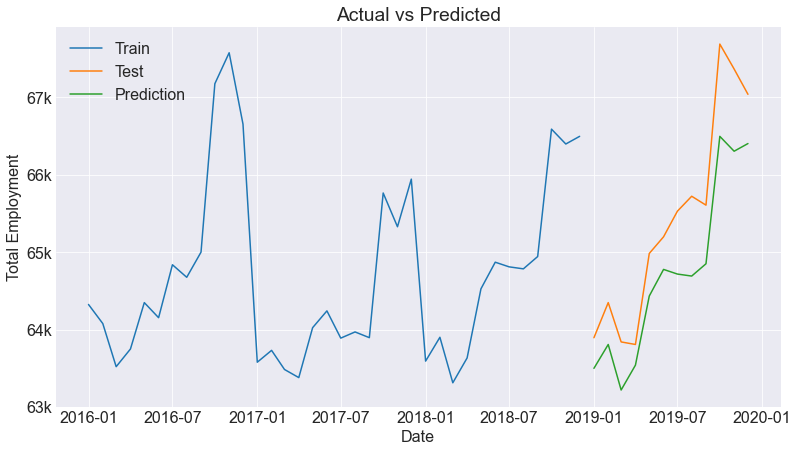

In [292]:
plt.plot(train, label='Train')
#plt.plot(validate, label='Validate')
plt.plot(test, label='Test')
plt.xlabel('Date')
plt.ylabel('Total Employment')
plt.plot(forecast, label = 'Prediction')
plt.title('Actual vs Predicted')
plt.legend()
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000))
plt.show()

In [293]:
# get RMSE
mean_squared_error(test, forecast, squared=False)

743.717442097841

In [294]:
# get R^2
explained_variance_score(test, forecast)

0.9554362773973608

In [295]:
# predict the future
# want to predict into future to get us to end of year 2023
# get values for respective months preceding pandemic 2018-11 to 2019-12
historical = s_misc['2018-02' : '2019-12']

In [296]:
# get index for seasonal prediction
future_index_str = [
    '2022-02', 
    '2022-03',
    '2022-04',
    '2022-05',
    '2022-06',
    '2022-07',
    '2022-08',
    '2022-09',
    '2022-10',
    '2022-11', 
    '2022-12', 
    '2023-01', 
    '2023-02', 
    '2023-03',
    '2023-04',
    '2023-05',
    '2023-06',
    '2023-07',
    '2023-08',
    '2023-09',
    '2023-10',
    '2023-11',
    '2023-12'
    ]

future_index = pd.to_datetime(future_index_str)

In [297]:
future = historical + train.diff(12).mean()
# still need to reset the index
future.index = future_index

<AxesSubplot:xlabel='Date'>

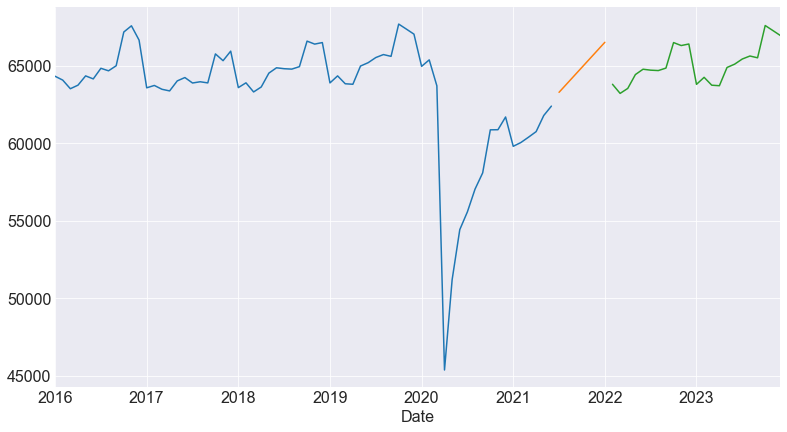

In [298]:
s_misc.plot()
holts.plot()
future.plot()

##### Final Plot

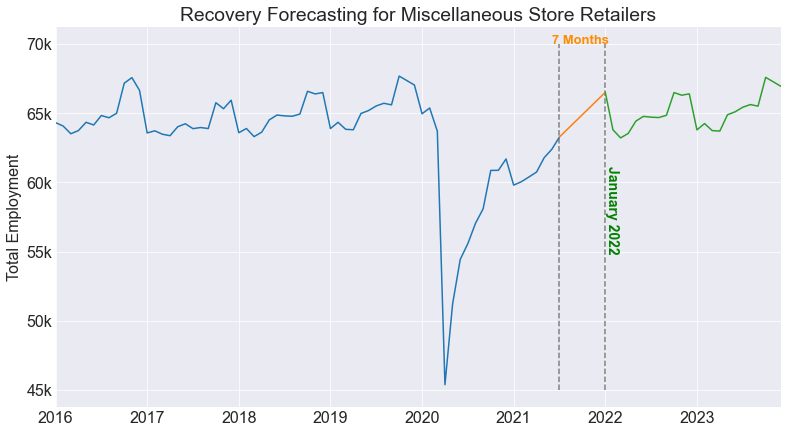

In [299]:
full_forecast = pd.concat([s_misc, holts, future])
full_forecast[ : '2021-07'].plot() # data we have
full_forecast['2021-07' : '2022-01'].plot() # linear recovery forecast
full_forecast['2022-01' : ].plot() # resumption forecast
plt.vlines(x='2021-07', ymin=45_000, ymax=70_000, linestyles='--', colors='gray')
plt.vlines(x='2022-01', ymin=45_000, ymax=70_000, linestyles='--', colors='gray')
plt.text('2021-06', 70_000, '7 Months', fontsize=13, color='darkorange', fontweight='bold')
plt.text('2022-01', 55_000, 'January 2022', fontsize=14, color='green', fontweight='bold', rotation='-90')
plt.gca().set (title='Recovery Forecasting for Miscellaneous Store Retailers', ylabel='Total Employment')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

----
#### Furniture and Home Furnishings Stores	

In [300]:
char_df

recovery
Motion Picture and Sound Recording Industries        61.763515
Performing Arts, Spectator Sports, and Related ...   74.684926
Accommodation                                        77.209860
Clothing and Clothing Accessories Stores             81.494898
Scenic and Sightseeing Transportation                88.888889
Amusement, Gambling, and Recreation Industries       89.903270
Personal and Laundry Services                        93.778813
Miscellaneous Store Retailers                        95.706924
Furniture and Home Furnishings Stores                95.801793
Food Services and Drinking Places                    95.909662
Leather and Allied Product Manufacturing             96.645046
Sporting Goods, Hobby, Musical Instrument, and ...  102.360633

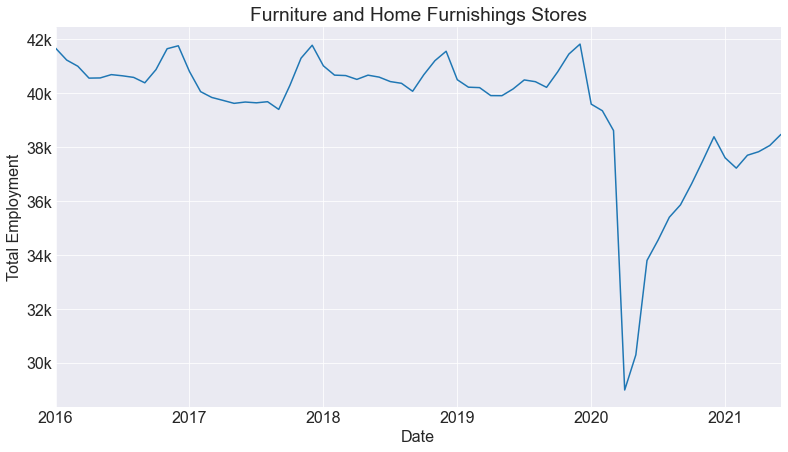

In [301]:
# forecast pre-COVID behavior after full recovery for Sporting Goods industry
s_furn = forecast_ind_dict['Furniture and Home Furnishings Stores ']
s_furn.plot()
plt.gca().set(ylabel = 'Total Employment', title='Furniture and Home Furnishings Stores')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

---
##### Holt's Linear Trend (no smoothing)

In [302]:
s_furn[s_furn == s_furn.min()]

Date
2020-04-01    29002
Name: Total Employment, dtype: int64

In [303]:
# define train set for this model
train = s_furn['2020-06' : ]
train

Date
2020-06-01    33804
2020-07-01    34564
2020-08-01    35405
2020-09-01    35865
2020-10-01    36648
2020-11-01    37502
2020-12-01    38388
2021-01-01    37607
2021-02-01    37225
2021-03-01    37703
2021-04-01    37833
2021-05-01    38064
2021-06-01    38474
Name: Total Employment, dtype: int64

In [304]:
# define future index for this model, start long, trim later
future_index_str = [
    '2021-07',
    '2021-08',
    '2021-09',
    '2021-10',
    '2021-11', 
    '2021-12', 
    '2022-01', 
    '2022-02', 
    '2022-03',
    '2022-04',
    '2022-05',
    '2022-06',
    '2022-07',
    '2022-08',
    '2022-09',
    '2022-10',
    '2022-11',
    '2022-12',
    '2023-01', 
    '2023-02', 
    '2023-03',
    '2023-04',
    '2023-05',
    '2023-06',
    '2023-07',
    '2023-08',
    '2023-09',
    '2023-10',
    '2023-11',
    '2023-12'
    ]

future_index = pd.to_datetime(future_index_str)

In [305]:
model = Holt(train, exponential = False)
model = model.fit(smoothing_level = 0, 
                  smoothing_trend = 0,
                  optimized = True)

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<AxesSubplot:xlabel='Date'>

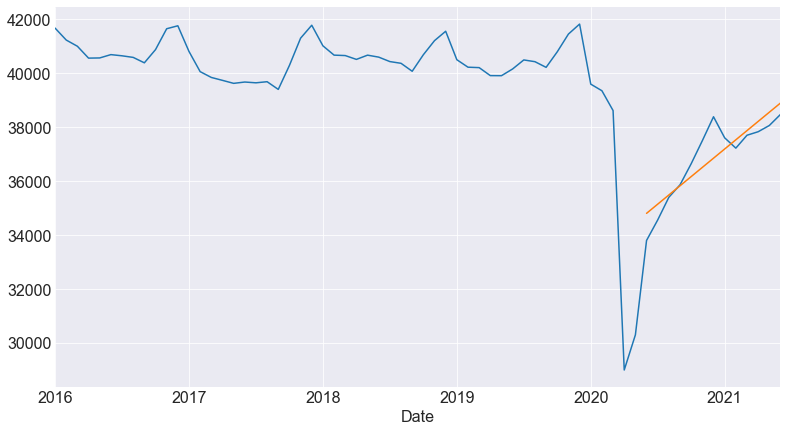

In [306]:
holts = model.predict(start = train.index[0], end = train.index[-1])
s_furn.plot()
holts.plot()

In [307]:
explained_variance_score(train, holts)

0.784934050509612

In [308]:
mean_squared_error(train, holts, squared=False)

667.2500038402031

<AxesSubplot:xlabel='Date'>

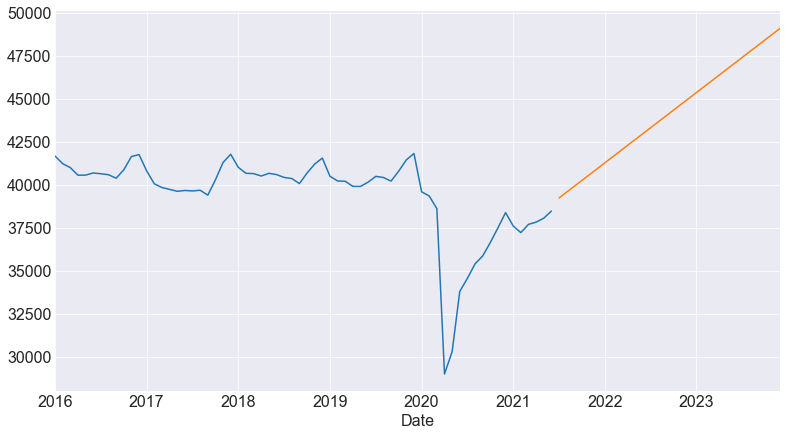

In [309]:
holts = model.predict(start = future_index[0], end = future_index[-1])
s_furn.plot()
holts.plot()

In [310]:
# get values that indicate recovery
s_furn['2019':'2020']

Date
2019-01-01    40502
2019-02-01    40225
2019-03-01    40209
2019-04-01    39913
2019-05-01    39910
2019-06-01    40160
2019-07-01    40494
2019-08-01    40429
2019-09-01    40219
2019-10-01    40796
2019-11-01    41453
2019-12-01    41823
2020-01-01    39597
2020-02-01    39352
2020-03-01    38618
2020-04-01    29002
2020-05-01    30305
2020-06-01    33804
2020-07-01    34564
2020-08-01    35405
2020-09-01    35865
2020-10-01    36648
2020-11-01    37502
2020-12-01    38388
Name: Total Employment, dtype: int64

In [311]:
holts

2021-07-01    39237.269450
2021-08-01    39577.956258
2021-09-01    39918.643065
2021-10-01    40259.329872
2021-11-01    40600.016680
2021-12-01    40940.703487
2022-01-01    41281.390294
2022-02-01    41622.077102
2022-03-01    41962.763909
2022-04-01    42303.450717
2022-05-01    42644.137524
2022-06-01    42984.824331
2022-07-01    43325.511139
2022-08-01    43666.197946
2022-09-01    44006.884754
2022-10-01    44347.571561
2022-11-01    44688.258368
2022-12-01    45028.945176
2023-01-01    45369.631983
2023-02-01    45710.318791
2023-03-01    46051.005598
2023-04-01    46391.692405
2023-05-01    46732.379213
2023-06-01    47073.066020
2023-07-01    47413.752827
2023-08-01    47754.439635
2023-09-01    48095.126442
2023-10-01    48435.813250
2023-11-01    48776.500057
2023-12-01    49117.186864
Freq: MS, dtype: float64

**Recovery date is 2022-01**

In [312]:
# redefine future index based on when recovery occured
future_index_str = [
    '2021-07',
    '2021-08',
    '2021-09',
    '2021-10',
    '2021-11', 
    '2021-12', 
    '2022-01'
    ]

future_index = pd.to_datetime(future_index_str)

len(future_index)

7

<AxesSubplot:xlabel='Date'>

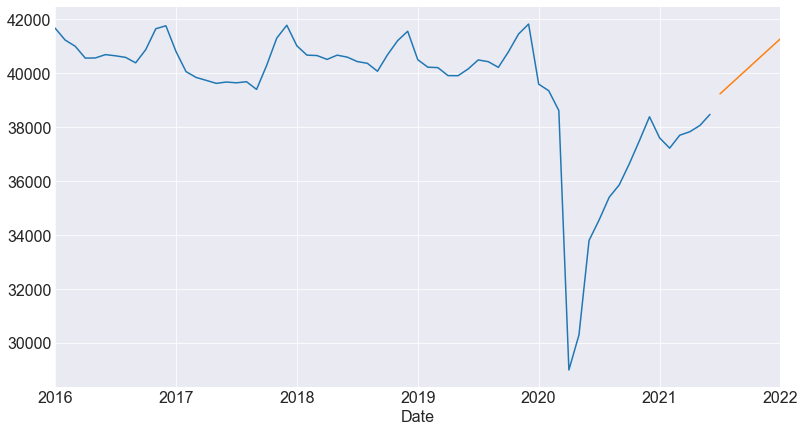

In [313]:
holts = model.predict(start = future_index[0], end = future_index[-1])
s_furn.plot()
holts.plot()

##### Last normal season 

##### Splits

In [314]:
train = s_furn['2016' : '2018']
test = s_furn['2019']

In [315]:
train.diff(12).mean()

-132.375

##### Forecast

In [316]:
forecast = train['2018'] + (train.diff(12).mean())
forecast.index = test.index

In [317]:
forecast

Date
2019-01-01    40884.625
2019-02-01    40539.625
2019-03-01    40523.625
2019-04-01    40381.625
2019-05-01    40538.625
2019-06-01    40465.625
2019-07-01    40300.625
2019-08-01    40236.625
2019-09-01    39941.625
2019-10-01    40554.625
2019-11-01    41076.625
2019-12-01    41424.625
Name: Total Employment, dtype: float64

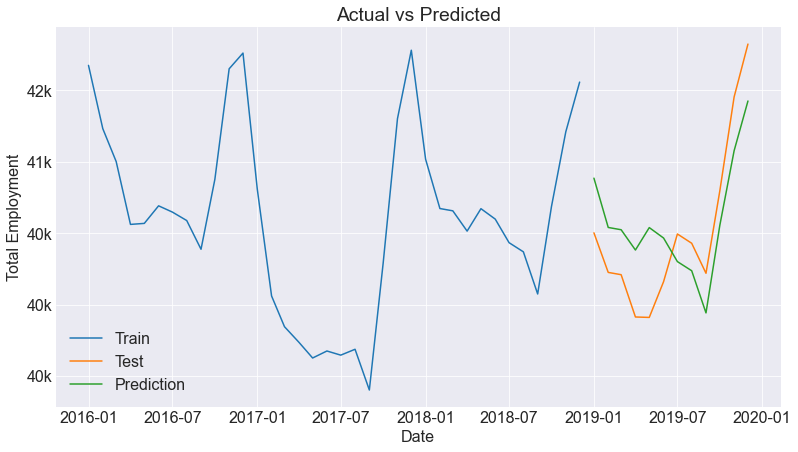

In [318]:
plt.plot(train, label='Train')
#plt.plot(validate, label='Validate')
plt.plot(test, label='Test')
plt.xlabel('Date')
plt.ylabel('Total Employment')
plt.plot(forecast, label = 'Prediction')
plt.title('Actual vs Predicted')
plt.legend()
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000))
plt.show()

In [319]:
# get RMSE
mean_squared_error(test, forecast, squared=False)

360.84699983741956

In [320]:
# get R^2
explained_variance_score(test, forecast)

0.6003876705014923

In [321]:
# predict the future
# want to predict into future to get us to end of year 2023
# get values for respective months preceding pandemic 2018-11 to 2019-12
historical = s_furn['2018-02' : '2019-12']

In [322]:
# get index for seasonal prediction
future_index_str = [
    '2022-02', 
    '2022-03',
    '2022-04',
    '2022-05',
    '2022-06',
    '2022-07',
    '2022-08',
    '2022-09',
    '2022-10',
    '2022-11', 
    '2022-12', 
    '2023-01', 
    '2023-02', 
    '2023-03',
    '2023-04',
    '2023-05',
    '2023-06',
    '2023-07',
    '2023-08',
    '2023-09',
    '2023-10',
    '2023-11',
    '2023-12'
    ]

future_index = pd.to_datetime(future_index_str)

In [323]:
future = historical + train.diff(12).mean()
# still need to reset the index
future.index = future_index

<AxesSubplot:xlabel='Date'>

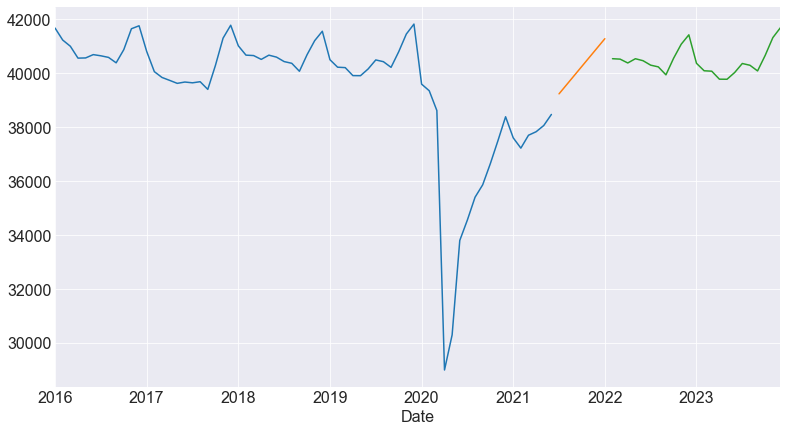

In [324]:
s_furn.plot()
holts.plot()
future.plot()

##### Final Plot

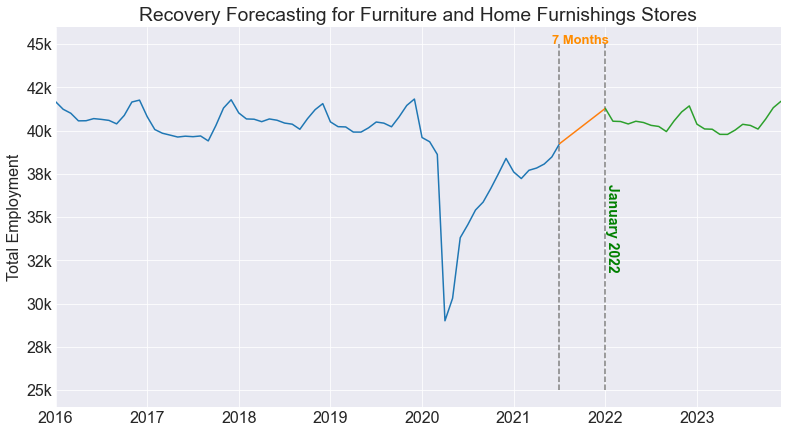

In [325]:
full_forecast = pd.concat([s_furn, holts, future])
full_forecast[ : '2021-07'].plot() # data we have
full_forecast['2021-07' : '2022-01'].plot() # linear recovery forecast
full_forecast['2022-01' : ].plot() # resumption forecast
plt.vlines(x='2021-07', ymin=25_000, ymax=45_000, linestyles='--', colors='gray')
plt.vlines(x='2022-01', ymin=25_000, ymax=45_000, linestyles='--', colors='gray')
plt.text('2021-06', 45_000, '7 Months', fontsize=13, color='darkorange', fontweight='bold')
plt.text('2022-01', 32_000, 'January 2022', fontsize=14, color='green', fontweight='bold', rotation='-90')
plt.gca().set (title='Recovery Forecasting for Furniture and Home Furnishings Stores', ylabel='Total Employment')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

----
#### Food Services and Drinking Places

In [326]:
char_df

recovery
Motion Picture and Sound Recording Industries        61.763515
Performing Arts, Spectator Sports, and Related ...   74.684926
Accommodation                                        77.209860
Clothing and Clothing Accessories Stores             81.494898
Scenic and Sightseeing Transportation                88.888889
Amusement, Gambling, and Recreation Industries       89.903270
Personal and Laundry Services                        93.778813
Miscellaneous Store Retailers                        95.706924
Furniture and Home Furnishings Stores                95.801793
Food Services and Drinking Places                    95.909662
Leather and Allied Product Manufacturing             96.645046
Sporting Goods, Hobby, Musical Instrument, and ...  102.360633

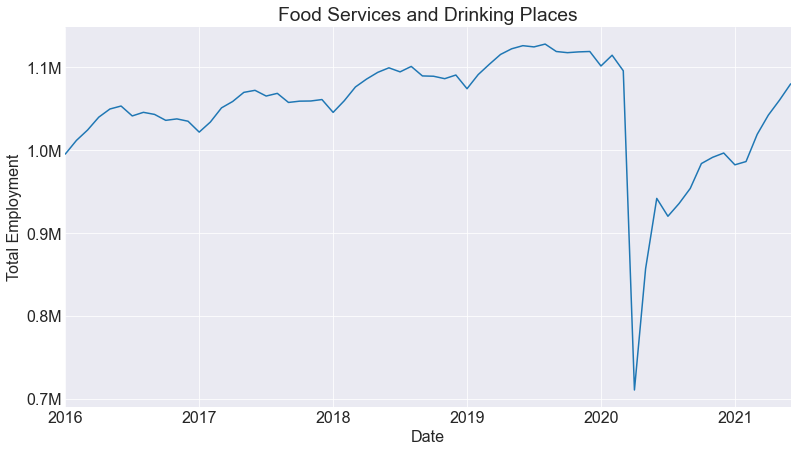

In [327]:
# forecast pre-COVID behavior after full recovery for Sporting Goods industry
s_food = forecast_ind_dict['Food Services and Drinking Places']
s_food.plot()
plt.gca().set(ylabel = 'Total Employment', title='Food Services and Drinking Places')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.1f}M'.format(x / 1_000_000));

---
##### Holt's Linear Trend (no smoothing)

In [328]:
s_food[s_food == s_food.min()]

Date
2020-04-01    710703
Name: Total Employment, dtype: int64

In [329]:
# define train set for this model
train = s_food['2020-06' : ]
train

Date
2020-06-01     941960
2020-07-01     920388
2020-08-01     935779
2020-09-01     953958
2020-10-01     984009
2020-11-01     991496
2020-12-01     996723
2021-01-01     982489
2021-02-01     986414
2021-03-01    1019267
2021-04-01    1042490
2021-05-01    1060544
2021-06-01    1080196
Name: Total Employment, dtype: int64

In [330]:
# define future index for this model, start long, trim later
future_index_str = [
    '2021-07',
    '2021-08',
    '2021-09',
    '2021-10',
    '2021-11', 
    '2021-12', 
    '2022-01', 
    '2022-02', 
    '2022-03',
    '2022-04',
    '2022-05',
    '2022-06',
    '2022-07',
    '2022-08',
    '2022-09',
    '2022-10',
    '2022-11',
    '2022-12',
    '2023-01', 
    '2023-02', 
    '2023-03',
    '2023-04',
    '2023-05',
    '2023-06',
    '2023-07',
    '2023-08',
    '2023-09',
    '2023-10',
    '2023-11',
    '2023-12'
    ]

future_index = pd.to_datetime(future_index_str)

In [331]:
model = Holt(train, exponential = False)
model = model.fit(smoothing_level = 0, 
                  smoothing_trend = 0,
                  optimized = True)

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<AxesSubplot:xlabel='Date'>

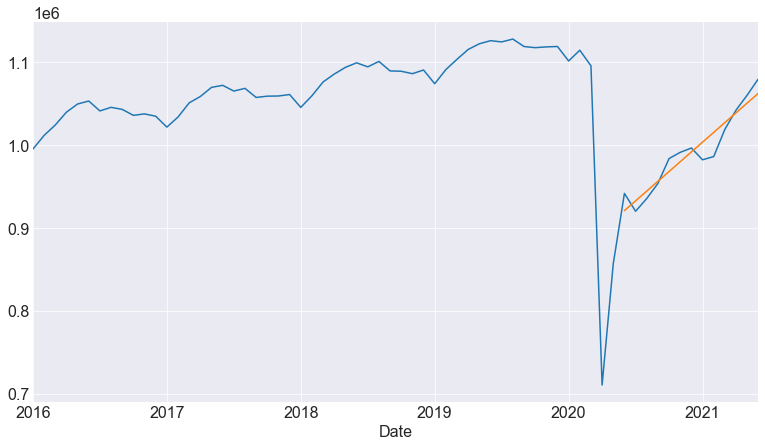

In [332]:
holts = model.predict(start = train.index[0], end = train.index[-1])
s_food.plot()
holts.plot()

In [333]:
explained_variance_score(train, holts)

0.8990501478139424

In [334]:
mean_squared_error(train, holts, squared=False)

14802.785537307363

<AxesSubplot:xlabel='Date'>

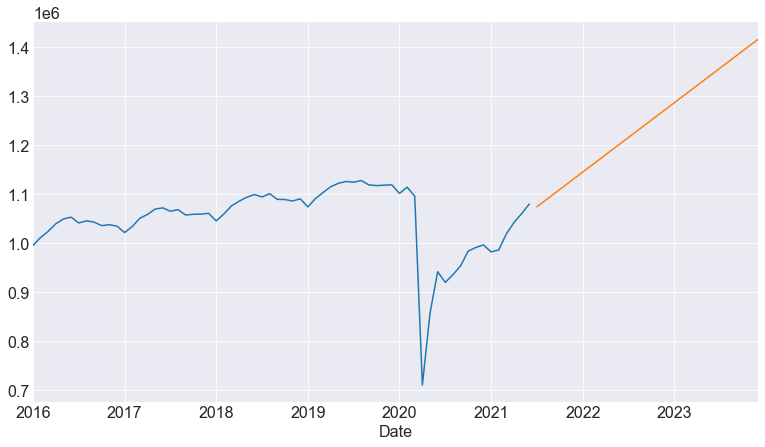

In [335]:
holts = model.predict(start = future_index[0], end = future_index[-1])
s_food.plot()
holts.plot()

In [336]:
# get values that indicate recovery
s_food['2019':'2020']

Date
2019-01-01    1074318
2019-02-01    1091364
2019-03-01    1103832
2019-04-01    1115679
2019-05-01    1122513
2019-06-01    1126264
2019-07-01    1124788
2019-08-01    1128198
2019-09-01    1119230
2019-10-01    1117827
2019-11-01    1118768
2019-12-01    1119249
2020-01-01    1101764
2020-02-01    1114748
2020-03-01    1095979
2020-04-01     710703
2020-05-01     857109
2020-06-01     941960
2020-07-01     920388
2020-08-01     935779
2020-09-01     953958
2020-10-01     984009
2020-11-01     991496
2020-12-01     996723
Name: Total Employment, dtype: int64

In [337]:
holts

2021-07-01    1.074623e+06
2021-08-01    1.086430e+06
2021-09-01    1.098236e+06
2021-10-01    1.110042e+06
2021-11-01    1.121849e+06
2021-12-01    1.133655e+06
2022-01-01    1.145462e+06
2022-02-01    1.157268e+06
2022-03-01    1.169075e+06
2022-04-01    1.180881e+06
2022-05-01    1.192688e+06
2022-06-01    1.204494e+06
2022-07-01    1.216301e+06
2022-08-01    1.228107e+06
2022-09-01    1.239913e+06
2022-10-01    1.251720e+06
2022-11-01    1.263526e+06
2022-12-01    1.275333e+06
2023-01-01    1.287139e+06
2023-02-01    1.298946e+06
2023-03-01    1.310752e+06
2023-04-01    1.322559e+06
2023-05-01    1.334365e+06
2023-06-01    1.346172e+06
2023-07-01    1.357978e+06
2023-08-01    1.369784e+06
2023-09-01    1.381591e+06
2023-10-01    1.393397e+06
2023-11-01    1.405204e+06
2023-12-01    1.417010e+06
Freq: MS, dtype: float64

**Recovery date is 2021-11**

In [338]:
# redefine future index based on when recovery occured
future_index_str = [
    '2021-07',
    '2021-08',
    '2021-09',
    '2021-10',
    '2021-11'
    ]

future_index = pd.to_datetime(future_index_str)

len(future_index)

5

<AxesSubplot:xlabel='Date'>

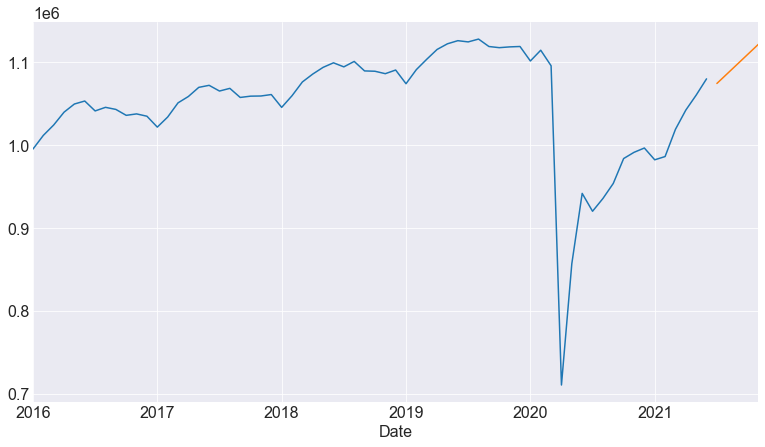

In [339]:
holts = model.predict(start = future_index[0], end = future_index[-1])
s_food.plot()
holts.plot()

##### Last normal season 

##### Splits

In [340]:
train = s_food['2016' : '2018']
test = s_food['2019']

In [341]:
train.diff(12).mean()

24961.583333333332

##### Forecast

In [342]:
forecast = train['2018'] + (train.diff(12).mean())
forecast.index = test.index

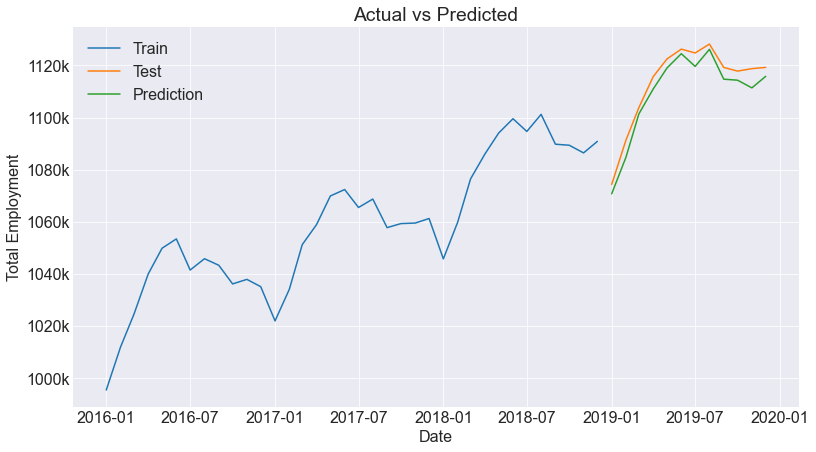

In [343]:
plt.plot(train, label='Train')
#plt.plot(validate, label='Validate')
plt.plot(test, label='Test')
plt.xlabel('Date')
plt.ylabel('Total Employment')
plt.plot(forecast, label = 'Prediction')
plt.title('Actual vs Predicted')
plt.legend()
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000))
plt.show()

In [344]:
# get RMSE
mean_squared_error(test, forecast, squared=False)

4369.246242679313

In [345]:
# get R^2
explained_variance_score(test, forecast)

0.9884415511610468

In [346]:
# predict the future
# want to predict into future to get us to end of year 2023
# get values for respective months preceding pandemic 2018-11 to 2019-12
historical = s_food['2018-12' : '2019-12']

In [347]:
# get index for seasonal prediction
future_index_str = [
    '2021-12', 
    '2022-01', 
    '2022-02', 
    '2022-03',
    '2022-04',
    '2022-05',
    '2022-06',
    '2022-07',
    '2022-08',
    '2022-09',
    '2022-10',
    '2022-11',
    '2022-12'
    ]

future_index = pd.to_datetime(future_index_str)

In [348]:
future = historical + train.diff(12).mean()
# still need to reset the index
future.index = future_index

<AxesSubplot:xlabel='Date'>

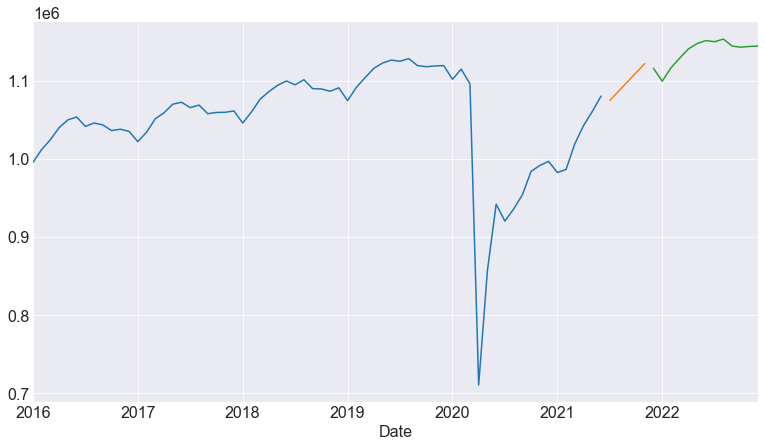

In [349]:
s_food.plot()
holts.plot()
future.plot()

##### Final Plot

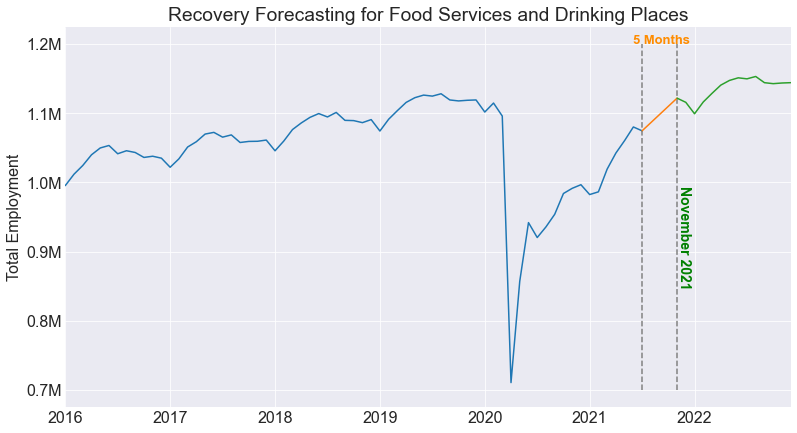

In [350]:
full_forecast = pd.concat([s_food, holts, future])
full_forecast[ : '2021-07'].plot() # data we have
full_forecast['2021-07' : '2021-11'].plot() # linear recovery forecast
full_forecast['2021-11' : ].plot() # resumption forecast
plt.vlines(x='2021-07', ymin=700_000, ymax=1_200_000, linestyles='--', colors='gray')
plt.vlines(x='2021-11', ymin=700_000, ymax=1_200_000, linestyles='--', colors='gray')
plt.text('2021-06', 1_200_000, '5 Months', fontsize=13, color='darkorange', fontweight='bold')
plt.text('2021-11', 850_000, 'November 2021', fontsize=14, color='green', fontweight='bold', rotation='-90')
plt.gca().set (title='Recovery Forecasting for Food Services and Drinking Places', ylabel='Total Employment')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.1f}M'.format(x / 1_000_000));

----
#### Leather and Allied Product Manufacturing

In [351]:
char_df

recovery
Motion Picture and Sound Recording Industries        61.763515
Performing Arts, Spectator Sports, and Related ...   74.684926
Accommodation                                        77.209860
Clothing and Clothing Accessories Stores             81.494898
Scenic and Sightseeing Transportation                88.888889
Amusement, Gambling, and Recreation Industries       89.903270
Personal and Laundry Services                        93.778813
Miscellaneous Store Retailers                        95.706924
Furniture and Home Furnishings Stores                95.801793
Food Services and Drinking Places                    95.909662
Leather and Allied Product Manufacturing             96.645046
Sporting Goods, Hobby, Musical Instrument, and ...  102.360633

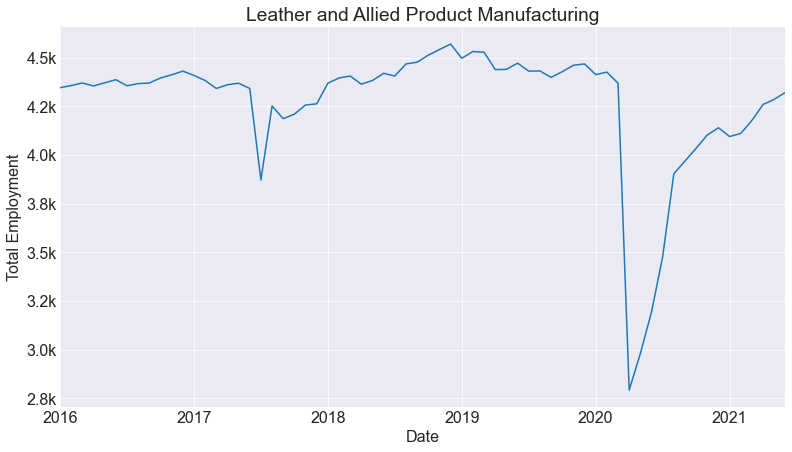

In [352]:
# forecast pre-COVID behavior after full recovery for Sporting Goods industry
s_leather = forecast_ind_dict['Leather and Allied Product Manufacturing']
s_leather.plot()
plt.gca().set(ylabel = 'Total Employment', title='Leather and Allied Product Manufacturing')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.1f}k'.format(x / 1_000));

---
##### Holt's Linear Trend (no smoothing)

In [353]:
s_leather[s_leather == s_leather.min()]

Date
2020-04-01    2792
Name: Total Employment, dtype: int64

In [354]:
# define train set for this model
train = s_leather['2020-08' : ]
train

Date
2020-08-01    3903
2020-09-01    3968
2020-10-01    4034
2020-11-01    4102
2020-12-01    4139
2021-01-01    4094
2021-02-01    4110
2021-03-01    4177
2021-04-01    4259
2021-05-01    4285
2021-06-01    4321
Name: Total Employment, dtype: int64

In [355]:
# define future index for this model, start long, trim later
future_index_str = [
    '2021-07',
    '2021-08',
    '2021-09',
    '2021-10',
    '2021-11', 
    '2021-12', 
    '2022-01', 
    '2022-02', 
    '2022-03',
    '2022-04',
    '2022-05',
    '2022-06',
    '2022-07',
    '2022-08',
    '2022-09',
    '2022-10',
    '2022-11',
    '2022-12',
    '2023-01', 
    '2023-02', 
    '2023-03',
    '2023-04',
    '2023-05',
    '2023-06',
    '2023-07',
    '2023-08',
    '2023-09',
    '2023-10',
    '2023-11',
    '2023-12'
    ]

future_index = pd.to_datetime(future_index_str)

In [356]:
model = Holt(train, exponential = False)
model = model.fit(smoothing_level = 0, 
                  smoothing_trend = 0,
                  optimized = True)

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<AxesSubplot:xlabel='Date'>

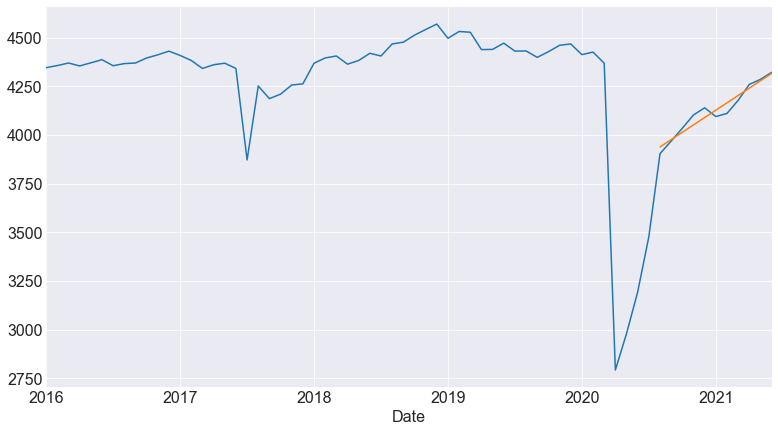

In [357]:
holts = model.predict(start = train.index[0], end = train.index[-1])
s_leather.plot()
holts.plot()

In [358]:
explained_variance_score(train, holts)

0.9294646656489928

In [359]:
mean_squared_error(train, holts, squared=False)

32.89733592167926

<AxesSubplot:xlabel='Date'>

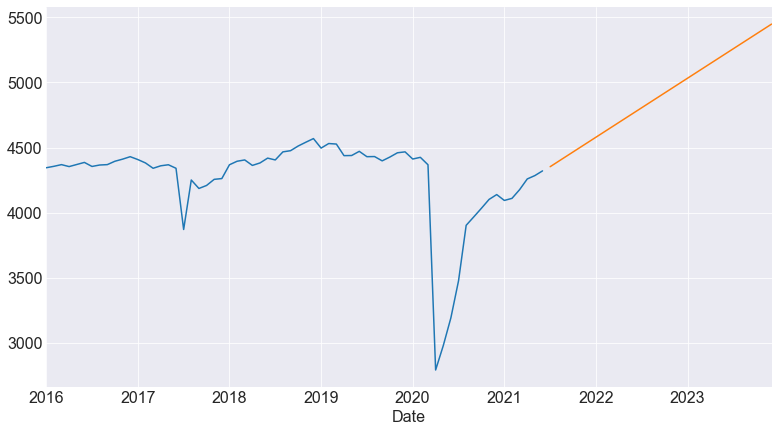

In [360]:
holts = model.predict(start = future_index[0], end = future_index[-1])
s_leather.plot()
holts.plot()

In [361]:
# get values that indicate recovery
s_leather['2019':'2020']

Date
2019-01-01    4496
2019-02-01    4531
2019-03-01    4527
2019-04-01    4438
2019-05-01    4439
2019-06-01    4471
2019-07-01    4430
2019-08-01    4431
2019-09-01    4398
2019-10-01    4427
2019-11-01    4460
2019-12-01    4467
2020-01-01    4412
2020-02-01    4425
2020-03-01    4368
2020-04-01    2792
2020-05-01    2979
2020-06-01    3193
2020-07-01    3477
2020-08-01    3903
2020-09-01    3968
2020-10-01    4034
2020-11-01    4102
2020-12-01    4139
Name: Total Employment, dtype: int64

In [362]:
holts

2021-07-01    4353.127275
2021-08-01    4390.890912
2021-09-01    4428.654549
2021-10-01    4466.418186
2021-11-01    4504.181823
2021-12-01    4541.945460
2022-01-01    4579.709097
2022-02-01    4617.472734
2022-03-01    4655.236371
2022-04-01    4693.000008
2022-05-01    4730.763645
2022-06-01    4768.527282
2022-07-01    4806.290919
2022-08-01    4844.054556
2022-09-01    4881.818193
2022-10-01    4919.581830
2022-11-01    4957.345467
2022-12-01    4995.109104
2023-01-01    5032.872740
2023-02-01    5070.636377
2023-03-01    5108.400014
2023-04-01    5146.163651
2023-05-01    5183.927288
2023-06-01    5221.690925
2023-07-01    5259.454562
2023-08-01    5297.218199
2023-09-01    5334.981836
2023-10-01    5372.745473
2023-11-01    5410.509110
2023-12-01    5448.272747
Freq: MS, dtype: float64

**Recovery date is 2021-09**

In [363]:
# redefine future index based on when recovery occured
future_index_str = [
    '2021-07',
    '2021-08',
    '2021-09',
    ]

future_index = pd.to_datetime(future_index_str)

len(future_index)

3

<AxesSubplot:xlabel='Date'>

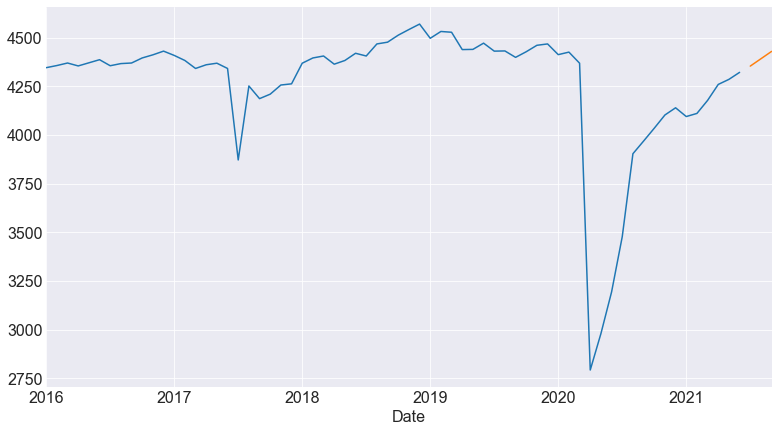

In [364]:
holts = model.predict(start = future_index[0], end = future_index[-1])
s_leather.plot()
holts.plot()

##### Last normal season 

##### Splits

In [365]:
train = s_leather['2016' : '2018']
test = s_leather['2019']

In [366]:
train.diff(12).mean()

33.166666666666664

##### Forecast

In [367]:
forecast = train['2018'] + (train.diff(12).mean())
forecast.index = test.index

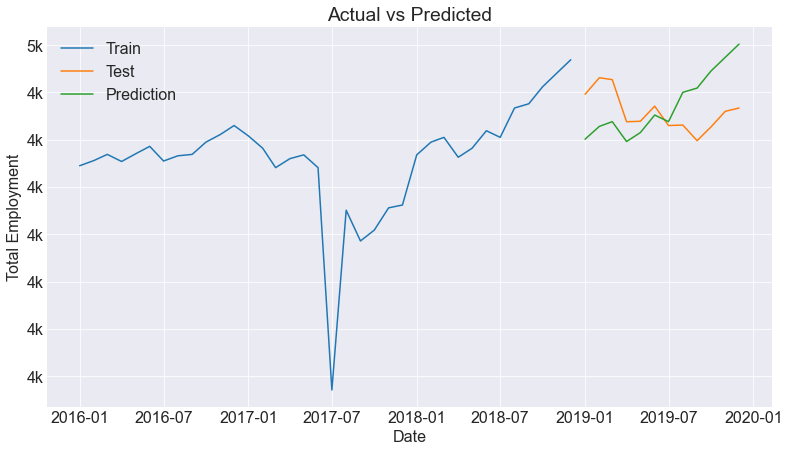

In [368]:
plt.plot(train, label='Train')
#plt.plot(validate, label='Validate')
plt.plot(test, label='Test')
plt.xlabel('Date')
plt.ylabel('Total Employment')
plt.plot(forecast, label = 'Prediction')
plt.title('Actual vs Predicted')
plt.legend()
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000))
plt.show()

In [369]:
# get RMSE
mean_squared_error(test, forecast, squared=False)

87.8485122874094

In [370]:
# get R^2
explained_variance_score(test, forecast)

-3.8274432467561565

In [371]:
# predict the future
# want to predict into future to get us to end of year 2023
# get values for respective months preceding pandemic 2018-11 to 2019-12
historical = s_leather['2018-10' : '2019-12']

In [372]:
# get index for seasonal prediction
future_index_str = [
    '2021-10',
    '2021-11',
    '2021-12', 
    '2022-01', 
    '2022-02', 
    '2022-03',
    '2022-04',
    '2022-05',
    '2022-06',
    '2022-07',
    '2022-08',
    '2022-09',
    '2022-10',
    '2022-11',
    '2022-12'
    ]

future_index = pd.to_datetime(future_index_str)

In [373]:
future = historical + train.diff(12).mean()
# still need to reset the index
future.index = future_index

<AxesSubplot:xlabel='Date'>

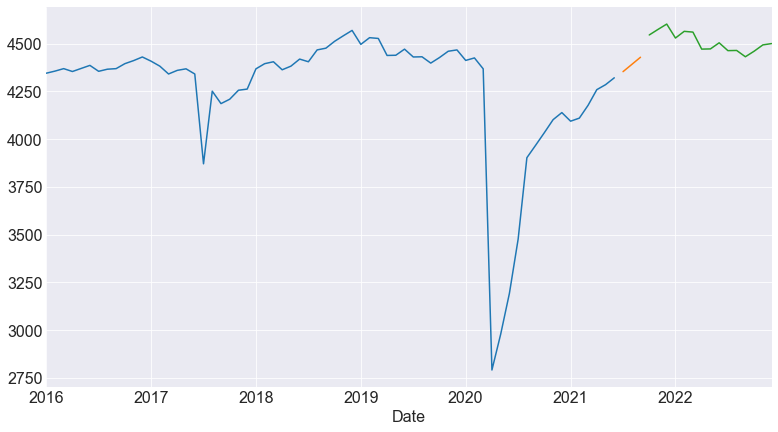

In [374]:
s_leather.plot()
holts.plot()
future.plot()

##### Final Plot

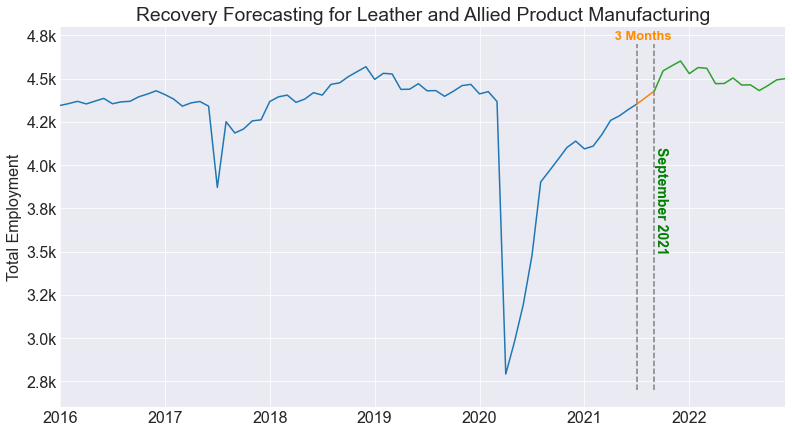

In [375]:
full_forecast = pd.concat([s_leather, holts, future])
full_forecast[ : '2021-07'].plot() # data we have
full_forecast['2021-07' : '2021-09'].plot() # linear recovery forecast
full_forecast['2021-09' : ].plot() # resumption forecast
plt.vlines(x='2021-07', ymin=2700, ymax=4700, linestyles='--', colors='gray')
plt.vlines(x='2021-09', ymin=2700, ymax=4700, linestyles='--', colors='gray')
plt.text('2021-04', 4725, ' 3 Months', fontsize=13, color='darkorange', fontweight='bold')
plt.text('2021-09', 3500, 'September 2021', fontsize=14, color='green', fontweight='bold', rotation='-90')
plt.gca().set (title='Recovery Forecasting for Leather and Allied Product Manufacturing', ylabel='Total Employment')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.1f}k'.format(x / 1_000));

#### Final Char DF

In [376]:
char_df

recovery
Motion Picture and Sound Recording Industries        61.763515
Performing Arts, Spectator Sports, and Related ...   74.684926
Accommodation                                        77.209860
Clothing and Clothing Accessories Stores             81.494898
Scenic and Sightseeing Transportation                88.888889
Amusement, Gambling, and Recreation Industries       89.903270
Personal and Laundry Services                        93.778813
Miscellaneous Store Retailers                        95.706924
Furniture and Home Furnishings Stores                95.801793
Food Services and Drinking Places                    95.909662
Leather and Allied Product Manufacturing             96.645046
Sporting Goods, Hobby, Musical Instrument, and ...  102.360633

In [377]:
months_to_recovery = {
    'Motion Picture and Sound Recording Industries' : 25,
    'Performing Arts, Spectator Sports, and Related Industries' : 16,
    'Accommodation' : 26,
    'Clothing and Clothing Accessories Stores ' : 9,
    'Scenic and Sightseeing Transportation' : 13,
    'Amusement, Gambling, and Recreation Industries' : 3,
    'Personal and Laundry Services' : 9,
    'Miscellaneous Store Retailers ' : 7,
    'Furniture and Home Furnishings Stores ' : 7,
    'Food Services and Drinking Places' : 5,
    'Leather and Allied Product Manufacturing' : 3,
    'Sporting Goods, Hobby, Musical Instrument, and Book Stores ' : 0
}

In [378]:
char_df['months_to_recovery'] = char_df.index.map(months_to_recovery)

In [379]:
char_df

recovery  \
Motion Picture and Sound Recording Industries        61.763515   
Performing Arts, Spectator Sports, and Related ...   74.684926   
Accommodation                                        77.209860   
Clothing and Clothing Accessories Stores             81.494898   
Scenic and Sightseeing Transportation                88.888889   
Amusement, Gambling, and Recreation Industries       89.903270   
Personal and Laundry Services                        93.778813   
Miscellaneous Store Retailers                        95.706924   
Furniture and Home Furnishings Stores                95.801793   
Food Services and Drinking Places                    95.909662   
Leather and Allied Product Manufacturing             96.645046   
Sporting Goods, Hobby, Musical Instrument, and ...  102.360633   

                                                    months_to_recovery  
Motion Picture and Sound Recording Industries                       25  
Performing Arts, Spectator Sports, and Related ...                  16  
Accommodation                                                       26  
Clothing and Clothing Accessories Stores                             9  
Scenic and Sightseeing Transportation                               13  
Amusement, Gambling, and Recreation Industries                       3  
Personal and Laundry Services                                        9  
Miscellaneous Store Retailers                                        7  
Furniture and Home Furnishings Stores                                7  
Food Services and Drinking Places                                    5  
Leather and Allied Product Manufacturing                             3  
Sporting Goods, Hobby, Musical Instrument, and ...                   0

In [380]:
recovery_month = {
    'Motion Picture and Sound Recording Industries' : 'July 2023',
    'Performing Arts, Spectator Sports, and Related Industries' : 'October 2022',
    'Accommodation' : 'August 2023',
    'Clothing and Clothing Accessories Stores ' : 'March 2022',
    'Scenic and Sightseeing Transportation' : 'July 2022',
    'Amusement, Gambling, and Recreation Industries' : 'September 2021',
    'Personal and Laundry Services' : 'March 2022',
    'Miscellaneous Store Retailers ' : 'January 2022',
    'Furniture and Home Furnishings Stores ' : 'January 2022',
    'Food Services and Drinking Places' : 'November 2021',
    'Leather and Allied Product Manufacturing' : 'September 2021',
    'Sporting Goods, Hobby, Musical Instrument, and Book Stores ' : 'Recovered'
}

In [381]:
char_df['recovery_month'] = char_df.index.map(recovery_month)

In [382]:
char_df

recovery  \
Motion Picture and Sound Recording Industries        61.763515   
Performing Arts, Spectator Sports, and Related ...   74.684926   
Accommodation                                        77.209860   
Clothing and Clothing Accessories Stores             81.494898   
Scenic and Sightseeing Transportation                88.888889   
Amusement, Gambling, and Recreation Industries       89.903270   
Personal and Laundry Services                        93.778813   
Miscellaneous Store Retailers                        95.706924   
Furniture and Home Furnishings Stores                95.801793   
Food Services and Drinking Places                    95.909662   
Leather and Allied Product Manufacturing             96.645046   
Sporting Goods, Hobby, Musical Instrument, and ...  102.360633   

                                                    months_to_recovery  \
Motion Picture and Sound Recording Industries                       25   
Performing Arts, Spectator Sports, and Related ...                  16   
Accommodation                                                       26   
Clothing and Clothing Accessories Stores                             9   
Scenic and Sightseeing Transportation                               13   
Amusement, Gambling, and Recreation Industries                       3   
Personal and Laundry Services                                        9   
Miscellaneous Store Retailers                                        7   
Furniture and Home Furnishings Stores                                7   
Food Services and Drinking Places                                    5   
Leather and Allied Product Manufacturing                             3   
Sporting Goods, Hobby, Musical Instrument, and ...                   0   

                                                    recovery_month  
Motion Picture and Sound Recording Industries            July 2023  
Performing Arts, Spectator Sports, and Related ...    October 2022  
Accommodation                                          August 2023  
Clothing and Clothing Accessories Stores                March 2022  
Scenic and Sightseeing Transportation                    July 2022  
Amusement, Gambling, and Recreation Industries      September 2021  
Personal and Laundry Services                           March 2022  
Miscellaneous Store Retailers                         January 2022  
Furniture and Home Furnishings Stores                 January 2022  
Food Services and Drinking Places                    November 2021  
Leather and Allied Product Manufacturing            September 2021  
Sporting Goods, Hobby, Musical Instrument, and ...       Recovered

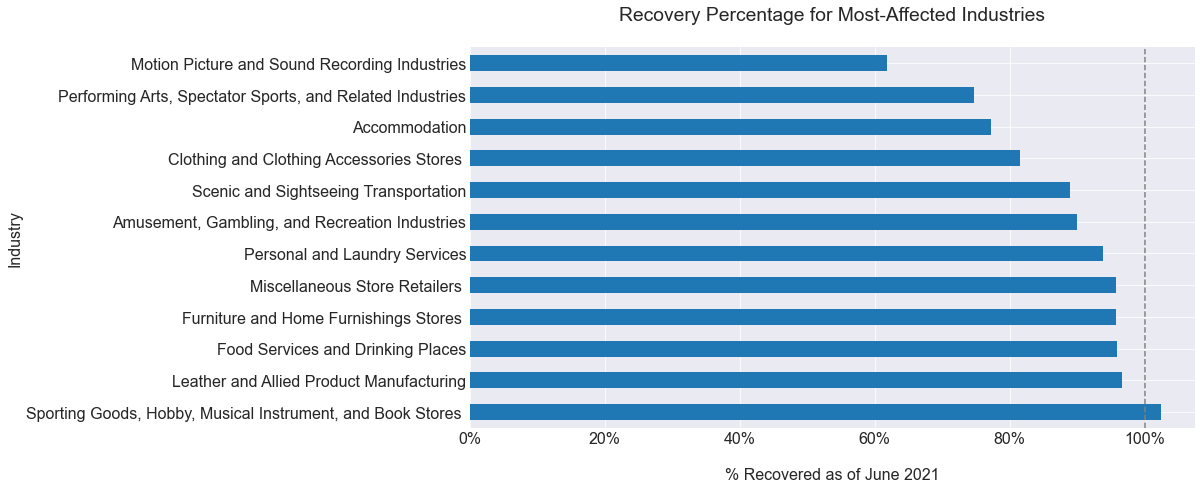

In [383]:
char_df.recovery.sort_values(ascending=False).plot.barh()
plt.gca().set(ylabel='Industry', xlabel='\n% Recovered as of June 2021', title='Recovery Percentage for Most-Affected Industries\n')
plt.vlines(x=100, ymin=-1, ymax=12, linestyles='--', colors='gray')
plt.gca().xaxis.set_major_formatter(lambda x, pos: '{:.0f}%'.format(x));

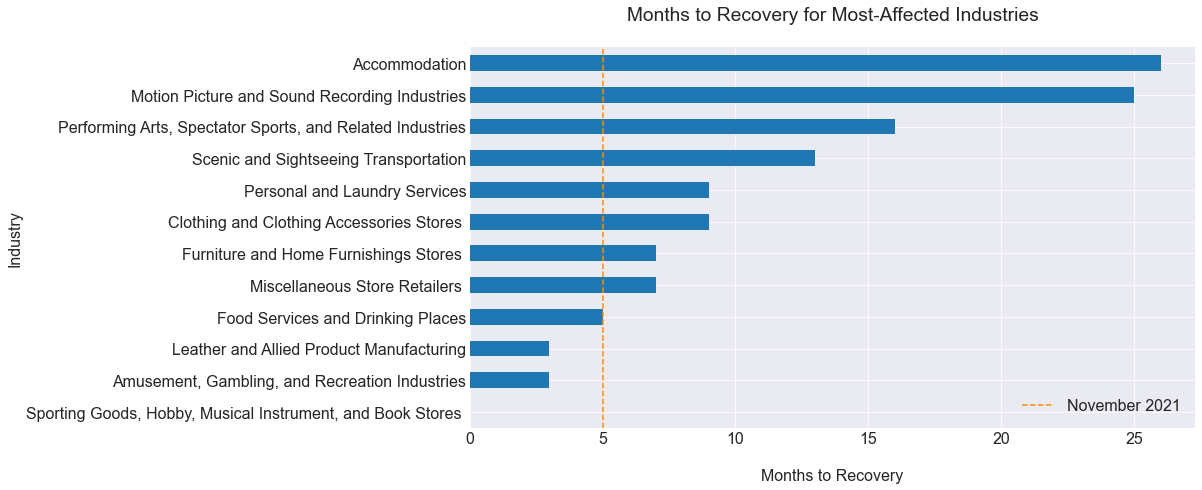

In [384]:
char_df.months_to_recovery.sort_values(ascending=True).plot.barh(label='')
plt.gca().set(ylabel='Industry', xlabel='\nMonths to Recovery', title='Months to Recovery for Most-Affected Industries\n');
plt.vlines(x=5, ymin=-1, ymax=12, linestyles='--', colors='darkorange', label='November 2021')
plt.legend(loc='lower right');

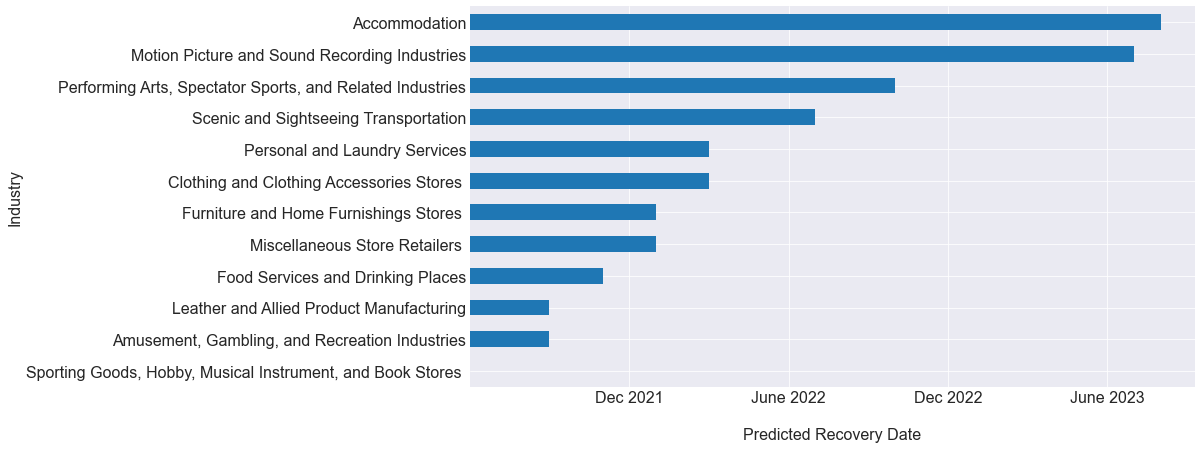

In [385]:
char_df.months_to_recovery.sort_values(ascending=True).plot.barh(label='')
plt.gca().set(ylabel='Industry', xlabel='\nPredicted Recovery Date');
plt.xticks(ticks=[6,12,18,24], labels=['Dec 2021', 'June 2022', 'Dec 2022', 'June 2023']);

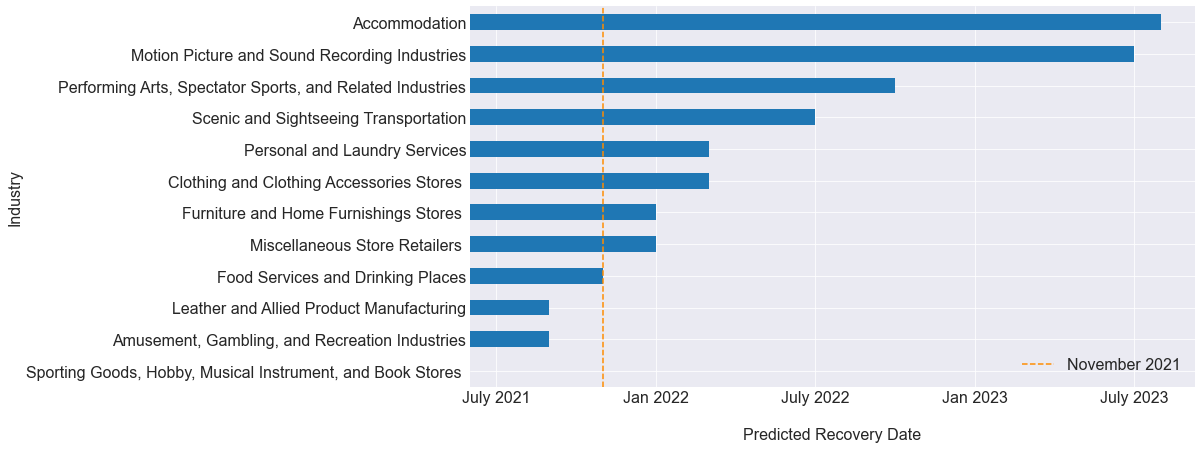

In [386]:
char_df.months_to_recovery.sort_values(ascending=True).plot.barh(label='')
plt.gca().set(ylabel='Industry', xlabel='\nPredicted Recovery Date')
plt.vlines(x=5, ymin=-1, ymax=12, linestyles='--', colors='darkorange', label='November 2021')
plt.xticks(ticks=[1, 7,13,19,25], labels=['July 2021','Jan 2022', 'July 2022', 'Jan 2023', 'July 2023'])
plt.legend(loc='lower right');

In [387]:
char_df.recovery_month

Motion Picture and Sound Recording Industries                       July 2023
Performing Arts, Spectator Sports, and Related Industries        October 2022
Accommodation                                                     August 2023
Clothing and Clothing Accessories Stores                           March 2022
Scenic and Sightseeing Transportation                               July 2022
Amusement, Gambling, and Recreation Industries                 September 2021
Personal and Laundry Services                                      March 2022
Miscellaneous Store Retailers                                    January 2022
Furniture and Home Furnishings Stores                            January 2022
Food Services and Drinking Places                               November 2021
Leather and Allied Product Manufacturing                       September 2021
Sporting Goods, Hobby, Musical Instrument, and Book Stores          Recovered
Name: recovery_month, dtype: object